# Section I: Project Overview

## Project Description:

Household formation is generally recognized as an important driver of economic growth, prosperity, and human flourisihing. But what does it mean to be a household? Households composition varies, ranging from nuclear families, to roommates arrangements, to extended kinship situations, etc. This analysis examines household composition, and the relationship of household composition to markers of prosperity, by country and over time. In essence, this project aims to answer the question, "What types of household configurations predict happy lives?"

A number of proxies for "happy" are considered. Initially, HDI (Human Development Index) is chosen as a proxy, but this causes indirect data leakage with many features, which are meaningful and informative; features which should not be discarded. To mitigate this, Gini Index was selected as an alternative target, preserving key features while stopping the leakage.

The dataset is both sparse and high dimensional, presenting challenges to handling missing values without significant information loss. Reconstructing incomplete data can increase bias, noise, and multicollinearity. To address this, I deploy three different strategies for data imputation: (A) Interpolation, (B) Iterative Imputation, and (C) Matrix Decomposition. I fit models on the resulting reconstructed data, and compare model performance and feature importance.

**Finally, I create a weighted Gini index, to reduce the influence of high-equality low-GDP countries in the target. Equality in a populace is not the best measure of human flourishing, if the people in question are equally poor.**


## Data Sources:

Four distinct data tables are used in this analysis:

The core data table is the "CoResidence Database", which was assembled by researchers at the University of Barcelona, for the EU Open Research Repository (pilot). Researchers compiled information about household configurations over time, from 1964-2023, both nationally and subnationally.

Additional tables were merged with the core table.

Data sets used are described below:


### 1) Table 1: CoResidence National Database
**The CORESIDENCE Database: National and Subnational Data on Household and Living Arrangements Around the World, 1964-2021**

The CoResidence database is the core table used in this analysis. Only national data is used. The National table consists of 809 entries and 178 features (1 out of 179 was a metadata tag and was dropped). 156 countries are represented, but not all countries have data available for every year in the time series range.

What I refer to as "core features" in this analysis, consist of the features that describe household composition. Population, demographic, and economic development data features are also included in the CoResidence dataser.

Column names in CoResidence are encoded. Core features columns begin with "H" in the name. Population and development features begin with "P" and "D" respectively. A metadata table "Codebook" deciphers the CoResidence column names. The column 'Sub_family' in Codebook table denotes four categories of core features:

1) Household headship (HH)
2) Size and age composition (HS)
3) Relationship to head (HR)
4) Household typology (HT)

More detail about each sub family can be found in Section II.

**Citation**: Esteve, A., Galeano, J., Turu, A., García-Román, J., Becca, F., Fang, H., Pohl, M. L. C., & Trias Prat, R. (2023).  Zenodo. https://doi.org/10.5281/zenodo.8142652

### 2) Merge I - The Gini Index 

The Gini Index measures the extent to which the distribution of income (or, in some cases, consumption expenditure) among individuals or households within an economy deviates from a perfectly equal distribution. Gini values range from 0 to 100, and represent the absolute value of the delta between perfect equality de facto distribution of income. The higher the Gini value, the more unequal the subject population is.

A Lorenz curve plots the cumulative percentages of total income received against the cumulative number of recipients, starting with the poorest individual or household. The Gini Index measures the area between the Lorenz curve and a hypothetical line of absolute equality, expressed as a percentage of the maximum area under the line. Thus a Gini index of 0 represents perfect equality (the 1:1 line), while an index of 100 implies perfect inequality (L-shape).

**Citation**: World Bank, Poverty and Inequality Platform. Data are based on primary household survey data obtained from government statistical agencies and World Bank country departments. Data for high-income economies are mostly from the Luxembourg Income Study database. For more information and methodology, please see pip.worldbank.org. 

https://data.worldbank.org/indicator/SI.POV.GINI

### 3) Merge II - UNPD Most Used

United Nations Population Division "Most Used" Table consists of most commonly used indicators pertaining to the populations of all countries.

https://population.un.org/wpp/Download/Standard/MostUsed/

Copyright © 2024 by United Nations, made available under a Creative Commons license CC BY 3.0 IGO: http://creativecommons.org/licenses/by/3.0/igo/ Suggested citation: United Nations, Department of Economic and Social Affairs, Population Division (2024). World Population Prospects 2024, Online Edition.


### 4) Merge III - UNDP

United Nations Development Programme. Table consists of all composite indices of the HDI (Human Development Index).

Citation not found. Data can be found at division website: https://hdr.undp.org/data-center/documentation-and-downloads


## Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


# Feature Selection
from sklearn.feature_selection import mutual_info_regression

# Model Selection
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score

# Linear Model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Word Matching
from thefuzz import process, fuzz

# Data Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.decomposition import TruncatedSVD, NMF

# Tree Estimators
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# SVM
from sklearn.svm import SVR

# KNN
from sklearn.neighbors import KNeighborsRegressor

# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

# Metrics
from sklearn.metrics import mean_squared_error

## Formulas and Persistent Data Storage

In [2]:
# initiate a list all_results to store model results across use of tscv_loop

all_results = []
trained_models = []

In [3]:
# models dictionary

models_dictionary = {
            "Linear Regression" : LinearRegression(),
            "Lasso" : Lasso(),
            "Ridge" : Ridge(),
            "Random Forest" : RandomForestRegressor(random_state=21),
            "KNN" : KNeighborsRegressor(),
            "SVR" : SVR() #default rbf kernel
}

In [4]:
# formula to streamline modelling and scoring

def tscv_loop(X, y, dataset, n_splits, models=None, scaling=True):
    """ 
    Runs cross validation on a time series split, evaluates models, and stores all results in all_results.
    Data must be sorted in temporal order. In order to avoid confusion, loop will eject if dataset name is repeated.
    StandardScaler is applied (unless specified otherwise) for Lasso and Ridge models, but not to simplex columns. 
    Alpha values for Lasso and Ridge are autotuned to best score. 
    
    Parameters: 
    - X (DataFrame): Feature matrix
    - y (Series): Target variable
    - dataset (str): Name of dataset, can be any name
    - n_splits (Integer): (TimeSeriesSplit number of splits)
    - models (dict): Dictionary of model names and initialized models. Defaults to Lasso, Ridge, and Random Forest
    - alpha (float): Value for Lasso alpha, default is 0.1
    - scaling (boolean): Apply scaling to data for certain models. If "False" skips scaling step.
    - n_components (int): Number of components for 
    
    Returns: 
    - DataFrame: Train/Test scores for each time series fold, for each model. 
    * For scale-sensitive models, StandardScaler is used on X
    - Dictionary: A dictionary of model names and trained models, which have the .feature_importances_ attribute 
    
    """
    # Check all_results dictionary for a dataset already with that name. Short circuit loop if already used.
    # Could be a warning in automated pipeline.
    if any(entry.get('Dataset')==dataset for entry in all_results):
        print("You have already used this dataset name. Please pass a new dataset name or clear all_results.")
        return
    
    # default models in this loop if no dictionary is passed
    if models is None:
        models = models_dictionary
    
    # initialize the scaler if scaling==True (default)
    if scaling:
        scaler = StandardScaler()
    
    # initialize X_used to default X and scale for Lasso and Ridge
    X_used = X
    
    # exclude simplex columns from scaling, as these have been transformed with Central Log Ratio already
    columns_to_scale = X.columns.difference(all_clr_columns)
    
    if scaling and any(isinstance(m, (Lasso, Ridge, LinearRegression)) for m in models.values()):
            print(f"Standard Scaler applied for scale-sensitive models.")
            X_scaled = scaler.fit_transform(X[columns_to_scale])
            X_scaled_subset = pd.DataFrame(X_scaled, columns=columns_to_scale, index=X.index)
            X_used = X.copy()
            X_used[columns_to_scale] = X_scaled_subset
            
    # initialize the time series split
    tscv = TimeSeriesSplit(n_splits = n_splits)
    
    
    # split the data, loop over the time series folds
    for i, (train_index, test_index) in enumerate(tscv.split(X_used)):
        X_train, y_train = X_used.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X_used.iloc[test_index], y.iloc[test_index]

        # initialize dictionary to store trained models for feature importances and coef
        trained_models_dict ={
            "Dataset":dataset,
            "Fold": i+1,
            "Features":X.columns.tolist()
        }
        
        # initialize dictionary to store fold scores for each fold, model
        fold_scores = {
            "Dataset":dataset,
            "Fold":i+1,
        }
    
        # for each fold, check if the model is Lasso. If it is, autotune alpha
        for model_name, model in models.items(): 
            if isinstance(model, Lasso):
                best_lasso_mse = np.inf
                best_lasso_alpha = None


                for lasso_alpha in [0.0001, 0.001, 0.01, 1, 10, 100]:
                    print(f"Running temp model {model} at alpha {lasso_alpha}")
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        temp_model = Lasso(alpha=lasso_alpha)
                        temp_model.fit(X_train, y_train)
                        y_pred = temp_model.predict(X_test)
                    mse = mean_squared_error(y_test, y_pred)

                    if mse < best_lasso_mse:
                        best_lasso_mse = mse
                        best_lasso_alpha = lasso_alpha

                model = Lasso(alpha=best_lasso_alpha)
                    
                # capture convergence warnings for lasso
                with (warnings.catch_warnings(record=True) as w):
                    warnings.simplefilter("always")
                    print(f"Running optimal {model} alpha {best_lasso_alpha}")
                    model.fit(X_train, y_train)

                    train_score = model.score(X_train, y_train)
                    test_score = model.score(X_test, y_test)

                    converged = not any(issubclass(warning.category, ConvergenceWarning) for warning in w)

                    # capture converge? and scores in fold dictionary
                    fold_scores['Lasso Alpha'] = best_lasso_alpha
                    fold_scores['Lasso Converged'] = 'Yes' if converged else 'No'
   
            # for each fold, check if model is Ridge. If it is, autotune Ridge
            elif isinstance(model, Ridge):
                best_ridge_mse = np.inf
                best_ridge_alpha = None

                for ridge_alpha in [0.01, 0.1, 1, 10, 50, 100, 1000]:
                    print(f"Running temp model {model} at alpha{ridge_alpha}")
                    with warnings.catch_warnings():
                        warnings.simplefilter('ignore')
                        temp_model = Ridge(alpha=ridge_alpha)
                        temp_model.fit(X_train, y_train)
                        y_pred = temp_model.predict(X_test)                  
                    mse = mean_squared_error(y_test, y_pred)

                    if mse < best_ridge_mse:
                        best_ridge_mse = mse
                        best_ridge_alpha = ridge_alpha

                model = Ridge(alpha=best_ridge_alpha)
                model.fit(X_train, y_train)

                train_score = model.score(X_train, y_train)
                test_score = model.score(X_test, y_test)

                # capture matrix condition
                linalg_cond = np.linalg.cond(X_train)

                fold_scores['Ridge Alpha'] = best_ridge_alpha
                fold_scores["Matrix Cond"] = ("Severely ill" if linalg_cond > 1e8
                                              else "Ill-conditioned" if linalg_cond > 1e5
                                              else "Stable")
    
            # if model is neither Lasso nor Ridge, skip autotune alpha and fit, score
            else:
                model = model.fit(X_train, y_train)
                train_score = model.score(X_train, y_train)
                test_score = model.score(X_test, y_test)

            fold_scores[f"{model_name} Train Score"] = train_score
            fold_scores[f"{model_name} Test Score"] = test_score

            if hasattr(model, 'feature_importances_'):
                trained_models_dict[f"{model_name} Importances"] = model.feature_importances_
                
            if hasattr(model, 'coef_'):
                trained_models_dict[f"{model_name} Coefficients"] = model.coef_

        # append fold scores to persistent data storage list all_results
        all_results.append(fold_scores)
        
        # append trained models to trained models dictionary
        trained_models.append(trained_models_dict)
        
    return pd.DataFrame(all_results), trained_models

# Section II: Data Validation

## Table 1: Core Table and Metadata: 

CoResidence (df) and metadata table Codebook (code_dict)

Only "National" data has been used in this analysis. For validation purposes, sub-national data is examined. For some countries, national data appears to be mean of sub-national data, per year; whereas other countries have national data that is not a simple mean of subnational data. Sub-national year range is smaller or equal to the range represented in national data. In other words, sub-national data is equally or less comprehensive in terms of timeseries range.

Original shape of National dataset: (809, 179)

Feature groups:
- Core features describe household configuration and are in columns whose names start with 'H' ('HH', 'HS', 'HT', 'HR')
- Supplemental features pertaining to population or economy are in columns whose names start in 'D' or 'P'
- Place and Timeseries column names start with C (Country Name, Country Code) or T (Year)

Null values are distributed throughout, but mostly found outside of core features columns. 
- 91 columns out of 179 contain null values. Most of these missing values are not in core features
- Four rows (218, 219, 427, 428), which contain large sections of missing values in core features were b/ffilled
- All other missing values pertain to HT (household typology) group
- Columns HT18 and HT31 contain 530 null values converted to zero based on context (see II.3)
- All 809 rows contain at least one null value

Core features consist of two types: Proportions and Averages. For the most part, proportion categories belong to groups of columns, which sum to 1. Some proportion features are absolute proportions, as they are not part of any set of columns that adds to 1.

In [5]:
# Read in National Coresidence Dataset

df_raw = pd.read_csv("./A0_CORESIDENCE_NATIONAL_DATASET_2024.csv",
                index_col='Unnamed: 0')

In [6]:
df = df_raw.copy()

In [7]:
# Inspect table
df.head()

,C0,C1,C2,C3,C4,T1,T2,T3,T5,T10,...,D6,D7,D8,D9,D10,D11,D12,D13,D14,DB
1,AF,AFG,Afghanistan,ASIA,Southern Asia,2015,2010,1,2011,2010,...,2101.589319,0.364833,7.791942,1.272154,681.131699,0.542189,12.44832,3.015346,3489.646939,NATIONAL
2,AO,AGO,Angola,AFRICA,Middle Africa,2015,2010,1,2011,2010,...,7652.656486,0.549279,10.690100,3.657993,6626.812049,0.614968,12.70450,5.922784,8705.839878,NATIONAL
3,AL,ALB,Albania,EUROPE,Southern Europe,2008,2010,0,2006,2000,...,9962.442236,0.715264,12.348200,8.771930,7208.741202,0.753432,11.90664,9.836990,12720.559540,NATIONAL
4,AL,ALB,Albania,EUROPE,Southern Europe,2017,2020,1,2016,2010,...,12802.148310,0.797816,15.511230,11.122311,10148.612870,0.805385,14.17994,10.721275,15442.824030,NATIONAL
5,AR,ARG,Argentina,LATIN-AMERICA,South America,1970,1970,0,1966,1960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NATIONAL


In [8]:
# inspect C3 regions
df['C3'].value_counts()

AFRICA           241
EUROPE           212
ASIA             167
LATIN-AMERICA    144
OCEANIA           32
NORTH-AMERICA     11
Eastern Asia       2
Name: C3, dtype: int64

In [9]:
# Read in dataset metadata to interpret column names of coresidence
code_dict = pd.read_csv('./CODEBOOK_2024.csv', usecols=['Code', 'Sub_family', 'Description'])

# Cols excluded contain uni-value tags not needed in this analysis

In [10]:
# Check for inf values, which appear later. Will fix in HT section (II. 3)
inf_mask = df.applymap(lambda x: x==np.inf or x==-np.inf)
inf_mask_filter = df.loc[inf_mask.any(axis=1),inf_mask.any(axis=0)]
inf_mask_filter

,HT16,HT18,HT31
79,3.594203,inf,inf
325,inf,NaN,NaN
547,3.169451,inf,inf
569,4.687744,inf,inf
758,2.451415,inf,inf


In [11]:
# Typo discovered in column name. "Fertily" should be Fertility
code_dict.loc[code_dict['Description'].str.startswith(('f','F')), :]

,Sub_family,Code,Description
149,NaN,T5,Five years
164,NaN,P3,Fertily rate


In [12]:
# Replace 'Fertily' with 'Fertility'

code_dict['Description'] = code_dict['Description'].replace('Fertily rate', 'Fertility rate')

In [13]:
# Check to see if replace worked:

code_dict.loc[code_dict['Description'].str.startswith(('F', 'f')), :]

,Sub_family,Code,Description
149,NaN,T5,Five years
164,NaN,P3,Fertility rate


In [14]:
# drop unneeded columns. see Changes Log for descriptions

drop_cols_list = ['S1', 'S2', 'T2', 'T3', 'T5', 'T10', 'C0', 'C3', 'C4', 'P2', 'DB']

df = df.drop(drop_cols_list, axis=1)


### Core Features (H Columns)

In [15]:
# Inspect core feature categories from metadata table
print('Feature Categories')
print(code_dict['Sub_family'].value_counts())
print(f"Number of Household Features: {code_dict['Sub_family'].value_counts().sum()}")

# All core feature categories begin with H and have a secondary letter code shown in the table below

Feature Categories
Household headship (H)          56
Size and age composition (S)    30
Relationship to head (R)        30
Household typology (T)          30
Name: Sub_family, dtype: int64
Number of Household Features: 146


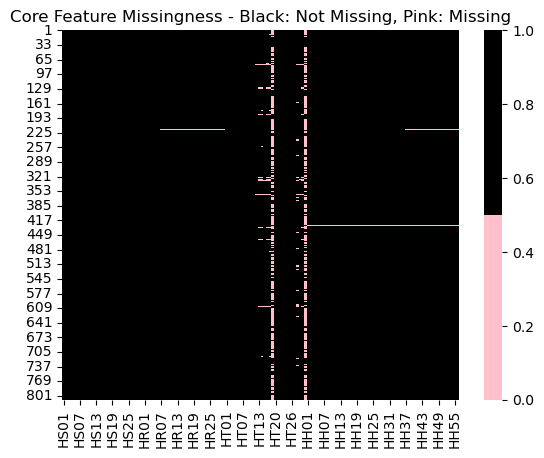

In [16]:
# Inspect where core features have null values

core_features = df.loc[:, df.columns.str.startswith('H')]
core_features_null_mask = core_features.notnull()

sns.heatmap(core_features_null_mask, cmap=['Pink', 'Black'])
plt.title("Core Feature Missingness - Black: Not Missing, Pink: Missing")
plt.show()

# Most null values are in HT18 and HT31. Potentially these are zero values and not null values.

#### 1) Household Headship (HH)

The household headship sub family of features describes household headship in two ways, **compositional data** and **averages** both of which are bifurcated by sex.
- Proportions of households by size and type, separated by male and female 
- Averages of household size and type, separated by male and female

Male/Female-Headed are relative proportion columns, which add up to 1 (null values back filled and forward filled within respective country groups in rows 218, 219, 427, 428)

First column ('HH01') Proportion Male-Headed 
Second column ('HH02') Proportion Female-Headed ('HH01':'HH02' sum to one)

(I) Two main proportion vectors, bifurcated by male/female-headed are as follows:

**Vector a** Size of Household (compositional, relative proportions sum to one)
1) One person household (proportion male/female head of household)
2) Two person household ""
3) Three person household ""
4) Four person household ""
5) Five person household ""
6) Six person household ""
7) Seven person household ""
8) Eight person household ""
9) Nine person household ""
10) Ten person household ""
11) 11+ person household ""

- Proportion male headed columns: 'HH03':'HH13' (11 columns).
- Proportion female headed columns: 'HH14':'HH24' (11 columns).

**Vector b** Type of Household
1) Unipersonal (proportion male/female head of household)
2) Nuclear relationships to head
3) Stem-family relationships to head
4) Other family relationships to head
5) Non-family relationships to head
5) Other (residual)

- Proportion male headed columns: 'HH25':'HH30' (5 columns).
- Proportion female headed columns: 'HH31':'HH36' (5 columns).

(II) The averages vector is bifurcated by male-headed or female headed:

**Vector c** Size or Type
1) Average household size (in female/male headed household)
2) Average number of children (in female/male headed household)
2) "" of adults
3) "" spouses
4) "" persons 65+
5) "" childs
6) "" other relatives
7) "" other non-relatives
8) "" male adults
9) "" female adults

Columns are odd/even, male/female respectively, for the above group 'HH37':'HH56' (10 male, 10 female).

Note: In exactly 773 rows, compositional columns in fact sum to one. In 36 rows, this sum mysteriously fails. I inspected the indices for the 36 rows with summation failure, and the indices are not the same for all groups. Based on this pattern, I suspect that there were data merge errors in the original data, where an aggregate of 36 items were not propertly normalized. I corrected this by normalizing the rows where summation fails, such that they add to one.

In [17]:
# Inspect feature categories: Sub Family - Household Headship

with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame(code_dict.loc[code_dict['Sub_family'].str.contains('headship', na=False),['Description', 'Code']].values))
    
    

,0,1
0,Proportion of male-headed households,HH01
1,Proportion of female-headed households,HH02
2,Proportion of 1-person households of male-headed households,HH03
3,Proportion of 2-persons households of male-headed households,HH04
4,Proportion of 3-persons households of male-headed households,HH05
5,Proportion of 4-persons households of male-headed households,HH06
6,Proportion of 5-persons households of male-headed households,HH07
7,Proportion of 6-persons households of male-headed households,HH08
8,Proportion of 7-persons households of male-headed households,HH09
9,Proportion of 8-persons households of male-headed households,HH10


In [18]:
# Do male/female add up to 1 in all proportion categories?

print(f"Number of rows male/female headship whose sum is 1.0: {np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0).sum()}")


print(f"Number of male-headed 1-11+ person hh whose sum is 1.0: {np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0).sum()}")
print(f"Number of female-headed 1-11+ person hh whose sum is 1.0: {np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0).sum()}")

print(f"Number of male-headed by type hh whose sum is 1.0: {np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0).sum()}")
print(f"Number of female-headed by type hh whose sum is 1.0: {np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0).sum()}")

# I don't think it's a coincidence that proportion categories appear to sum to 1.0 across exact number of rows
# This may be indicative of a previous merge error in the data


Number of rows male/female headship whose sum is 1.0: 773
Number of male-headed 1-11+ person hh whose sum is 1.0: 773
Number of female-headed 1-11+ person hh whose sum is 1.0: 773
Number of male-headed by type hh whose sum is 1.0: 773
Number of female-headed by type hh whose sum is 1.0: 773


In [19]:
# Inspect rows where sum does not add up

print(f"Number of rows male/female headship whose sum is ~1.0: {(~np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0)).sum()}")


print(f"Number of male-headed 1-11+ person hh whose sum is ~1.0: {(~np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0)).sum()}")
print(f"Number of female-headed 1-11+ person hh whose sum is ~1.0: {(~np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0)).sum()}")

print(f"Number of male-headed by type hh whose sume is ~1.0: {(~np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0)).sum()}")
print(f"Number of female-headed by type hh whose sum is ~1.0: {(~np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0)).sum()}")



Number of rows male/female headship whose sum is ~1.0: 36
Number of male-headed 1-11+ person hh whose sum is ~1.0: 36
Number of female-headed 1-11+ person hh whose sum is ~1.0: 36
Number of male-headed by type hh whose sume is ~1.0: 36
Number of female-headed by type hh whose sum is ~1.0: 36


In [20]:
# Inspect index of proportion row groups that have summation failures within household headship groups

print("Male or Female Head of Household - HH01:HH02")
print(f"{df[(~np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0))].index}")

print("Male Head: 1-11+ person household - HH03:HH13")
print(f"{df[(~np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0))].index}")

print("Female Head: 1-11+ person household - HH14:HH24")
print(f"{df[(~np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0))].index}")

print("Male Head by type: uni, nuclear, stem, family, non, other - HH25:HH30")
print(f"{df[(~np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0))].index}")

print("Female Head by type: uni, nuclear, stem, family, non, other - HH31:HH36")
print(f"{df[(~np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0))].index}")

# No consistency across all groups that fail to sum. Male and female groups have same failure indexes

Male or Female Head of Household - HH01:HH02
Int64Index([  5,  12,  59,  71, 138, 156, 187, 206, 275, 298, 316, 317, 350,
            351, 357, 391, 407, 428, 443, 469, 471, 516, 528, 529, 541, 542,
            543, 546, 650, 691, 704, 719, 745, 751, 789, 797],
           dtype='int64')
Male Head: 1-11+ person household - HH03:HH13
Int64Index([ 32,  33,  49,  73, 108, 117, 118, 123, 128, 147, 172, 185, 187,
            202, 220, 226, 260, 277, 298, 313, 314, 352, 363, 365, 383, 388,
            425, 428, 480, 532, 539, 624, 662, 692, 696, 798],
           dtype='int64')
Female Head: 1-11+ person household - HH14:HH24
Int64Index([ 16,  21,  23,  24,  28,  30,  31, 108, 117, 118, 123, 128, 147,
            185, 202, 220, 226, 260, 298, 313, 350, 352, 363, 365, 388, 428,
            480, 519, 532, 539, 558, 624, 696, 746, 798, 801],
           dtype='int64')
Male Head by type: uni, nuclear, stem, family, non, other - HH25:HH30
Int64Index([ 32,  33,  49,  73, 108, 117, 118, 123, 128, 147, 

In [21]:
# Check for null values in HH group

df[df.loc[:,df.columns.str.startswith('HH')].isnull().any(axis=1)]



,C1,C2,T1,HS01,HS02,HS03,HS04,HS05,HS06,HS07,...,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14
218,ESP,Spain,2010,0.204793,0.304099,0.224190,0.200054,0.049470,0.012972,0.002980,...,0.980,37173.68190,0.857565,16.746531,9.12660,28285.62443,0.874665,15.934190,9.61129,46273.56322
219,ESP,Spain,2015,0.222342,0.319907,0.215353,0.185834,0.042585,0.009752,0.002738,...,0.981,37383.58643,0.879667,17.780121,9.77008,29466.57168,0.896751,17.179159,10.06324,45581.24946
427,KOR,South Korea,1975,0.050962,0.092906,0.127205,0.160751,0.178004,0.159865,0.113597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428,KOR,South Korea,1980,0.045267,0.102738,0.145484,0.205664,0.199192,0.146487,0.097708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Inspect surrounding columns to determine if backfill frontfill will work

pd.concat([df.loc[217:220,df.columns.str.startswith(('HH','C','T'))], df.loc[426:429,df.columns.str.startswith(('HH','C','T'))]])


# Surrounding values are populated. Good to frontfill and backfill. 
# Other null values in d columns are fine to ffill and backfill as well

,C1,C2,T1,HH01,HH02,HH03,HH04,HH05,HH06,HH07,...,HH47,HH48,HH49,HH50,HH51,HH52,HH53,HH54,HH55,HH56
217,ESP,Spain,2005,0.651544,0.348456,0.090887,0.285861,0.250091,0.267310,0.077154,...,0.986817,0.740554,0.152802,0.191842,0.026344,0.028865,1.298277,0.660922,1.055987,1.256585
218,ESP,Spain,2010,0.545336,0.454664,0.144591,0.310997,0.237682,0.232608,0.055579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219,ESP,Spain,2015,0.536732,0.463268,0.165309,0.321726,0.230740,0.218010,0.048395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,ESP,Spain,2021,0.544369,0.455631,0.191326,0.332579,0.203257,0.196987,0.040756,...,0.670334,0.684711,0.173197,0.162967,0.032843,0.018399,1.224752,0.703103,0.886900,1.233258
426,KOR,South Korea,1970,0.897651,0.102349,0.000863,0.070556,0.111235,0.141740,0.175557,...,3.035974,2.272008,0.441491,0.357978,0.163010,0.213377,1.371856,0.394773,1.416338,1.503439
427,KOR,South Korea,1975,0.854716,0.145284,0.021550,0.075475,0.117936,0.160983,0.188939,...,2.792896,1.820398,0.412999,0.263917,0.097577,0.116315,NaN,NaN,NaN,NaN
428,KOR,South Korea,1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,KOR,South Korea,1985,0.842407,0.157593,0.029205,0.102609,0.161392,0.273736,0.213850,...,1.981509,1.204044,0.369165,0.367252,0.073454,0.153066,1.366772,0.422406,1.314438,1.443553


In [23]:
# ffill and bfill missing values in hh

df.loc[217:429,:] = df.loc[217:429,:].ffill().bfill()

In [24]:
# Check for null values again after backfilling and forward filling


df.loc[:, df.columns.str.startswith('H')].isnull().sum().sort_values(ascending=False).head(12)

HT31    394
HT18    394
HT17     26
HT28     25
HT14     22
HT16     20
HT13     19
HT30     17
HT29      4
HT15      3
HT12      2
HH51      0
dtype: int64

In [25]:
# Inspect columns where proportion figures do not add up to 1

normalize_groups = [df[(~np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1),1.0))], 
                    df[(~np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1),1.0))], 
                    df[(~np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1),1.0))], 
                    df[(~np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1),1.0))], 
                    df[(~np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1),1.0))]
                   ]


In [26]:
# create row index for normalization using the rows identified in normalize_groups

target_cols_row_index = set()
for group in normalize_groups:
    for x in group.index:
        target_cols_row_index.add(x)
        
#target_cols_row_index

In [27]:
# Normalize values in each group

normalize_groups = [df.loc[:,'HH01':'HH02'], 
                    df.loc[:,'HH03':'HH13'], 
                    df.loc[:,'HH14':'HH24'], 
                    df.loc[:,'HH25':'HH30'], 
                    df.loc[:,'HH31':'HH36']
                   ]

for row in target_cols_row_index:
    for group in normalize_groups:
        columns = group.columns
        denominator = df.loc[row, columns].sum()
        df.loc[row, columns] = df.loc[row, columns].apply(lambda x: x/denominator)

In [28]:
# Verify that normalization worked by printing any rows that fail to add up to 1

print("Male or Female Head of Household:")
print(f"{df[(~np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0))].index}")

print("Male Head: 1-11+ person household")
print(f"{df[(~np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0))].index}")

print("Female Head: 1-11+ person household")
print(f"{df[(~np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0))].index}")

print("Male Head by type: uni, nuclear, stem, family, non, other")
print(f"{df[(~np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0))].index}")

print("Female Head by type: uni, nuclear, stem, family, non, other")
print(f"{df[(~np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0))].index}")



Male or Female Head of Household:
Int64Index([], dtype='int64')
Male Head: 1-11+ person household
Int64Index([], dtype='int64')
Female Head: 1-11+ person household
Int64Index([], dtype='int64')
Male Head by type: uni, nuclear, stem, family, non, other
Int64Index([], dtype='int64')
Female Head by type: uni, nuclear, stem, family, non, other
Int64Index([], dtype='int64')


In [29]:
# Double verify that normalization worked


print(f"Number of rows male/female headship whose sum is 1.0 (HH01:HH02): {np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0).sum()}")


print(f"Number of male-headed 1-11+ person hh whose sum is 1.0 (HH03:HH13): {np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0).sum()}")
print(f"Number of female-headed 1-11+ person hh whose sum is 1.0 (HH14:HH24): {np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0).sum()}")

print(f"Number of male-headed by type hh whose sume is 1.0 (HH25:HH30): {np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0).sum()}")
print(f"Number of female-headed by type hh whose sum is 1.0 (HH31:HH36): {np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0).sum()}")

# All proportion group 809 rows now add up to 1

Number of rows male/female headship whose sum is 1.0 (HH01:HH02): 809
Number of male-headed 1-11+ person hh whose sum is 1.0 (HH03:HH13): 809
Number of female-headed 1-11+ person hh whose sum is 1.0 (HH14:HH24): 809
Number of male-headed by type hh whose sume is 1.0 (HH25:HH30): 809
Number of female-headed by type hh whose sum is 1.0 (HH31:HH36): 809


In [30]:
# Check for null values in HH groups


df.loc[:,df.columns.str.startswith('HH')].isnull().any(axis=1).any()

# No null values remaining in HH sub family

False

#### 2) Size and age composition (HS)

The size and age composition sub family is split into three groups of compositional features (relative proportions), and averages

Proportion Groups:

(I) The first 11 columns ('HS01':'HS11') are relative proportions and add up to 1

1) Proportion of 1 person households
2) "" 2 person ""
3) "" 3 person ""
4) "" 4 person ""
5) "" 5 person ""
6) "" 6 person ""
7) "" 7 person ""
8) "" 8 person ""
9) "" 9 person ""
10) "" 10 person ""
11) "" 11+ person ""

(II) The next three columns are relative proportions ('HS12':'HS14') add up to 1 when 'HS01' (1-person households) is included

1) Proportion of 2-3 person households
2) "" 4-5 person ""
3) "" 6+ person ""

(III) The last two proportion columns ('HS15','HS16') do not add up to 1, and there are no other columns that complete the sum. Thus, I make the assumption that these are absolute proportions, to be understood as Y/N with the stated value representing Y.

Average Groups (HS17:HS30):

1) 'Average household size'
2) 'Average number of 0-4 children in the household'
3) 'Average number of adults in the household (aged 18+)'
4) 'Average number of children in the household (aged < 18)'
5) 'Average number of persons aged 65+ in the household'
6) 'Average number of 0-9 individuals in the household'
7) 'Average number of 10-19 individuals in the household'
8) 'Average number of 20-29 individuals in the household'
9) 'Average number of 30-39 individuals in the household'
10) 'Average number of 40-49 individuals in the household'
11) 'Average number of 50-59 individuals in the household'
12) 'Average number of 60-69 individuals in the household'
13) 'Average number of 70-79 individuals in the household'
14) 'Average number of 80+ individuals in the household'

In [31]:
# Size and age composition

with pd.option_context('display.max_colwidth', None):
    display(code_dict.loc[code_dict['Code'].str.startswith('HS'), ['Code','Description']])


,Code,Description
0,HS01,Proportion of 1-person households
1,HS02,Proportion of 2-persons households
2,HS03,Proportion of 3-persons households
3,HS04,Proportion of 4-persons households
4,HS05,Proportion of 5-persons households
5,HS06,Proportion of 6-persons households
6,HS07,Proportion of 7-persons households
7,HS08,Proportion of 8-persons households
8,HS09,Proportion of 9-persons households
9,HS10,Proportion of 10-persons households


In [32]:
# Proportion of #-person households summation
# Columns HS01-HS11 add up to 1

np.isclose(df.loc[:,'HS01':'HS11'].sum(axis=1), 1.0).all()

True

In [33]:
# Proportion of #-# person households summation

df.loc[:,'HS12':'HS14'].sum(axis=1).sort_values()


183    0.595094
390    0.605828
462    0.607974
182    0.610392
185    0.619704
         ...   
571    0.990161
572    0.991192
195    0.993345
1      0.998565
426    0.998751
Length: 809, dtype: float64

In [34]:
# Search for stray column that adds up to 1

for col in df.select_dtypes(exclude=['object']):
    remainder_fix = df.loc[:, 'HS12':'HS14'].sum(axis=1) + df[col]
    if np.isclose(remainder_fix, 1.0).all():
        print(f'Fix column found: {col}')
    
# HT01 is the same value in Household Typology sub family

Fix column found: HS01
Fix column found: HT01
Fix column found: HT20


In [35]:
# Inspect these fix columns. It makes some sense why HS01 == HT01 == HT20
code_dict.loc[
    (code_dict['Code'] == 'HS01') | 
    (code_dict['Code'] == 'HT01') | 
    (code_dict['Code'] == 'HT20'),
    ['Code','Description']]

,Code,Description
0,HS01,Proportion of 1-person households
60,HT01,Proportion of unipersonal households
78,HT20,Proportion of unipersonal households


In [36]:
# create a copy of HS01 to use for Central Log Ratio transformation

df['HS01_copy'] = df['HS01'].copy()

In [37]:
# Proportion of households with at least one person 0-4 (HS15), at least one person 65+ (HS16)

df.loc[:, 'HS15':'HS16'].sum(axis=1)

1      0.880057
2      0.734931
3      0.523940
4      0.552676
5      0.480692
         ...   
805    0.621919
806    0.649612
807    0.644526
808    0.620795
809    0.637744
Length: 809, dtype: float64

In [38]:
# Search for a stray column that may be needed to complete

found = False

for col in df.select_dtypes(exclude=['object']).columns:
    test_sum = (df.loc[:,'HS15':'HS16'].sum(axis=1) + df[col])
    if (np.isclose(test_sum, 1.0)).all():
        print(f"Stray column found: {col}")
        found = True

if not found:
    print("No stray column found.")
    
# No other column adds up to 1 with HS15 and HS16
# Assumption: these are raw proportions and not meant to add up to 1

No stray column found.


In [39]:
# no single columns completed the sum
# search for a combination of multiple columns that may be needed to complete the sum

iter_cols = df.loc[:,df.columns.str.startswith('HS')]#.select_dtypes(exclude=['object']).columns

for num_iters in range(1, 6):
    found = False
    for col_combos in itertools.combinations(iter_cols, num_iters):
        test_sum = df.loc[:,'HS15':'HS16'].sum(axis=1) + df[list(col_combos)].sum(axis=1)
        if np.isclose(test_sum, 1.0).all():
            print(f"Remainder col found: {col_combos}")
            found = True
            break
    else: 
        if not found:
            print("Remainder column/s that sum to one with HS15:HS16 not found")

# No combinations found that will complete sum for Household Size proportion stragglers

Remainder column/s that sum to one with HS15:HS16 not found
Remainder column/s that sum to one with HS15:HS16 not found
Remainder column/s that sum to one with HS15:HS16 not found
Remainder column/s that sum to one with HS15:HS16 not found
Remainder column/s that sum to one with HS15:HS16 not found


In [40]:
# Check for null values before concluding section

df.loc[:, df.columns.str.startswith('HS')].isnull().any().any()

# No null values in household size category

False

#### 3) Household Typology (HT)

The household typology sub family of features consists of two types of groupings: **Compositional Data** and **Averages**. 
1) Proportion groupings describe the type of household by relationship to head
2) Average size of household by relationship to head

Each of these two types of groupings has two iterations, for a total of four column groupings. 

One is more extensive, while the other contains consolidated categories. I assume that the categories are consolidated, because some of the columns across the two groupings are duplicates. Thus, I conclude that the difference between the groupings is one of consolidation.


Group I - Relative proportion grouping:
1) Proportion unipersonal households
2) Proportion households with nuclear relationships to head
3) "" nuclear and other family ""
4) "" nuclear and non family ""
5) "" nuclear, other family, and non family ""
6) "" non nuclear family ""
7) "" non family ""
8) "" non nuclear family and non family ""
9) "" non nuclear family and/or non family ""

**Proportion columns** ('HT01':'HT09') add to one.
**Average size of household columns**, by diversified typology groups above: ('HT10':'HT18')


Group II - Simplified proportion grouping:
1) Proportion of unipersonal households
1) Proportion of households with nuclear relationships to head
2) Proportion of stem-family households based on relationship to head
3) Proportion of other family households based on relationship to head
4) Proportion non family households based on relationship to head
5) Proportion of other relative and / or non relative households based on relationship to head (residual category)

**Proportion columns add to one ('HT20':'HT25')**
**Average size of household by type ('HT26':'HT31')

Note on null values:
HT18 and HT31 contain 394 missing values each. The two columns HT18 and HT31 are residual categories for atypical households, and null values are assumed to be zero due to residual nature. All other null values are sporadic (26 null values or less), and are found in the "averages" columns. Thus, these values are assumed to be zero as well. Therefore, all null values in HT category were replaced with zero (0).

In [41]:
# Inspect Household Typology columns

HT = pd.DataFrame(code_dict[code_dict['Sub_family'].str.contains('typology', na=False)].values)
name_mapper = {col:name for col in HT.columns for name in ["Sub Family", "Column", "Description"]}
HT = HT.rename(name_mapper, axis=1)

with pd.option_context('display.max_colwidth', None):
    display(HT)


,Description,Description,Description
0,Household typology (T),HT01,Proportion of unipersonal households
1,Household typology (T),HT02,Proportion of households with nuclear relationships to head
2,Household typology (T),HT03,Proportion of households with nuclear and other family relationships to head
3,Household typology (T),HT04,Proportion of households with nuclear and non family relationships to head
4,Household typology (T),HT05,"Proportion of households with nuclear, other family, and non family relationships to head"
5,Household typology (T),HT06,Proportion of households with non nuclear family relationships to head
6,Household typology (T),HT07,Proportion of households with non family relationships to head
7,Household typology (T),HT08,Proportion of households with non nuclear family and non family relationships to head
8,Household typology (T),HT09,Proportion of households with non nuclear family and / or non family relationships to head
9,Household typology (T),HT10,Average size of unipersonal households


In [42]:
# Household Typology - Proportion category checks. Ensure all proportions add up to 1.0

assert np.isclose(df.loc[:,'HT01': 'HT09'].sum(axis=1), 1).all(), 'Typology proportions do not add up to 1'
assert np.isclose(df.loc[:,'HT20':'HT25'].sum(axis=1), 1).all(), 'Typology proportions do not add up to 1'


In [43]:
# Check for duplicate columns

dupe_cols = df.T[df.T.duplicated(keep=False)].index
print(dupe_cols)

dupe_pairs = []

for i, col1 in enumerate(dupe_cols):
    for col2 in dupe_cols[i+1:]:
        if df[col1].equals(df[col2]):
            dupe_pairs.append((col1, col2))
            

Index(['HS01', 'HR01', 'HT01', 'HT02', 'HT09', 'HT10', 'HT11', 'HT18', 'HT20',
       'HT21', 'HT25', 'HT26', 'HT27', 'HT31', 'HS01_copy'],
      dtype='object')


In [44]:
dupe_pairs = pd.DataFrame(dupe_pairs, columns=['set1', 'set2'])
dupe_pairs


,set1,set2
0,HS01,HS01_copy
1,HR01,HT10
2,HR01,HT26
3,HT01,HT20
4,HT02,HT21
5,HT09,HT25
6,HT10,HT26
7,HT11,HT27
8,HT18,HT31


In [45]:
# Lookup descriptions corresponding to duplicate columns

dupe_pairs['set1_des'] = dupe_pairs.merge(code_dict, left_on='set1', right_on='Code', how='left')['Description']
dupe_pairs['set2_des'] = dupe_pairs.merge(code_dict, left_on='set2', right_on='Code', how='left')['Description']

with pd.option_context('display.max_colwidth', None):
    display(dupe_pairs)
    
# Some duplicates may resolve after compositional data fixes. See "Compositional Data" section below

,set1,set2,set1_des,set2_des
0,HS01,HS01_copy,Proportion of 1-person households,NaN
1,HR01,HT10,Average number of heads in the household,Average size of unipersonal households
2,HR01,HT26,Average number of heads in the household,Average size of unipersonal households based on relationship to head
3,HT01,HT20,Proportion of unipersonal households,Proportion of unipersonal households
4,HT02,HT21,Proportion of households with nuclear relationships to head,Proportion of households with nuclear relationships to head
5,HT09,HT25,Proportion of households with non nuclear family and / or non family relationships to head,Proportion of other relative and / or non relative households based on relationship to head (residual category)
6,HT10,HT26,Average size of unipersonal households,Average size of unipersonal households based on relationship to head
7,HT11,HT27,Average size of households with nuclear relationships to head,Average size of nuclear households based on relationship to head
8,HT18,HT31,Average size of households with non nuclear family and / or non family relationships to head,Average size of other relative and/or non relative households based on relationship to head (residual category)


In [46]:
# HT01 to HT09:  Proportion groups add to one
np.isclose(df.loc[:,'HT01':'HT09'].sum(axis=1), 1.0).all()

True

In [47]:
# Check that proportion groupings add to one

df.loc[:, 'HT20':'HT25'].sum(axis=1).all()

# Proportion groupings add to one respectively. HT01 and HT20 are not duplicates. Each is necessary in its own grouping.

True

In [48]:
# Check null values again

df.loc[:, df.columns.str.startswith('HT')].isnull().sum().sort_values(ascending=False).head(10)

# Categories after HT10 are averages, not proportions. Assume all null values to be zero.

HT31    394
HT18    394
HT17     26
HT28     25
HT14     22
HT16     20
HT13     19
HT30     17
HT29      4
HT15      3
dtype: int64

In [49]:
# Replace null Household Typology (HT) columns with almost-zeros for potential log transforms

df.loc[:, df.columns.str.startswith('HT')] = df.loc[:, df.columns.str.startswith('HT')].fillna(1e-16)

In [50]:
# Check that null values are filled

df.loc[:, df.columns.str.startswith('HT')].isnull().any().any()

False

#### 4) Relationship to head (HR)

All features in sub family "Relationship to Head" are expressed in raw averages, in contrast to all other sub families, which contain compositional groupings. There are no proportion categories in HR, unlike the other three sub families. 

HR data consists of 30 features, which represent a cross-tabulation of the following two vectors, expressed as an average:

**Vector a** Number of heads or members by relationship to head:
1) Heads in Household (average number of heads in household of b size)
2) Spouses of head (average number of spouses in household of b size)
3) Children of head ""
4) Other relatives of head ""
5) Non-relatives of head ""
6) Other (residual category) ""

**Vector b** Number of :
1) Household (*unspecified size*)
2) 2-person household
3) 3-person household
4) 4-person household
5) 5-person household

Therefore, a total of 30 (6 groups by 5 crosstabs) columns: 'HR01' through 'HR30'. Five groups are 
1) HR01:HR06 (unspecified size)
2) HR07:HR12 (2-person hh)
3) HR13:HR18 (3-person hh)
4) HR19:HR24 (4-person hh)
5) HR25:HR30 (5-person hh)

Assumptions about the data in this sub-family include the following:

- 'HR01':'HR06' descriptions do not specify a household size. Thus 
- If the household were "unipersonal" the remaining cross-tabulations would all be be populated with 1.0 or 0.0-values, because the household by definition only contains one person (and zero others). I explored whether the unspecified household size was an average of the other size categories, but the numbers clearly did not add up to a mean. Thus, I conclude that the household size is merely unspecified in the first group of six.


In [51]:
# No proportion categories in "Relationship to head," all averages

with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame(code_dict.loc[code_dict['Code'].str.startswith('HR'), ['Description', 'Code']].values))

,0,1
0,Average number of heads in the household,HR01
1,Average number of spouses of the head in the household,HR02
2,Average number of children of the head in the household,HR03
3,Average number of other relatives of the head in the household,HR04
4,Average number of non relatives of the head in the household,HR05
5,Average number of other relatives and/or non relatives of the head in the household,HR06
6,Average number of Heads in 2 persons household,HR07
7,Average number of Spouses in 2 persons household,HR08
8,Average number of Children in 2 persons household,HR09
9,Average number of Other relatives in 2 persons household,HR10


In [52]:
# Check for null values

df.loc[:,df.columns.str.startswith('HR')].isnull().any().any()

# No null values

False

[0] max is 5.258203387957618
[1] max is 0.5732398728617071
[2] max is 1.7244520260960328
[3] max is 2.772968706392554
[4] max is 3.8122783307194004


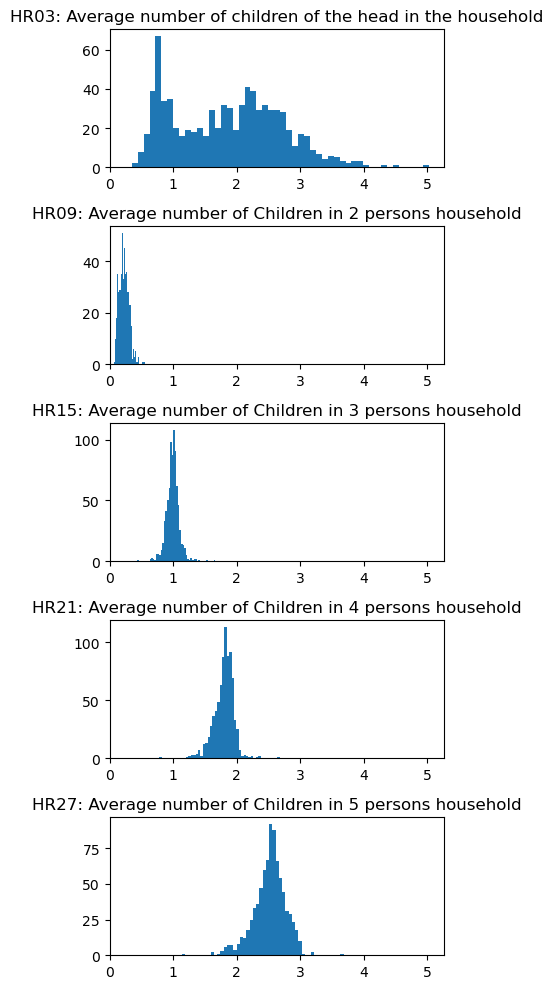

In [53]:
# Average number of children of the head in household of unspecified size
# Examine category to determine what size "unspecified" HR03 might be

fig, ax = plt.subplots(5, 1, figsize=(4,10))

for i in range(5):
        col_index = 3 + (i * 6)
        col_name = f'HR{col_index:02d}'
        ax[i].hist(df[col_name], bins=50)
        ax[i].set_title(f"{col_name}: {code_dict.loc[code_dict['Code']==col_name, 'Description'].values[0]}")

x_maxes = []

for i in range(5):
        x_maxes.append(ax[i].get_xlim()[1])
        print(f'{[i]} max is {ax[i].get_xlim()[1]}')

x_max = max(x_maxes)

for i in range(5):
        ax[i].set_xlim(0, x_max)

plt.tight_layout()

plt.show()

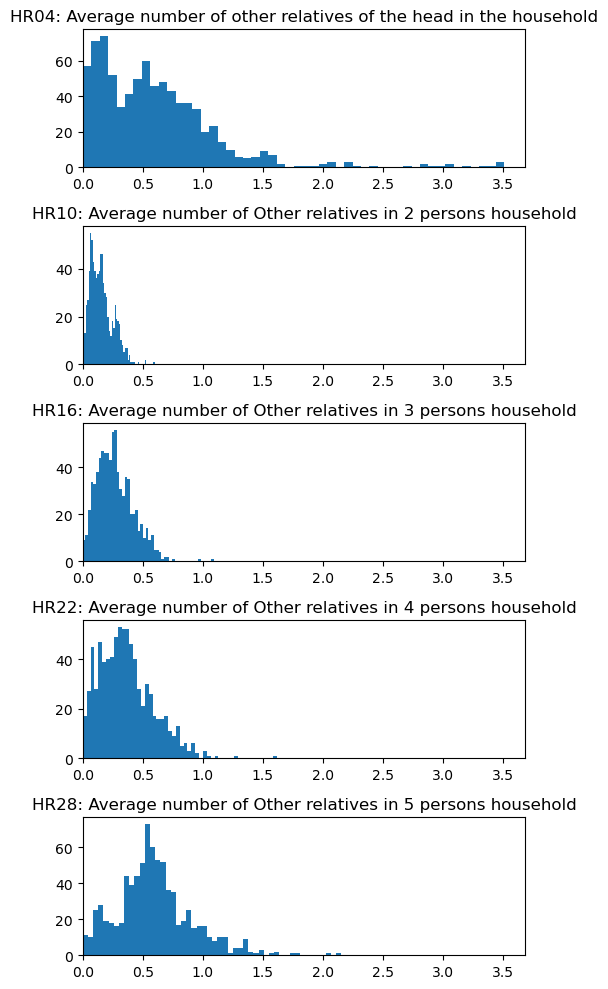

<Figure size 640x480 with 0 Axes>

In [54]:
# Average number of other relatives in household of varying size

fig, ax = plt.subplots(5, 1, figsize=(5,10))

for i in range(5):
        col_index = 4 + (i * 6)
        col_name = f'HR{col_index:02d}'
        ax[i].hist(df[col_name], bins=50)
        ax[i].set_title(f"{col_name}: {code_dict.loc[code_dict['Code']==col_name, 'Description'].values[0]}")

x_maxes = []

for i in range(5):
        x_maxes.append(ax[i].get_xlim()[1])
        #print(f'{[i]} max is {ax[i].get_xlim()[1]}')

x_max = max(x_maxes)

for i in range(5):
        ax[i].set_xlim(0, x_max)

plt.tight_layout()

plt.show()
plt.clf()

In [55]:
# Is the first set of averages (unspecified household size) an average of the other 4 sets?
# Is it the sum?

for i in range(6):
    agg_list = []
    
    target_col_index = 1 + i # construct index for columns in first grouping HR01:HR06
    target_column_name = f"HR{target_col_index:02d}"
    print(f"Target column: {target_column_name} is a mean or a sum of the following columns?")
    
    for j in range(4):
        meansum_col_index = 7+i + 6*j # skip ahead by 7 initially, plus 6*j for each iteration, to retrieve axis cols
        meansum_cols_names = f"HR{meansum_col_index:02d}"
        agg_list.append(meansum_cols_names)
        print(meansum_cols_names)
    agg_df = df[agg_list]

    mean = agg_df.mean(axis=1)
    sum_total = agg_df.sum(axis=1)
    target_col = df[target_column_name]
    
    if np.isclose(target_col, mean, atol=1e-3).all():
        print(f'{target_column_name} is the mean of {agg_list}')
    elif np.isclose(target_col, sum_total, atol=1e-3).all():
        print(f'{target_column_name} is the sum of {agg_list}')
    else:
        print('No cigar!')

# No. Unclear that it could plausibly represent 1-person households

Target column: HR01 is a mean or a sum of the following columns?
HR07
HR13
HR19
HR25
No cigar!
Target column: HR02 is a mean or a sum of the following columns?
HR08
HR14
HR20
HR26
No cigar!
Target column: HR03 is a mean or a sum of the following columns?
HR09
HR15
HR21
HR27
No cigar!
Target column: HR04 is a mean or a sum of the following columns?
HR10
HR16
HR22
HR28
No cigar!
Target column: HR05 is a mean or a sum of the following columns?
HR11
HR17
HR23
HR29
No cigar!
Target column: HR06 is a mean or a sum of the following columns?
HR12
HR18
HR24
HR30
No cigar!


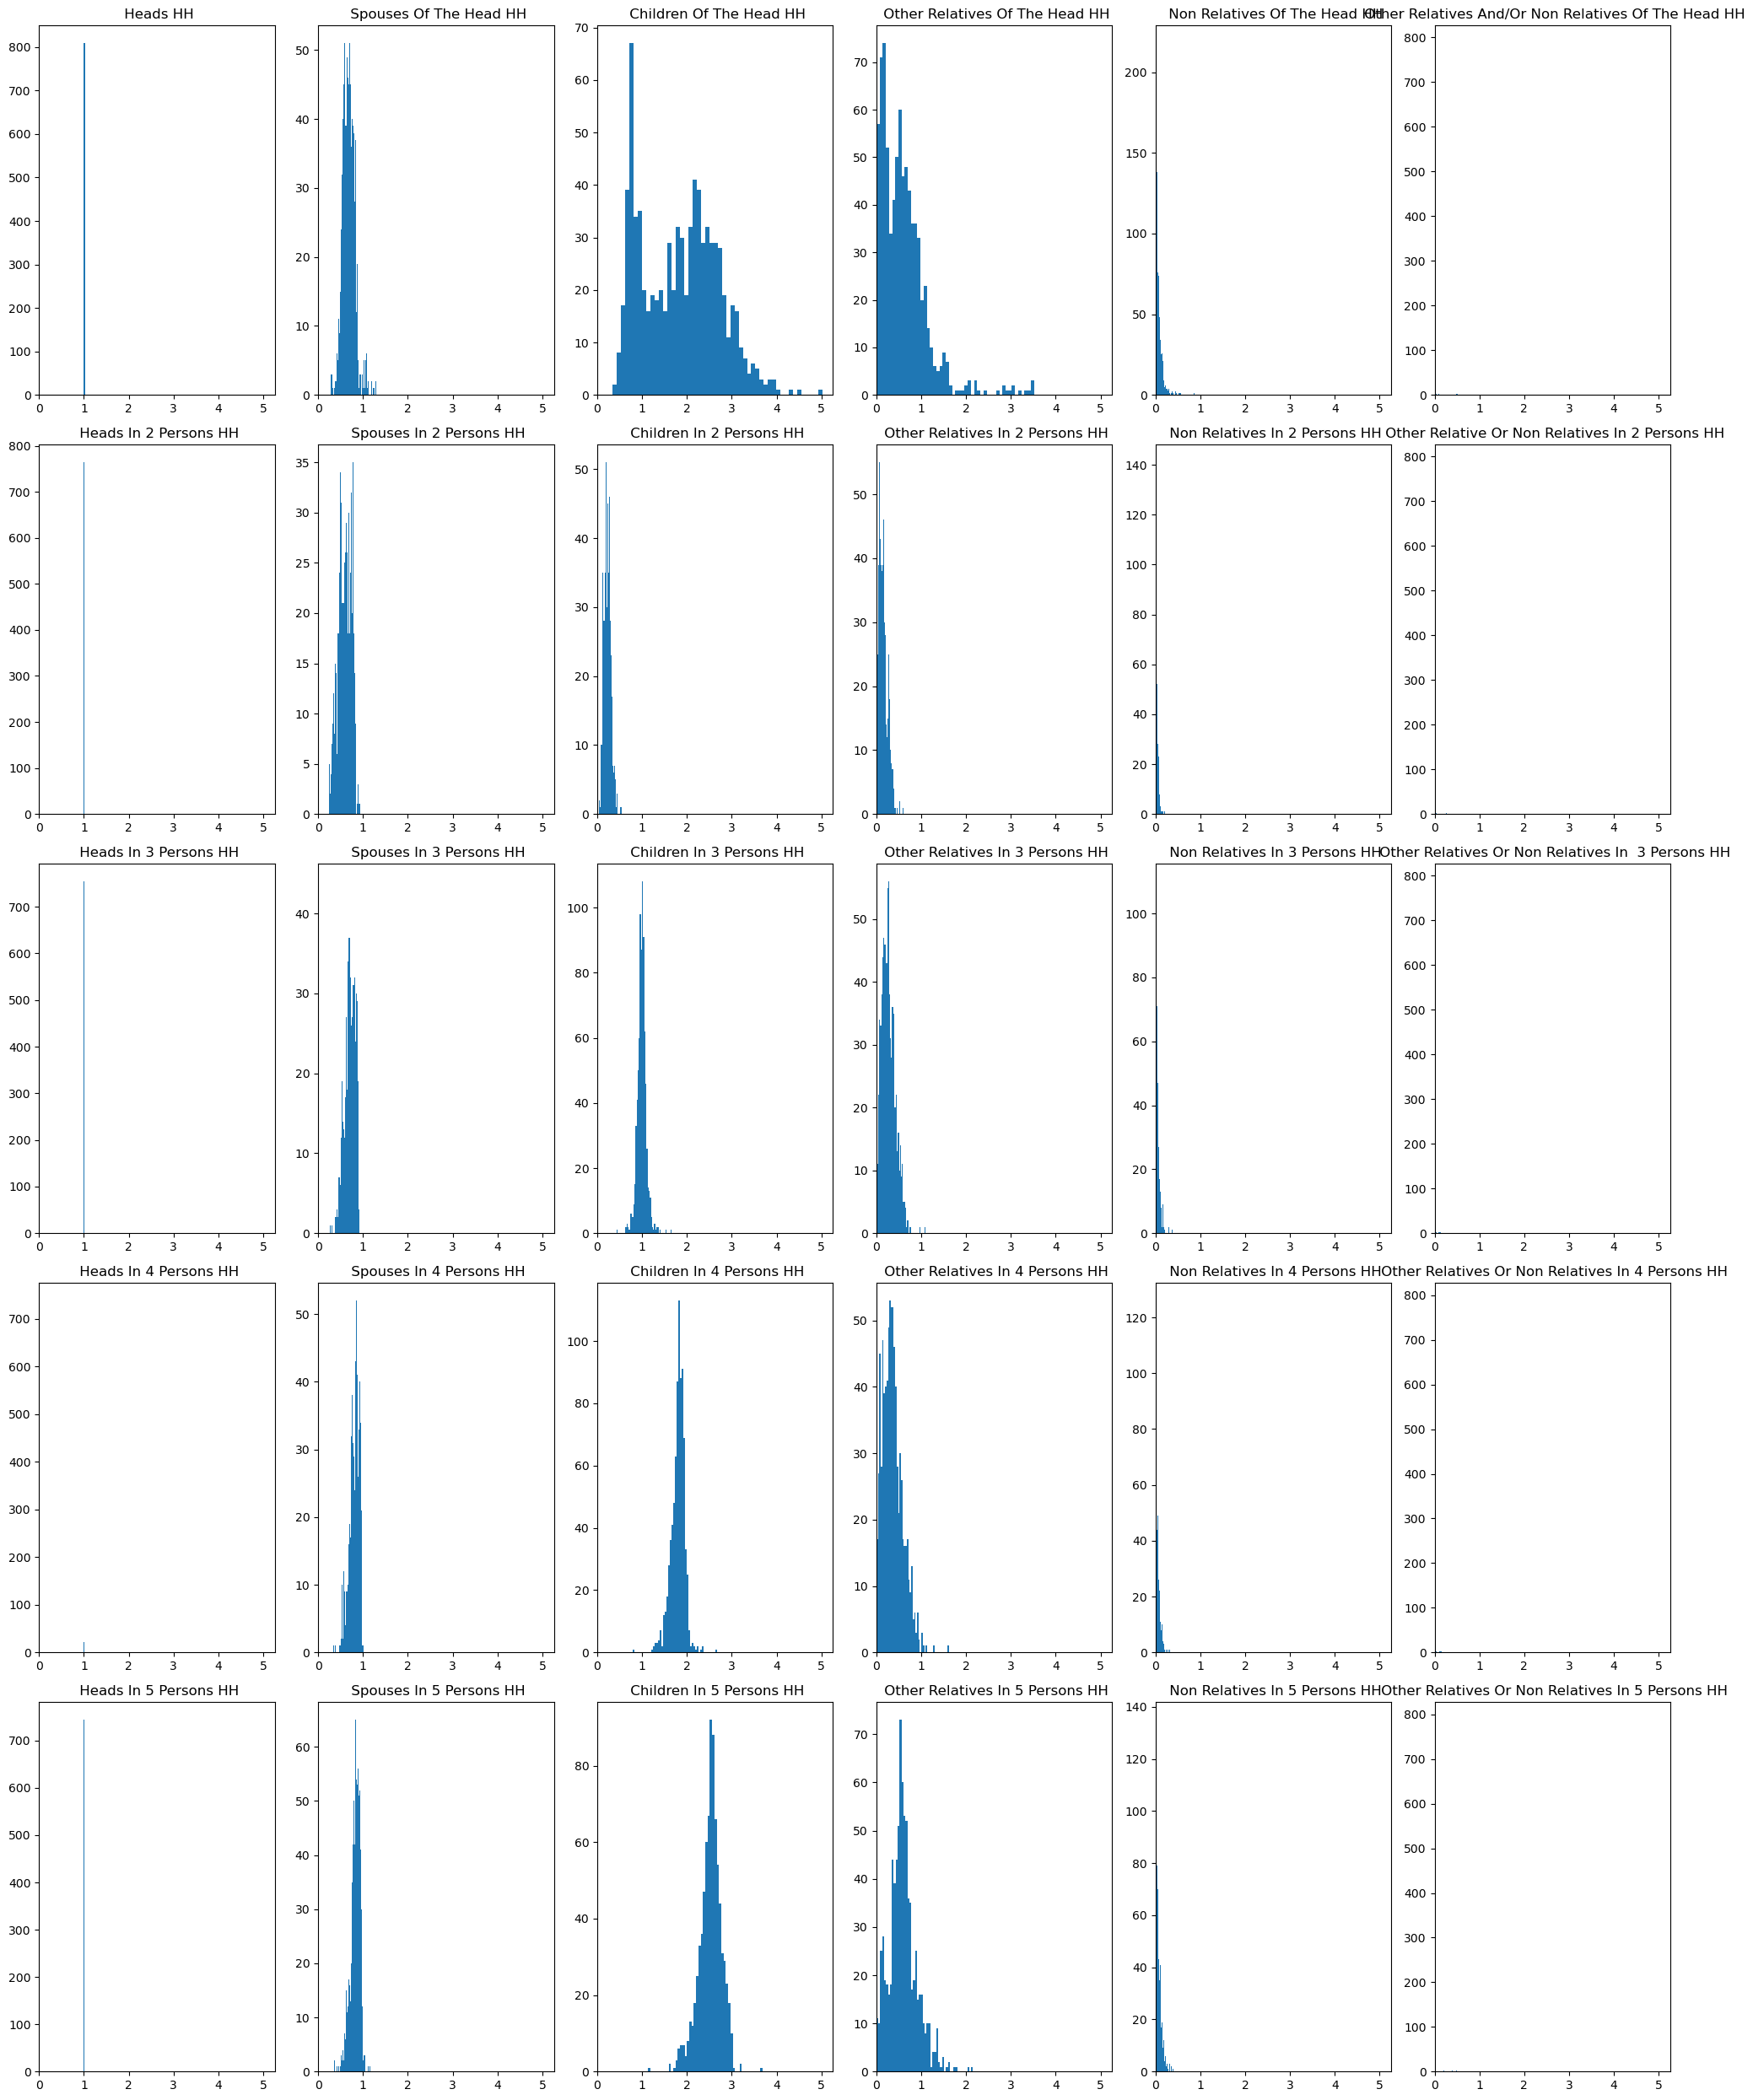

In [56]:
# Average number of people in 1-5 person household

fig, ax = plt.subplots(5, 6, figsize=(20,25))

col_index = 1

for i in range(5):
    for j in range(6):
        col_name = f'HR{col_index:02d}'
        ax[i,j].hist(df[col_name], bins=50)
        title = f"{code_dict.loc[code_dict['Code']==col_name, 'Description'].values[0]}"
        title_stripped = title.replace('Average number of','').replace('in the household', 'household')
        title_stripped = title_stripped.title().replace('Household','HH')
        ax[i,j].set_title(title_stripped)
        #print([i,j], f'{col_name} ', title_stripped)
        col_index += 1



x_maxes = []

for i in range(5):
    for j in range(6):
        x_maxes.append(ax[i,j].get_xlim()[1])
        #print(f'{[i,j]} max is {ax[i,j].get_xlim()[1]}')

x_max = max(x_maxes)

for i in range(5):
    for j in range(6):
        ax[i,j].set_xlim(0, x_max)

plt.tight_layout()
plt.show()

**Takeaways from Visual Analysis: HR Category**

The HR category proved perplexing. It describes the average number of person-type “a” in a household of size “b”, yet for variables 'HR01' through 'HR06', no household size (“b”) is specified. In other words, the leading set of HR variables refers to person-types without clarifying the household context.

I considered two interpretations for this omission:

1) The first group ('HR01'–'HR06') represents an aggregate across all household sizes.

2) The first group reflects households of unspecified size, distinct from the others.

Based on pattern analysis, I interpret the zeroth element of the household size vector (“b = 0”) as representing unspecified size.

Within this group:

- There is consistently one head of household.
- The average number of children is ~2 (usually 1, occasionally 3 or 4).
- Spouses appear in ~75% of such households.
- Other relatives are more common than spouses.
- Non-relatives are rare, present in only ~5% of cases.

In [57]:
# Examine five person household numbers

five_person_hr = df.loc[:, 'HR25':'HR30'].columns.tolist()
code_dict[code_dict['Code'].apply(lambda x: x in five_person_hr)]

,Sub_family,Code,Description
54,Relationship to head (R),HR25,Average number of Heads in 5 persons household
55,Relationship to head (R),HR26,Average number of Spouses in 5 persons household
56,Relationship to head (R),HR27,Average number of Children in 5 persons household
57,Relationship to head (R),HR28,Average number of Other relatives in 5 persons...
58,Relationship to head (R),HR29,Average number of Non relatives in 5 persons h...
59,Relationship to head (R),HR30,Average number of Other relatives or Non relat...


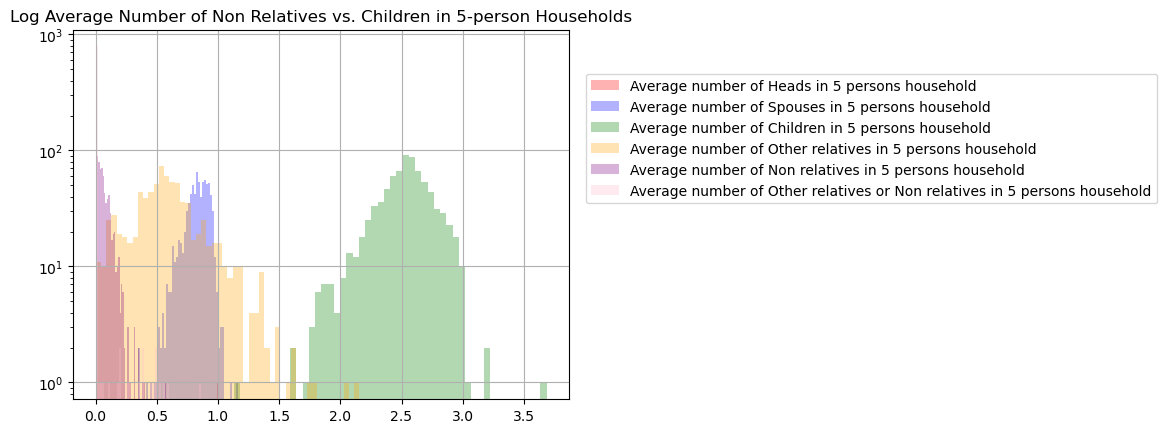

In [58]:
# Avg number of non relatives in 5 person households

colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink']

for i, code in enumerate(five_person_hr):
        df[code].hist(bins=50, label=code_dict.loc[code_dict['Code']==code, 'Description'].values[0], color=colors[i], alpha = 0.3)

        plt.title('Log Average Number of Non Relatives vs. Children in 5-person Households')
        plt.legend()
        
plt.yscale('log')
plt.legend(loc='upper right', bbox_to_anchor=(2.2,0.9))
plt.show()


### Compositional Data

CoResidence data contained 10 simplex groupings of columns, consisting of a total of 71 columns. The simplex columns constitute 42% of 169 "core feature" columns, i.e. features pertaining to household configuration. Thus, excluding data from the simplex groupings in order to simplify analysis would have resulted in substantial data loss.

In this section, I applied "Central Log Ratio" transformation to the simplex columns, to translate the ratio between them into values that make sense within Euclidean space, in preparation for modelling. I also dropped the residual column from each grouping, to prevent collinearity introduced by the constant-sum constraint, which CLR does not resolve on its own.

As an operational note, CoResidence contained a number of 'inf' values, which had to be corrected prior to CLR transformation.

In [59]:
# Table contains infinite values. Testing .applymap() method to look for inf values
# Something I did to 218 and 219 created infinite values

inf_mask = df.applymap(lambda x: x==np.inf or x==-np.inf)
inf_mask_filter = df.loc[inf_mask.any(axis=1),inf_mask.any(axis=0)]
inf_mask_filter

,HT16,HT18,HT31
79,3.594203,inf,inf
325,inf,2.984809,2.984809
547,3.169451,inf,inf
569,4.687744,inf,inf
758,2.451415,inf,inf


In [60]:
# Fill inf values with column mean

inf_index = inf_mask_filter.index

for col in inf_mask_filter.columns:
    for index in inf_index:
        if np.isinf(df.loc[index, col]):
            #print(f"Column {col}, Row {index} is inf")
            replace_num_col = df[col].replace([np.inf, -np.inf], np.nan).dropna()
            replace_col_mean = np.mean(replace_num_col)
            #print(col, replace_col_mean)
            df.loc[index, col] = np.mean(replace_num_col)


In [61]:
# Side-by-side comparison of before and after to check that find and replace worked
pd.concat([inf_mask_filter, df.loc[inf_mask.any(axis=1), inf_mask.any(axis=0)]], axis=1)

,HT16,HT18,HT31,HT16,HT18,HT31
79,3.594203,inf,inf,3.594203,1.925730,1.925730
325,inf,2.984809,2.984809,2.835289,2.984809,2.984809
547,3.169451,inf,inf,3.169451,1.925730,1.925730
569,4.687744,inf,inf,4.687744,1.925730,1.925730
758,2.451415,inf,inf,2.451415,1.925730,1.925730


In [62]:
# add-to-one groups with sequential columns, able to be expressed in (start, stop) tuple

simplex_groups = [('HH01','HH02'), 
                     ('HH03','HH13'), 
                     ('HH14','HH24'), 
                     ('HH25','HH30'), 
                     ('HH31','HH36'), 
                     ('HS01','HS11'),
                     ('HT01','HT09'), 
                     ('HT10','HT18'),
                     ('HT20','HT25')]

#('HS01_copy', 'HS12':'HS14'), cannot be represented in (start:stop) syntax, to be normalized manually

In [63]:
# count how many columns affected

sum(len(df.loc[:, start:end].columns) for start, end in simplex_groups)/len(df.columns.str.startswith('H'))

0.42011834319526625

In [64]:
# define formula for Centered Log Ratio

def clr_transform(df_simplex):
    """
    Transforms simplex features into Euclidean logic 
    Drops the rightmost column from the simplex to correct constant-sum constraint
    
    """ 
    
    if (df_simplex == 0).any().any():
        print("Converting zeros to 1e-15")
        
    df_simplex = df_simplex.replace(0, 1e-15)
                
    log_df = np.log(df_simplex)
    
    geometric_mean_denominator = log_df.mean(axis=1)
    
    clr_df = log_df.sub(geometric_mean_denominator, axis=0)
    
    clr_df = clr_df.drop(columns=clr_df.columns[-1])
    
    return clr_df
        

In [65]:
# check shape before dropping residual simplex columns
df.shape

(809, 169)

In [66]:
# apply CLR transform and column dropping, store residual columns for reference
residual_cols_dropped = []
clr_simplex_groups = []

for start, end in simplex_groups:
    df_simplex = df.loc[:, start:end]
    
    residual_col = df_simplex.columns[-1]
    residual_cols_dropped.append(residual_col)
    clr_simplex_groups.append((df_simplex.columns[0], df_simplex.columns[-2]))
    
    clr_df = clr_transform(df_simplex)
    df.loc[:, clr_df.columns] = clr_df

    df = df.drop(columns=residual_col)

Converting zeros to 1e-15
Converting zeros to 1e-15
Converting zeros to 1e-15
Converting zeros to 1e-15
Converting zeros to 1e-15
Converting zeros to 1e-15
Converting zeros to 1e-15


In [67]:
pd.DataFrame(zip(simplex_groups, clr_simplex_groups), columns=['Before CLR', 'After CLR'])

,Before CLR,After CLR
0,"(HH01, HH02)","(HH01, HH01)"
1,"(HH03, HH13)","(HH03, HH12)"
2,"(HH14, HH24)","(HH14, HH23)"
3,"(HH25, HH30)","(HH25, HH29)"
4,"(HH31, HH36)","(HH31, HH35)"
5,"(HS01, HS11)","(HS01, HS10)"
6,"(HT01, HT09)","(HT01, HT08)"
7,"(HT10, HT18)","(HT10, HT17)"
8,"(HT20, HT25)","(HT20, HT24)"


In [68]:
# check shape after dropping simplex residual columns
df.shape

(809, 160)

In [69]:
# inspect manual simplex to be clr transformed manually, verify simplex status
manual_simplex_cols = ['HS01_copy', 'HS12', 'HS13', 'HS14']
np.isclose(df[manual_simplex_cols].sum(axis=1), 1).all()

True

In [70]:
#('HS01_copy', 'HS12', 'HS14'), cannot be represented in (start:stop) syntax, to be normalized manually

manual_simplex_cols = ['HS01_copy', 'HS12', 'HS13', 'HS14']

df.loc[:, manual_simplex_cols] = (
    np.log(df.loc[:, manual_simplex_cols])
    .sub(
        np.log(df.loc[:, manual_simplex_cols]).mean(axis=1), axis=0)
)

In [71]:
# define all_clr_columns

clr_simplex_groups.append(('HS12','HS14')) #('HS01_copy', 'HS12', 'HS14') manual simplex CLR, 'HSO1_copy dropped'

In [72]:
# drop HS01_copy used to complete simplex
df = df.drop('HS01_copy', axis=1)

In [73]:
# extract all columns to supply values for all_clr_columns variable used in tscv_loop()

all_clr_columns = []

for start, end in clr_simplex_groups:
    clr_transformed_columns = df.loc[:, start:end].columns
    all_clr_columns.extend(clr_transformed_columns)

In [74]:
# verify how many
len(all_clr_columns)

65

In [75]:
# check for duplicates again

df.columns[df.T.duplicated(keep=False)]

Index(['HR01', 'HT26'], dtype='object')

In [76]:
# drop 'HT26' "Average size of unipersonal households based on relationship to head"

df = df.drop(columns='HT26')

### Non-Core Features (S, P, D)

In [77]:
# Create a not nulls mask to inspect nulls in non-core features
d_s_p_cols = df.loc[:,df.columns.str.startswith(('D', 'S', 'P'))]
d_s_p_nulls = d_s_p_cols[d_s_p_cols.isnull().any(axis=1)]
not_nulls_mask = d_s_p_nulls.notnull()

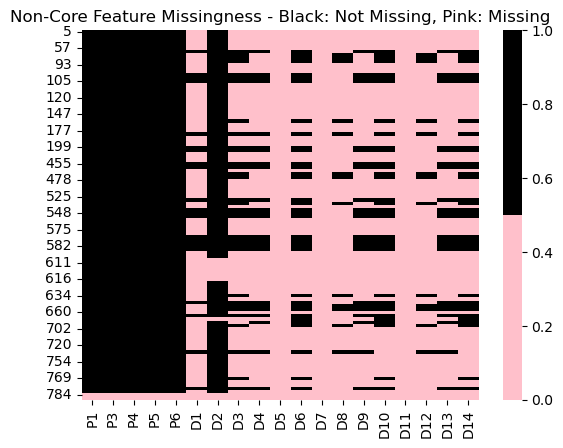

In [78]:
# Inspect columns where supplemental features have NaN values

sns.heatmap(not_nulls_mask, cmap=['Pink', 'Black'])
plt.title("Non-Core Feature Missingness - Black: Not Missing, Pink: Missing")
plt.show()

# There does not seem to be a pattern regarding null values in D columns vs. P or S columns
# Potentially need to import D values from elsewhere. All S columns will be dropped later

In [79]:
# Fetch descriptions for "C" and "D" columns
code_dict.loc[code_dict['Code'].str.startswith(('C', 'D', 'S')), ['Code', 'Description']]

,Code,Description
151,C0,Country ISO nomenclature 2 digits
152,C1,Country ISO nomenclature 3 digits
153,C2,Country
154,C3,Continent
155,C4,Sub continent
156,C5,Region
157,C6,Region Name
158,S1,Sample identification
159,S2,Data source
160,S3,Sample region identification


In [80]:
# Inspect dataframe where D columns have null values

df.loc[(df.loc[:,df.columns.str.startswith('D')].isnull().any(axis=1)),:]

# Potential to fill these columns after merge with UN data


,C1,C2,T1,HS01,HS02,HS03,HS04,HS05,HS06,HS07,...,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14
5,ARG,Argentina,1970,0.726435,1.301002,1.409713,1.419123,0.992081,0.379850,-0.091584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ARG,Argentina,1980,0.527031,1.013130,1.063950,1.154643,0.833520,0.397436,0.012880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,AUT,Austria,1971,2.027616,2.050577,1.653990,1.426913,0.884864,0.208032,-0.406670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,AUT,Austria,1981,2.405445,2.315177,1.909008,1.760387,1.017622,0.245800,-0.489680,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,BEL,Belgium,1985,2.443247,3.011889,2.638522,2.505617,1.567032,0.530901,-0.694561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,VEN,Venezuela,1981,-0.170802,0.168734,0.484229,0.657912,0.526365,0.356006,0.073219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773,VEN,Venezuela,1990,0.027084,0.295228,0.639378,0.823321,0.703239,0.409007,0.054838,...,NaN,16424.636,NaN,NaN,5.22118,10041.61263,NaN,NaN,5.46128,22775.1836
775,VNM,Vietnam,1989,-0.441569,0.337706,0.815740,1.030912,0.903773,0.655681,0.226777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
784,XXK,Kosovo,2014,-0.756203,0.083875,0.206477,0.883003,1.010054,0.834353,0.405148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
# Check how many values are missing per column. Sort by how many values are missing. Rename results of query.

major_missing_values = (
    pd.DataFrame(
        df
        .isnull().sum().sort_values(ascending=False)
        .reset_index()
        .head(15)
        .rename(columns={'index':'Code', 0:'Num Missing'})
    )
)

major_missing_values

# First merge attempt failed due to data type mismatch. Changing the datatype of the query to match merge table
#major_missing_values['Code'] = major_missing_values['Code'].astype('object')

,Code,Num Missing
0,D7,112
1,D5,112
2,D11,112
3,D12,99
4,D8,99
5,D1,90
6,D13,88
7,D9,88
8,D4,87
9,D3,78


In [82]:
# Merge column Code names with Descriptions. Inspect the descriptive names of columns with substantial missing values
mmv_df = major_missing_values.merge(code_dict[['Code','Description']], on='Code', how='left')
mmv_df

# I want to keep these columns, as they are informative. I will deal with missing values by dropping rows instead
# Or imputing values using UN data

,Code,Num Missing,Description
0,D7,112,Human development index female
1,D5,112,Gross Domestic income
2,D11,112,Human development index male
3,D12,99,Expected years of schooling male
4,D8,99,Expected years of schooling female
5,D1,90,Human development index
6,D13,88,Mean years of schooling male
7,D9,88,Mean years of schooling female
8,D4,87,Mean years of schooling
9,D3,78,Expected years of schooling


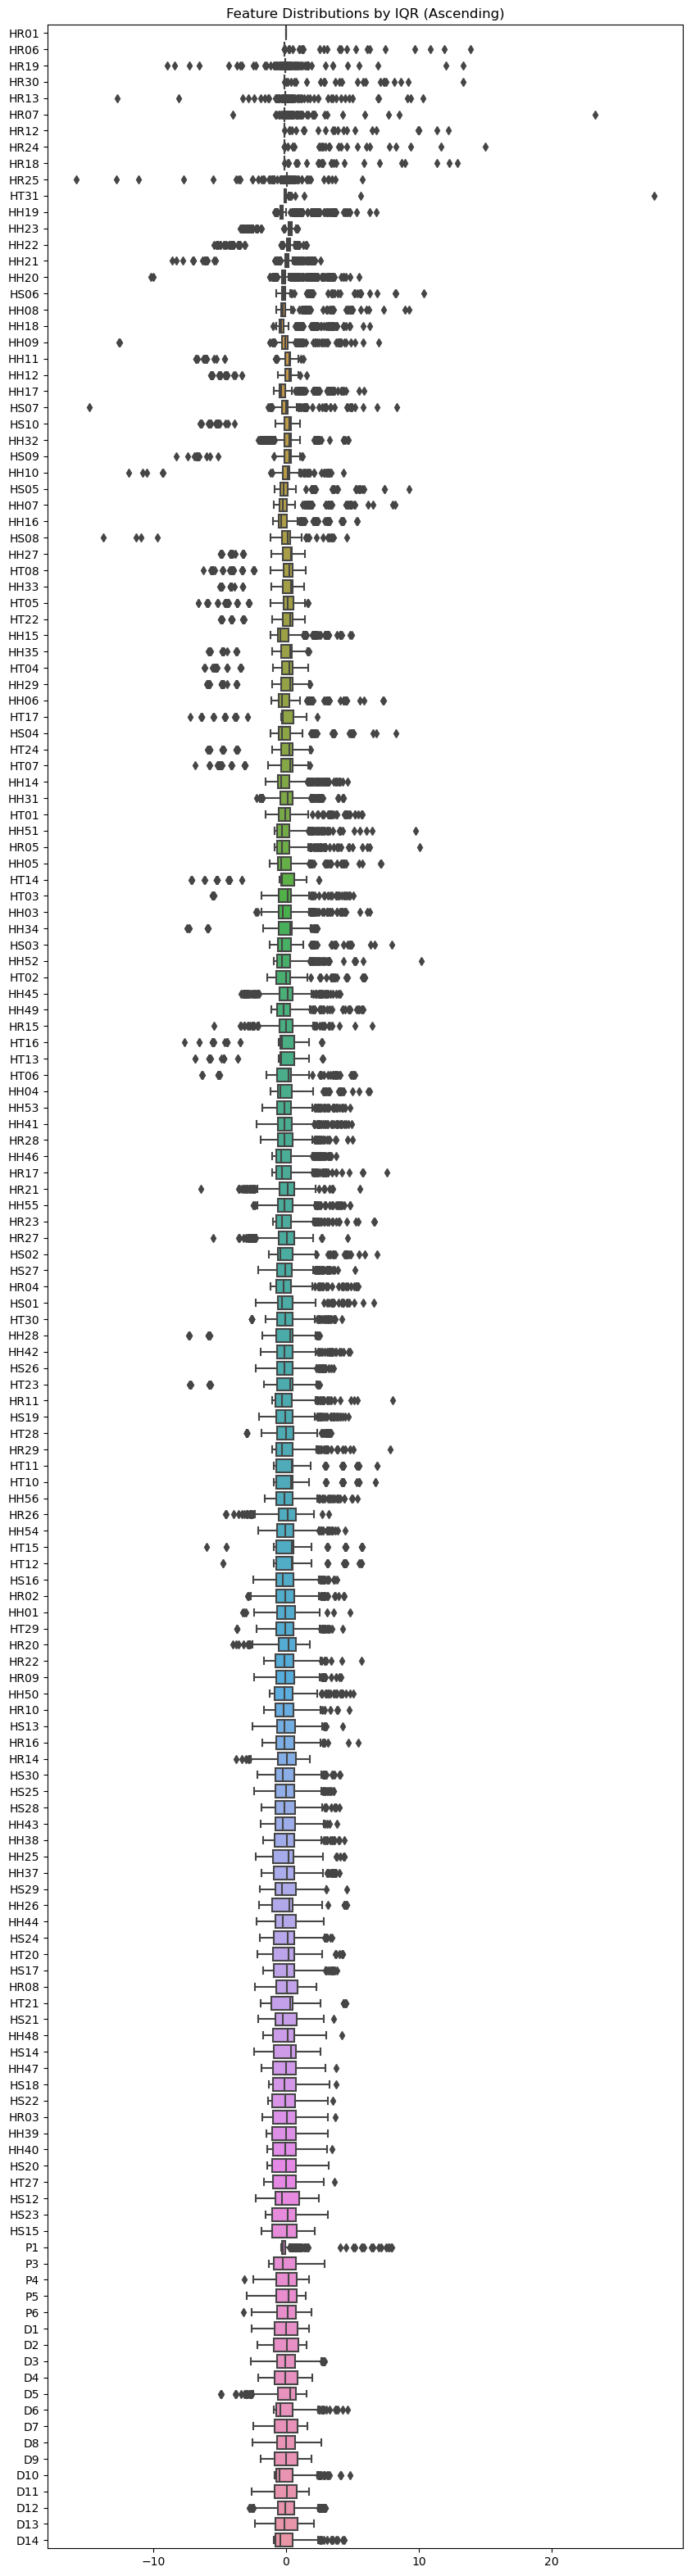

In [83]:
# check for outliers, distributions, using scaled data in box plot

scaler = StandardScaler()
scaled = scaler.fit_transform(df.select_dtypes(include=['number']))
df_scaled = pd.DataFrame(scaled, columns=df.select_dtypes(include=['number']).columns, index=df.index)
iqr_vals = df_scaled.apply(lambda col: np.percentile(col, 75) - np.percentile(col, 25))
iqr_vals = iqr_vals.drop('T1').sort_values(ascending=True)
iqr_vals_sorting_index = iqr_vals.index

plt.figure(figsize=(10,40))
sns.boxplot(df_scaled[iqr_vals_sorting_index], orient='h')
plt.title("Feature Distributions by IQR (Ascending)")
plt.show()

In [84]:
# observe values via .describe()

describe_df = df_scaled.describe().T
describe_df = describe_df.merge(code_dict[['Code', 'Description']], left_on=describe_df.index, right_on='Code')
describe_df['IQR'] = describe_df['75%'] - describe_df['25%']
describe_df = describe_df.sort_values(by='IQR', ascending=True)
describe_df
iqr_zero_df = describe_df[np.isclose(describe_df['IQR'], 0, atol=1e-3)]

iqr_zero_df

,count,mean,std,min,25%,50%,75%,max,Code,Description,IQR
30,809.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,HR01,Average number of heads in the household,0.0
36,809.0,2.840634e-14,1.000619,-4.013355,-0.105337,-0.105337,-0.105337,23.274015,HR07,Average number of Heads in 2 persons household,0.0
41,809.0,4.391488e-18,1.000619,-0.131171,-0.131171,-0.131171,-0.131171,12.251135,HR12,Average number of Other relative or Non relati...,0.0
42,809.0,4.781452e-14,1.000619,-12.694715,-0.079014,-0.079014,-0.079014,10.344547,HR13,Average number of Heads in 3 persons household,0.0
47,809.0,-8.782976e-18,1.000619,-0.130004,-0.130004,-0.130004,-0.130004,12.925818,HR18,Average number of Other relatives or Non relat...,0.0
48,809.0,4.907488e-14,1.000619,-8.929243,-0.020703,-0.020703,-0.020703,13.364777,HR19,Average number of Heads in 4 persons household,0.0
53,809.0,-3.952339e-17,1.000619,-0.132614,-0.132614,-0.132614,-0.132614,14.982355,HR24,Average number of Other Relatives or Non relat...,0.0
54,809.0,-2.865885e-14,1.000619,-15.753870,0.067188,0.067188,0.067188,5.754020,HR25,Average number of Heads in 5 persons household,0.0
59,809.0,1.317446e-17,1.000619,-0.139468,-0.139468,-0.139468,-0.139468,13.334333,HR30,Average number of Other relatives or Non relat...,0.0
35,809.0,3.952339e-17,1.000619,-0.126584,-0.126584,-0.126584,-0.126584,13.920813,HR06,Average number of other relatives and/or non r...,0.0


Number of columns with zero IQR: 10


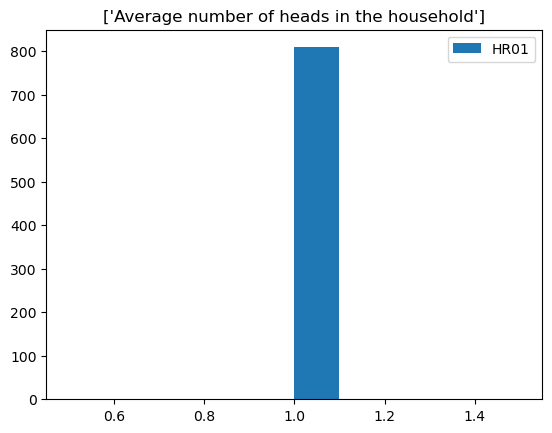

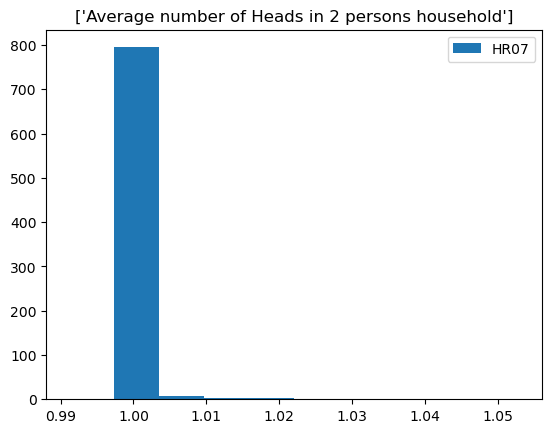

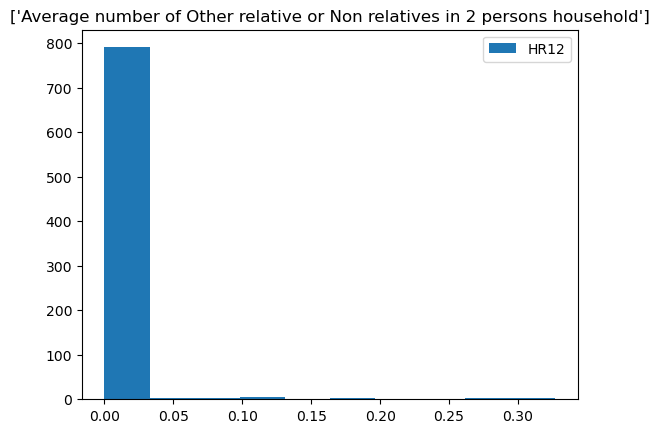

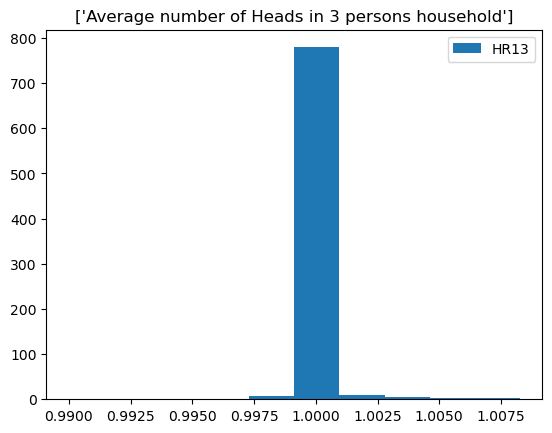

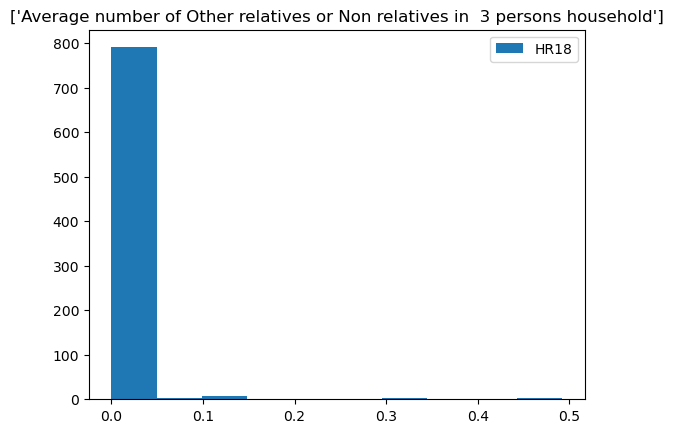

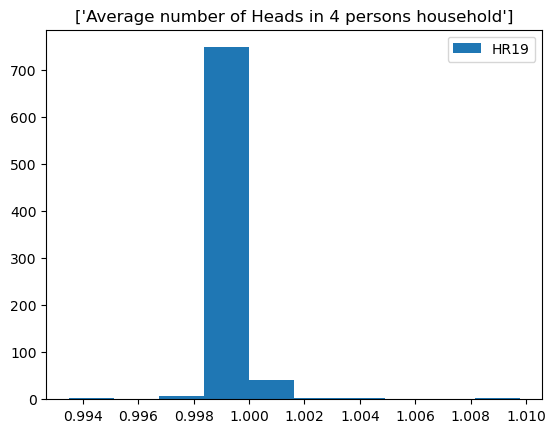

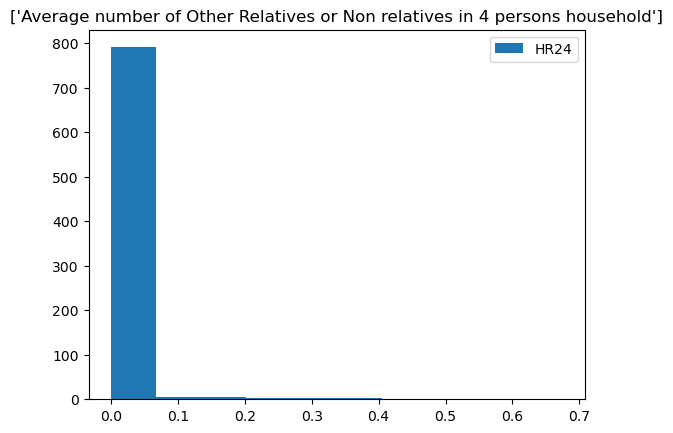

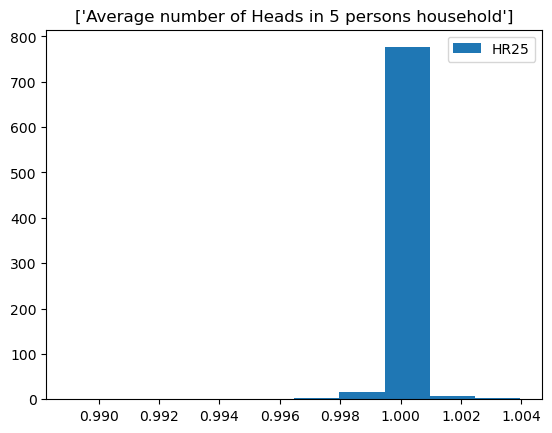

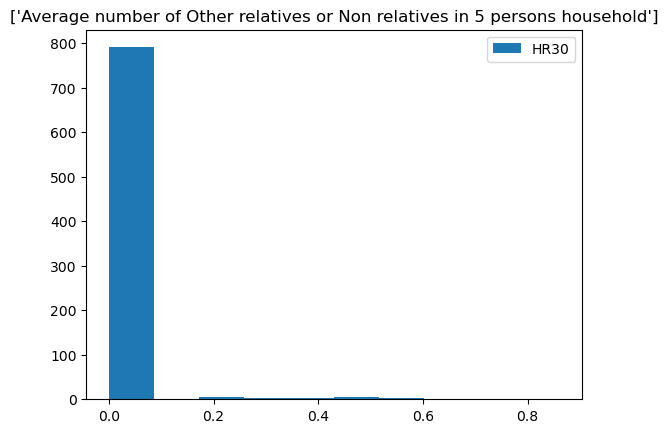

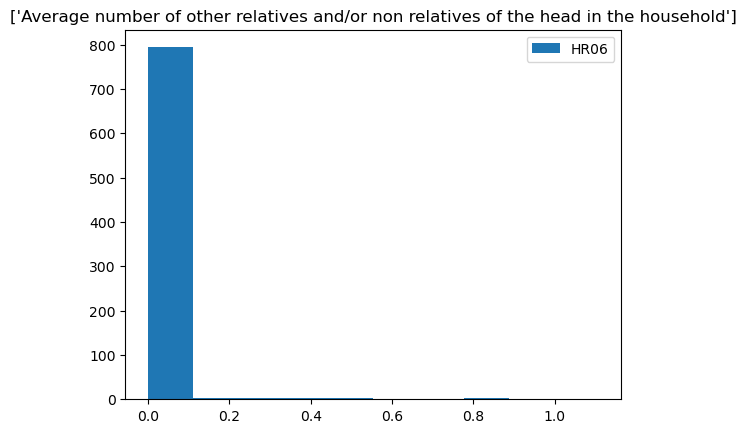

In [85]:
# inspect unscaled version of iqr zero columns
iqr_zero_cols = iqr_zero_df['Code'].values.tolist()

print(f"Number of columns with zero IQR: {len(iqr_zero_cols)}")
iqr_zero_df

for col in iqr_zero_cols:
    plt.hist(df[col], label=col)
    plt.title(f"{code_dict.loc[code_dict['Code']==col, 'Description'].values}")
    plt.legend()
    plt.show()

In [86]:
# drop zero IQR columns and revise groupings

print(f"The following columns are near-constant and must be dropped: {iqr_zero_cols}")

df = df.drop(iqr_zero_cols, axis=1)

The following columns are near-constant and must be dropped: ['HR01', 'HR07', 'HR12', 'HR13', 'HR18', 'HR19', 'HR24', 'HR25', 'HR30', 'HR06']


In [87]:
# get rid of duplicates

len(df[df.duplicated(subset=['C1', 'T1'], keep=False)])

24

In [88]:
# loop through duplicates, set duplicate rows to average of duplicate values

dupe_countries = df.loc[df.duplicated(subset=['C1', 'T1'], keep=False), 'C1'].unique().tolist()
dupe_rows = df[df.duplicated(subset=['C1', 'T1'], keep=False)]
dupe_rows_drop_index = df[df.duplicated(subset=['C1', 'T1'], keep='first')].index

for country in dupe_countries:
    dupe_subset = dupe_rows[dupe_rows['C1']==country]
    mean_vals = dupe_subset.loc[:, dupe_subset.columns.str.startswith(('H', 'P', 'D'))].mean(numeric_only=True)
    mean_vals_cols = mean_vals.index.tolist()
    df.loc[dupe_subset.index, mean_vals_cols] = mean_vals.values

In [89]:
# verify that values were updated 
#df.loc[dupe_rows.index]

df = df.drop(dupe_rows_drop_index)

### Changes Log (df)

List of changes to CoResidence table (df) thus far:

**Simplex Central Log Ratio Transform**
- 9 groups of columns consisted of compositional data
- These groups were subjected to a CLR transformation, then the residual column in each group was dropped
- 'HS01' served as part of two compositional groupings ('HS01':'HS11') and ('HS01', 'HS12':'HS14'). Thus a copy was created under 'HS01_copy' to perform CLR manually on the latter group, then 'HS01_copy' was dropped as a residual column.
- Resiual columns dropped are stored in residual_cols list: ['HH02', 'HH13', 'HH24', 'HH30', 'HH36', 'HS11', 'HT09', 'HT25']

**Unused Columns Dropped:**
- 'DB' column is a metadata tag (all rows == "National") (as opposed to Sub-National)
- 'C0' Country ISO nomenclature 2 digits (duplicated by other identifiers)
- 'C4' Sub continent
- 'T2' Census round
- 'T3' Most recent year
- 'T5' Five years
- 'T10' Decade
- 'S1' Sample identification
- 'S2' Data source
- 'P2' Population 2021 (duplicated by P1, which included 2021)

**Effective Duplicate Columns Dropped:**
- 'HT01':'HT18' - these columns were duplicates of other columns in the Household Typology sub-family
- 'HT26' - This column was a duplicate of 'HR01'

**Duplicate Rows**
- It became apparent that there are duplicated years in the original data. Duplicate rows are identified. Values are similar within countries and across rows. Thus rows were averaged within countries to retain information prior to dropping.

**Miscellaneous Changes**
- Some select null values were forward and back filled in rows 218, 219, 427, 428

- 36 rows within six proportional column groupings that fail to add-to-one were normalized (see normalize_groups variable for proportional column groupings)

- Null values in Household Typology columns (HT) replaced with zeros, as these are assumed to be sub-detectable averages

- Infinite "inf" values identified in rows 79, 325, 547, 569, 758 and replaced with column means

- Rows of country "Kosovo" to be deleted, as no development data is available

**Zero IQR Columns**
- 10 columns have been identified as having a zero interquartile range, (saved as a list under variable iqr_zero_cols): 'HR01', 'HR06', 'HR07', 'HR12', 'HR13', 'HR18', 'HR19', 'HR24', 'HR25', 'HR30'
- These ten columns fit into one of two categories: 
"Average number of heads of household" (values are 1), and residual categories for "Other" family or nonfamily household members (values tend to be near zero)
- Upon inspection of unscaled features, these are nearly constant, were dropped to avoid multicolinearity 


## Exploratory Feature Selection

Now that basic data validation and cleaning is complete (see Changes Log), we are ready to begin exploratory modelling.

The dataset is **feature-rich**, with over **150 features**. Which features to begin with? Which target to select? In this section, I create a working copy of table df called df_kbest (df.copy()) to handle preliminary feature selection.

I use **mutual info regression** as a method to investigate feature selection because it is both lightweight and agnostic to linearity. MI estimates the joint probability density between each feature and the target, then compares it to the product of their marginal probabilities. A large delta suggests the feature is informative to the target.

The intent of using MI at this stage is not to eliminate features, understand feature relationships deeply, or to select a model. MI evaluates feature-target relationships in a univariate fashion, which cannot capture feature interactions. Thus, it is not a substitute for a model. The intent is rather to examine features at a high level.

The provisional target variable chosen initially is column 'D1', "Human Development Index", (which is a weighted sum of various measures of human flourishing). MI helps identify the need for a new target, after data leakage from P and D features is revealed. More on this in the summary.

In [90]:
# Create a kbest copy of dataframe to run feature selection, drop null-containing rows
df_kbest = df.copy()

In [91]:
# Null values in "D" columns to be filled by backfill and forward fill

df_kbest.loc[:, df_kbest.columns.str.startswith('D')] = (
    df_kbest
    .groupby('C1', group_keys=False)
    [df_kbest.columns[df_kbest.columns.str.startswith('D')]]
    .transform(
    lambda x: x.ffill().bfill()
)
                                                        )

In [92]:
# drop remaining null values to prepare for feature selection and preliminary models
df_kbest = df_kbest.dropna()

In [93]:
print(f"Shape after dropping null values: {df_kbest.shape}")
print(f"Number of Countries after dropping null values: {df_kbest['C1'].nunique()}")
print(f"Year Range after dropping null values: Min {min(df_kbest['T1'])}, Max {max(df_kbest['T1'])}")

Shape after dropping null values: (784, 148)
Number of Countries after dropping null values: 151
Year Range after dropping null values: Min 1960, Max 2021


In [94]:
# Check for successful drop of null values
df_kbest.isnull().sum().sum()

0

In [95]:
# shuffle the data, then sort by year to prepare for time series modelling

df_kbest = df_kbest.sample(frac=1)
df_kbest = df_kbest.sort_values(by='T1')
df_kbest.head()

,C1,C2,T1,HS01,HS02,HS03,HS04,HS05,HS06,HS07,...,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14
759,USA,United States,1960,1.225375,1.971127,1.567538,1.486170,1.043308,0.410432,-0.391645,...,0.987,39472.302100,0.864349,15.840340,12.880528,29087.562270,0.875303,15.022860,13.087013,50300.030670
574,PAN,Panama,1960,0.504804,0.453582,0.544366,0.490336,0.428062,0.301470,0.100706,...,0.968,10345.730200,0.704162,12.898770,7.478220,5523.889400,0.727515,11.786000,7.337380,15092.778400
702,TGO,Togo,1960,0.850153,0.479240,0.328856,0.315611,0.086896,-0.116883,-0.296468,...,0.761,1751.716825,0.376757,7.061355,2.041250,1418.953019,0.495042,11.225550,5.140753,2087.301569
240,FRA,France,1962,1.641860,1.954261,1.600628,1.367784,0.912228,0.338334,-0.343027,...,0.941,11465.922010,0.701620,14.665449,10.249335,6909.730576,0.745988,14.192471,10.177794,15916.780660
627,PRY,Paraguay,1962,-0.121581,0.132549,0.309498,0.372351,0.367694,0.324773,0.109315,...,0.911,8212.272417,0.564696,8.537507,5.419169,5066.614897,0.619961,8.893613,5.950947,11287.375430


In [96]:
# Split the data with target == 'D1'which corresponds to column "Human Development Index"
# Drop 'C1' country code, 'C3' (continent), 'D1' (target), plus drop cols list

X = df_kbest.select_dtypes(include=['number']).drop(columns=['T1', 'D1'])

y = df_kbest['D1']

In [97]:
# run selector
mi_scores = mutual_info_regression(X, y, random_state=21)

In [98]:
# Create a dataframe to display selector metrics

metrics_df = pd.DataFrame(zip(X.columns, mi_scores), columns=['Code', 'MI Score'])

In [99]:
# Pull in 'Description' names of features from code_dict for features deemed important according to KBest selector
metrics_df = metrics_df.merge(code_dict[['Code','Description']], on='Code', how='left')


In [100]:
# Inspect columns deemed important by KBest selector

metrics_df.sort_values(by='MI Score', ascending=False).head(10)


,Code,MI Score,Description
140,D11,2.702346,Human development index male
136,D7,2.538982,Human development index female
135,D6,1.631673,Gross National Income per capita
139,D10,1.568809,Gross National Income per capita female
143,D14,1.521202,Gross National Income per capita male
132,D3,1.450038,Expected years of schooling
137,D8,1.426203,Expected years of schooling female
142,D13,1.339152,Mean years of schooling male
141,D12,1.327586,Expected years of schooling male
138,D9,1.322331,Mean years of schooling female


### Exploratory Feature Selection Summary

Choosing HDI (column 'D1') as a provisional target value creates indirect (extra-tabular) data leakage via the 'D' and 'P' columns, which are the constituent elements of the Human Development Index. In other words, the features identified as most salient to the model are the very same features used to generate HDI, which is unsuprising in hindsight. 

Two potential solutions: (1) Select a different target, or (2) Exclude composite index feature columns from the model. 

For the purposes of preliminary feature analysis, we will drop the 'D' and 'P' columns to observe only household configuration columns.

In [101]:
# Drop the D and P columns and try again, as the D columns the constituent indices of HDI

X = X.drop(X.columns[X.columns.str.startswith(('D','P'))], axis=1)


In [102]:
# Run selector again without d cols in X

mi_scores_2 = mutual_info_regression(X, y, random_state=21)


In [103]:
# metrics_df_2

metrics_df_2 = pd.DataFrame(zip(X.columns, mi_scores_2), columns=['Features', 'MI Score II'])

metrics_df_2 = metrics_df_2.merge(code_dict[['Code','Description']], left_on='Features', right_on='Code', how='left')

In [104]:
# Examine features without confounding D-features

with pd.option_context('display.max_colwidth', None):
    display(metrics_df_2.sort_values(by='MI Score II', ascending=False).head(10))

# Will be interesting to see if these remain the most salient features after imputation

,Features,MI Score II,Code,Description
18,HS20,0.797094,HS20,Average number of children in the household (aged < 18)
20,HS22,0.782122,HS22,Average number of 0-9 individuals in the household
108,HH39,0.776179,HH39,Average number of children in male-headed households
21,HS23,0.746833,HS23,Average number of 10-19 individuals in the household
16,HS18,0.728343,HS18,Average number of 0-4 children in the household
13,HS15,0.724366,HS15,Proportion of households with at least one person 0-4 years old
106,HH37,0.716010,HH37,Average household size of male-headed households
77,HH04,0.684009,HH04,Proportion of 2-persons households of male-headed households
15,HS17,0.675007,HS17,Average household size
1,HS02,0.662150,HS02,Proportion of 2-persons households


In [105]:
# train vs. test scores

results, trained_models = tscv_loop(X, y, 'exploratory', 3)
results

Standard Scaler applied for scale-sensitive models.
Running temp model Lasso() at alpha 0.0001
Running temp model Lasso() at alpha 0.001
Running temp model Lasso() at alpha 0.01
Running temp model Lasso() at alpha 1
Running temp model Lasso() at alpha 10
Running temp model Lasso() at alpha 100
Running optimal Lasso(alpha=0.01) alpha 0.01
Running temp model Ridge() at alpha0.01
Running temp model Ridge() at alpha0.1
Running temp model Ridge() at alpha1
Running temp model Ridge() at alpha10
Running temp model Ridge() at alpha50
Running temp model Ridge() at alpha100
Running temp model Ridge() at alpha1000
Running temp model Lasso() at alpha 0.0001
Running temp model Lasso() at alpha 0.001
Running temp model Lasso() at alpha 0.01
Running temp model Lasso() at alpha 1
Running temp model Lasso() at alpha 10
Running temp model Lasso() at alpha 100
Running optimal Lasso(alpha=0.001) alpha 0.001
Running temp model Ridge() at alpha0.01
Running temp model Ridge() at alpha0.1
Running temp model R

,Dataset,Fold,Linear Regression Train Score,Linear Regression Test Score,Lasso Alpha,Lasso Converged,Lasso Train Score,Lasso Test Score,Ridge Alpha,Matrix Cond,Ridge Train Score,Ridge Test Score,Random Forest Train Score,Random Forest Test Score,KNN Train Score,KNN Test Score,SVR Train Score,SVR Test Score
0,exploratory,1,0.860497,-31.394451,0.010,Yes,0.464315,0.682787,100,Severely ill,0.525017,0.687422,0.920257,0.655170,0.540488,0.456511,0.559278,0.554252
1,exploratory,2,0.802479,-125.153441,0.001,Yes,0.727858,0.885457,50,Severely ill,0.719906,0.883471,0.958928,0.883419,0.764749,0.700412,0.703216,0.732580
2,exploratory,3,0.834738,0.020385,0.001,Yes,0.798804,0.850059,100,Severely ill,0.789316,0.882142,0.969576,0.863173,0.820710,0.691761,0.765479,0.681248


In [275]:
trained_models

[{'Dataset': 'exploratory',
  'Fold': 1,
  'Features': ['HS01',
   'HS02',
   'HS03',
   'HS04',
   'HS05',
   'HS06',
   'HS07',
   'HS08',
   'HS09',
   'HS10',
   'HS12',
   'HS13',
   'HS14',
   'HS15',
   'HS16',
   'HS17',
   'HS18',
   'HS19',
   'HS20',
   'HS21',
   'HS22',
   'HS23',
   'HS24',
   'HS25',
   'HS26',
   'HS27',
   'HS28',
   'HS29',
   'HS30',
   'HR02',
   'HR03',
   'HR04',
   'HR05',
   'HR08',
   'HR09',
   'HR10',
   'HR11',
   'HR14',
   'HR15',
   'HR16',
   'HR17',
   'HR20',
   'HR21',
   'HR22',
   'HR23',
   'HR26',
   'HR27',
   'HR28',
   'HR29',
   'HT01',
   'HT02',
   'HT03',
   'HT04',
   'HT05',
   'HT06',
   'HT07',
   'HT08',
   'HT10',
   'HT11',
   'HT12',
   'HT13',
   'HT14',
   'HT15',
   'HT16',
   'HT17',
   'HT20',
   'HT21',
   'HT22',
   'HT23',
   'HT24',
   'HT27',
   'HT28',
   'HT29',
   'HT30',
   'HT31',
   'HH01',
   'HH03',
   'HH04',
   'HH05',
   'HH06',
   'HH07',
   'HH08',
   'HH09',
   'HH10',
   'HH11',
   'HH12',
 

In [106]:
# feature importances
exploratory_importances = pd.DataFrame(
    zip(trained_models[2]['Features'], trained_models[2]['Random Forest Importances']),
    columns=['Features', 'RF Importances'])
        
top_ten = (
    exploratory_importances
    .sort_values(by='RF Importances', ascending=False)
    .merge(code_dict[['Code', 'Description']], left_on='Features', right_on='Code', how='left')
)

with pd.option_context('display.max_colwidth', None):
    display(top_ten.head(10))

,Features,RF Importances,Code,Description
0,HS23,0.132567,HS23,Average number of 10-19 individuals in the household
1,HH39,0.125630,HH39,Average number of children in male-headed households
2,HS20,0.087569,HS20,Average number of children in the household (aged < 18)
3,HS22,0.081777,HS22,Average number of 0-9 individuals in the household
4,HS15,0.062435,HS15,Proportion of households with at least one person 0-4 years old
5,HS18,0.054900,HS18,Average number of 0-4 children in the household
6,HT30,0.035399,HT30,Average size of other non family households based on relationship to head
7,HR10,0.029902,HR10,Average number of Other relatives in 2 persons household
8,HH40,0.022956,HH40,Average number of children in female-headed households
9,HS02,0.021262,HS02,Proportion of 2-persons households


### Core Table Validation and Exploratory Model Summary

Initial feature selection using MI (mutual information regression) showed indirect data leakage from 'P' and 'D' columns (population and development information), into the target column, 'HDI' (Human Development Index). To assess non-leaky relationships, these features were temporarily excluded from the analysis.

Even without demographic data, importances of the Random Forest model showed meaningful relationships between HDI and various household configurations. The number of children in the household appears especially salient in the "Top 10" features, which "rings true" intuitively. 

That said, the problem of indirect data leakage is serious and needs to be addressed in order to continue this analysis. One solution for leakage would be to drop the leaky features from the data. However, dropping the features wholesale would constitute a loss of valuable information.

In order to select a target that is independent of, and free from, data leakage, while preserving population and development data, I import a new target: Gini Index.

## Table 2: Gini Index

In the previous section, I conducted preliminary feature selection using a mutual info regression, which revealed that my original choice for a target variable, Human Development Index ('D1') was subject to data leakage via the index's consituent indices ('P' and 'D' columns). To avoid information loss, I select a new target variable. 

**Why Gini Index?**
- Data Independence: Methodology of generating the index does not rely on the leaky features at all.
- Availability: Gini data is readily available and free.
- Interpretability: Serves as a good proxy of human flourishing, which is the qualitative goal of this study. 
- Robustness: Gini Index provides an indication of whether the "happiness" of a populace is typical or atypical.

**Challenges Introduced with Gini**

- While Gini data is available for similar year ranges as CoResidence data,  not every year in the Gini range matches the years represented in the CoResidence range. Thus it was necessary to conduct an outer merge. This created data sparsity.

Gini Index table is horizontal (266, 69) consists of:
- 266 countries (1 row per country)
- 69 columns consist of the 64 years in the range, 1960-2024, as well as 'Country Name', 'Country Code', and two columns that are uninformative to our purposes.
- Table was melted into long format. New shape is (17,024, 4)
- The Gini table is sparse. Each country contains 65 'Year' values, but the vast majority of rows in the Gini table are blank. Only 2,108 values out of 17,024 are not null. 98 countries (37%) have no Gini Index values at all.

Changes made to merged table before merge:
- Dropped: 'Indicator Name' (all values = 'Gini index), 
- Dropped: 'Indicator Code' (all values = 'SI.POV.GINI')
- Dropped: 'Unnamed: 68' (all values NaN)
- Reshaped: Wide shape (266, 69) is melted into vertical shape (17024, 4) with 64 * 266 rows (64 year-rows per country).


In [107]:
# Read in gini index dataset for new target selection

file_path = './API_SI.POV.GINI_DS2_en_csv_v2_3401539/API_SI.POV.GINI_DS2_en_csv_v2_3401539.csv'
gini_df = pd.read_csv(file_path,
                     skiprows=3)


In [108]:
# Wide format data must be melted on 'Year'. 
# Drop columns which are not needed and will complicate melt.
gini_df = gini_df.drop(['Indicator Name', 'Indicator Code', 'Unnamed: 68'], axis=1)

In [109]:
# Melt into long format with Gini values in Year variable
gini_df = pd.melt(gini_df, id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='Gini')


In [110]:
# Inspect post-melt table
gini_df.loc[gini_df['Gini'].notnull()].head()
print(gini_df.shape)

(17024, 4)


In [111]:
# How many countries have all null Gini values

all_null_gini = gini_df.groupby('Country Code')['Gini'].apply(lambda x: x.isnull().all())
all_null_gini[all_null_gini]

print(f"Percentage of countries with no Gini values: {round(len(all_null_gini[all_null_gini])/gini_df['Country Code'].nunique()*100, 2)}%")



Percentage of countries with no Gini values: 36.84%


In [112]:
# Assess CoResidence column candidates for merge join condition 'C1' (Country Code) vs. 'C2' (Country Name)

print(f"Country Code in CoResidence but not in Gini:"
      f"{[value for value in df['C1'].unique() if value not in gini_df['Country Code'].unique()]}")

print(f"Country Code in Gini but not in CoResidence:"
     f"{[value for value in gini_df['Country Code'].unique() if value not in df['C1'].unique()]}")
      
# XXK and XKX are 'Kosovo' and names will be standardized

Country Code in CoResidence but not in Gini:['XXK']
Country Code in Gini but not in CoResidence:['ABW', 'AFE', 'AFW', 'AND', 'ARB', 'ARE', 'ASM', 'ATG', 'BHR', 'BHS', 'BMU', 'BRB', 'BRN', 'CEB', 'CHI', 'CPV', 'CSS', 'CUW', 'CYM', 'DMA', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS', 'EMU', 'ERI', 'EUU', 'FCS', 'FRO', 'FSM', 'GIB', 'GNQ', 'GRD', 'GRL', 'GUM', 'HIC', 'HKG', 'HPC', 'IBD', 'IBT', 'IDA', 'IDB', 'IDX', 'IMN', 'INX', 'ISL', 'JPN', 'KIR', 'KNA', 'KWT', 'LAC', 'LBN', 'LBY', 'LCN', 'LDC', 'LIC', 'LIE', 'LKA', 'LMC', 'LMY', 'LTE', 'MAC', 'MAF', 'MCO', 'MEA', 'MHL', 'MIC', 'MLT', 'MNA', 'MNP', 'NAC', 'NCL', 'NOR', 'NRU', 'NZL', 'OED', 'OMN', 'OSS', 'PLW', 'PRE', 'PRK', 'PSS', 'PST', 'PYF', 'SAS', 'SAU', 'SGP', 'SLB', 'SMR', 'SSA', 'SSF', 'SST', 'SXM', 'SYC', 'TCA', 'TEA', 'TEC', 'TLA', 'TMN', 'TON', 'TSA', 'TSS', 'UMC', 'VCT', 'VGB', 'VIR', 'VUT', 'WLD', 'XKX']


In [113]:
# Examine country names in CoResidence (df['C2']) but not in Gini (gini_df['Country Name'])

mismatched_country_names = [value for value in df['C2'].unique() if value not in gini_df['Country Name'].unique()]
mismatched_country_names = df.loc[df['C2'].isin(mismatched_country_names),'C1': 'C2']
print(f'Following country names are in CoResidence but not Gini:')
print(mismatched_country_names.value_counts())
mismatched_country_names.nunique()

Following country names are in CoResidence but not Gini:
C1   C2                       
EGY  Egypt                        10
KOR  South Korea                   9
VNM  Vietnam                       8
TUR  Turkey                        8
CZE  Czech Republic                5
VEN  Venezuela                     4
LAO  Laos                          4
SVK  Slovakia                      4
PSE  Palestine                     3
COD  Congo Democratic Republic     2
RUS  Russia                        2
MKD  Macedonia                     2
COG  Congo                         2
LCA  Saint Lucia                   2
IRN  Iran                          2
GMB  Gambia                        2
YEM  Yemen                         2
SYR  Syria                         1
dtype: int64


C1    18
C2    18
dtype: int64

In [114]:
# Examine why country names were mismatched, while respective codes were not, with side-by side comparison of both tables
# Missing countries are correctly encoded, but have minor spelling differences

gini_df.loc[
    gini_df['Country Code'].isin(mismatched_country_names['C1']), 
    ['Country Name', 'Country Code']].merge(df[['C1', 'C2']], 
                                            right_on='C1', left_on='Country Code', how='left').drop_duplicates()


,Country Name,Country Code,C1,C2
0,"Congo, Dem. Rep.",COD,COD,Congo Democratic Republic
2,"Congo, Rep.",COG,COG,Congo
4,Czechia,CZE,CZE,Czech Republic
9,"Egypt, Arab Rep.",EGY,EGY,Egypt
19,"Gambia, The",GMB,GMB,Gambia
21,"Iran, Islamic Rep.",IRN,IRN,Iran
23,"Korea, Rep.",KOR,KOR,South Korea
32,Lao PDR,LAO,LAO,Laos
36,St. Lucia,LCA,LCA,Saint Lucia
38,North Macedonia,MKD,MKD,Macedonia


In [115]:
# Update 'Year' in gini_df to match data type of T1 (year in df) to facilitate merge

gini_df['Year'] = gini_df['Year'].astype('int64')

In [116]:
# Update Kosovo C1 value in left table to XKX to match right table to ensure proper merges with gini_df

df.loc[df['C1']=='XXK', 'C1'] ='XKX'

### MERGE 1
**Coresidence and Gini**

The CoResidence table (left table) has fewer years represented than the Gini table (right table), therefore a left merge on 'T1' ('Year') would eliminate valuable Gini data. Thus, data was outer merged, which created an extremely sparse resulting table.

Merge tables: df outer merged with gini_df (new target variable). 
- Shape of df before merge is (809, 178)
- Shape of df_merge1 (df after merge) is (17,036, 182)

Merge conditions were 'C1' (Country ISO nomenclature 3 digits) and 'T1' in the left table (CoResidence), which correspond to 'Country Code' and 'Year' in the right table (Gini Index). 

Kosovo country code was the only three digit ISO code to have any variation between tables, and was updated in CoResidence (left table) to prepare for the merge. Note that Kosovo is deleted later, in the Table 3 section, as development data was not available for that country.  

**At Least Two**


In preparation for interpolation and imputation techniques, countries with fewer than two Gini values and fewer than two rows of Core Feature ('H' columns) are identified and ultimately dropped.

In [117]:
# Merge df with gini df. C1= Country Code, C2 = Country Name, T1 = Year

print(f'Shape before merge is {df.shape}')

df_merge1 = df.merge(gini_df, left_on=['C1', 'T1'], right_on=['Country Code', 'Year'], how='outer')

print(f'Shape after merge is {df_merge1.shape}')

Shape before merge is (797, 148)
Shape after merge is (17024, 152)


In [118]:
# How many countries

merge1_country_total = df_merge1['Country Code'].nunique()

print(f"Total number of countries after merge: {merge1_country_total}")

Total number of countries after merge: 266


In [119]:
# Sort values. Inspect merge results
df_merge1 = df_merge1.sort_values(by=['Country Code', 'Year'])

In [120]:
# how many countries have no gini data at all in gini 

all_gini_nulls = gini_df.groupby('Country Code', group_keys=False)['Gini'].apply(lambda x: x.isnull().all())

print(f"Countries with no Gini data: {len(all_gini_nulls[all_gini_nulls])}, Total rows with no Gini data: {len(gini_df.loc[gini_df['Country Code'].isin(all_gini_nulls[all_gini_nulls].index),:])}")
print(f"Total rows in data: {len(gini_df)}")

Countries with no Gini data: 98, Total rows with no Gini data: 6272
Total rows in data: 17024


In [121]:
# drop rows of countries with fewer than two gini values (two values needed for interpolation)

two_fewer_gini = (
    df_merge1
    .groupby('Country Code', group_keys=False)['Gini']
    .apply(lambda group: group.notnull().sum()<2)
)

two_fewer_gini_countries = two_fewer_gini[two_fewer_gini].index
print(f"{len(two_fewer_gini_countries)} with fewer than two rows of Gini values")
two_fewer_gini_countries

# 108 countries have no Gini values at all, should be dropped

108 with fewer than two rows of Gini values


Index(['ABW', 'AFE', 'AFG', 'AFW', 'AND', 'ARB', 'ASM', 'ATG', 'BHR', 'BHS',
       ...
       'TLA', 'TMN', 'TSA', 'TSS', 'TUV', 'UMC', 'VCT', 'VGB', 'VIR', 'WLD'],
      dtype='object', name='Country Code', length=108)

In [122]:
# examine countries with fewer than two rows of core feature ('H') data

h_cols = df_merge1.columns.str.startswith('H')
two_fewer_hh = (
    df_merge1
    .groupby('Country Code', group_keys=False)
    .apply(lambda group: (
        group.loc[:, h_cols].notnull().sum()<2
    )
           .all())
)
    
two_fewer_hh_countries = two_fewer_hh[two_fewer_hh].index
two_fewer_hh_countries

Index(['ABW', 'AFE', 'AFG', 'AFW', 'AGO', 'AND', 'ARB', 'ARE', 'ASM', 'ATG',
       ...
       'TSS', 'TUN', 'TUV', 'UMC', 'VCT', 'VGB', 'VIR', 'VUT', 'WLD', 'WSM'],
      dtype='object', name='Country Code', length=133)

In [123]:
# union of two fewer hh and two fewer gini

two_fewer_countries = two_fewer_gini_countries.union(two_fewer_hh_countries)
len(two_fewer_countries)

139

In [124]:
# Create a drop row index corresponding to these countries

two_fewer_drop_index = []

for country in two_fewer_countries:
    country_index = df_merge1[df_merge1['Country Code']==country].index
    two_fewer_drop_index.extend(country_index)

In [125]:
len(two_fewer_drop_index)

8896

In [126]:
# drop two_fewer_drop_index as these changes should apply to all future merges

df_merge1 = df_merge1.drop(two_fewer_drop_index)

In [127]:
# define a small gini range as less than a decade of gini data

max_year = df_merge1[df_merge1['Gini'].notnull()].groupby('Country Code')['Year'].max()
min_year = df_merge1[df_merge1['Gini'].notnull()].groupby('Country Code')['Year'].min()

# check if indexes are equal before zipping
max_year.index.equals(min_year.index)

True

In [128]:
# calculate year range and inspect results
year_range = pd.DataFrame(
    zip(min_year.index, max_year.index, min_year, max_year, max_year-min_year), 
    columns=['Min Country','Max Country','Min', "Max", "Diff"]
)

small_gini_range = year_range[year_range['Diff']<8]
small_gini_range

,Min Country,Max Country,Min,Max,Diff
23,COG,COG,2005,2011,6
75,MMR,MMR,2015,2017,2
112,TTO,TTO,1988,1992,4
113,TUR,TUR,2017,2021,4


In [129]:
# construct small gini range countries drop index

small_gini_range_countries = small_gini_range['Min Country']

small_gini_range_drop_index = df_merge1[df_merge1['Country Code'].isin(small_gini_range_countries)].index

In [130]:
# drop small gini range

df_merge1 = df_merge1.drop(small_gini_range_drop_index)

In [131]:
# df_merge1 shape and values

df_merge1.shape
df_merge1['Country Code'].value_counts()

ALB    64
POL    64
PHL    64
PER    64
PAN    64
       ..
FJI    64
ETH    64
EST    64
ESP    64
ZWE    64
Name: Country Code, Length: 123, dtype: int64

In [132]:
# validate drops so far

original_country_total = df['C1'].nunique()

countries_dropped = list(two_fewer_gini_countries.union(two_fewer_hh_countries.union(small_gini_range_countries)))
num_countries_dropped = len(countries_dropped)
countries_remaining = df_merge1['Country Code'].unique()
num_countries_remaining = df_merge1['Country Code'].nunique()


assert (merge1_country_total == num_countries_dropped + num_countries_remaining), "Uh-oh lost track of a country!"
print(f"""Coresidence Country Total: {original_country_total},
    Post-Merge Country Total: {merge1_country_total},
      Countries Dropped: {num_countries_dropped}, 
      Countries Remaining: {num_countries_remaining}""")

Coresidence Country Total: 157,
    Post-Merge Country Total: 266,
      Countries Dropped: 143, 
      Countries Remaining: 123


In [133]:
# countries remaining versus original coresidence country list 
original_countries = list(df['C1'].unique())
dropped_cores_countries = [country for country in original_countries if country not in countries_remaining]
print(f"Number of countries dropped from CoResidence data: {len(dropped_cores_countries)}")
print(f"Name of countries dropped: {df.loc[df['C1'].isin(dropped_cores_countries), 'C2'].unique()}")

Number of countries dropped from CoResidence data: 34
Name of countries dropped: ['Afghanistan' 'Angola' 'Azerbaijan' 'Belize' 'Bhutan' 'Canada' 'Congo'
 'Cuba' 'Djibouti' 'Denmark' 'Finland' 'Georgia' 'Guyana' 'Haiti' 'Iraq'
 'Cambodia' 'Saint Lucia' 'Myanmar' 'Puerto Rico' 'Qatar' 'Sudan'
 'Somalia' 'South Sudan' 'Sao Tome and Principe' 'Suriname' 'Sweden'
 'Eswatini' 'Syria' 'Turkmenistan' 'Trinidad and Tobago' 'Tunisia'
 'Turkey' 'Tuvalu' 'Samoa']


In [134]:
# count values of < 2, < 3, < 4, < 5 

country_gini_counts = df_merge1[df_merge1['Gini'].notnull()]['Country Code'].value_counts()

count_dict = {
    'Two': 0, 'Three': 0, 'Four': 0, 'Five or more':0
}

for count in country_gini_counts:
        if count <= 2:
            count_dict['Two'] += 1
        elif count == 3: 
            count_dict['Three'] += 1
        elif count == 4:
            count_dict['Four'] += 1
        else:
            count_dict["Five or more"] += 1
            
gini_bin_counts = pd.Series(count_dict)
gini_bin_counts_normalized = round(gini_bin_counts/gini_bin_counts.sum(), 2)
gini_bins_df = pd.DataFrame(
    zip(gini_bin_counts, gini_bin_counts_normalized), 
    index=gini_bin_counts.index, 
    columns=['Countries', 'Percent']
)

gini_bins_df.loc['Total'] = gini_bins_df.sum()
gini_bins_df

,Countries,Percent
Two,3.0,0.02
Three,11.0,0.09
Four,5.0,0.04
Five or more,104.0,0.85
Total,123.0,1.00


In [135]:
df_merge1.shape

(7872, 152)

### Merge 1 Summary

Concluding the merge between the CoResidence and Gini Index tables, the dataframe **df_merge1** is created. Table df_merge1 is the most filtered version of the dataset. In other words, the rows in df_merge1 constitute the set of final rows to be included in this analysis. **Any future merges will branch off of df_merge1**, and will be named according to merge order.

Filtering decisions were made with interpolation and iterative imputation methods in mind. At a minimum, representing change requires at least two observations, a before and an after. Thus countries with **fewer than two rows of Gini data (target)** or **fewer than two rows of CoResidence core feature data** were dropped, to maintain bare minimum structure. Additionally, countries with a Gini timespan of fewer than 8 years were excluded; the rationale being that a span of 8+ years is long enough to represent meaningful change within a country.

**Shape and Sparsity**
- Shape after outer merge was (17,024, 143)
- Shape after filtering according to criteria is (7872, 143)
- Even after filtering, sparsity remains at 89%

As a result of this filtering criteria:
- Out of the original 157 countries in CoResidence, 34 were dropped, with 123 remaing. 
- More than half of 266 countries in the Gini dataset were dropped. (Many of these countries were merged into CoResidence in an outer merge, despite having no match in the original CoResidence data)


Increasing row-completeness thresholds to 5 or more Gini values would have resulted in an additional 15% of countries being dropped (see above table), for a total of 34% loss of countries from the CoResidence data (104 remaining out of 157).

In [136]:
# quick sparsity check
df_merge1.isnull().sum().sum()/df_merge1.size

0.8898193463842533

# Section III: Missing Values

In Section III we handle missing values created by the merge of CoResidence data with the Gini Index target.

Missing values are handled using three imputation methods, in order to mitigate bias introduced by reconstructing data:
1) Interpolation
2) Iterative Imputation
3) Matrix Decomposition

Gaps in the target must be imputed as well. Target imputation was conducted separately from feature imputation.

## Section III(a): Target Imputation

In some ways, the target variable is the most important variable in any dataset (in supervised learning). Patterns in its variance represent the benchmark in relation to which all other feature distributions are interpreted. 

Target imputation was necessary in this analysis, to retain core feature data, for years in which which no corresponding Gini values were available. In many cases, Gini data existed for nearby years, making imputation a viable approach for filling blanks.

My primary concern while imputing the target variable was data leakage. I strictly ensured that target values were not imputed based on features, whether directly or indirectly. A secondary concern was minimizing bias introduced by estimator assumptions. Specifically, I wanted to avoid forcing an artificial linear structure onto the target, which could bias downstream models.

That said, exploratory modeling on listwise-deleted data suggested strong linear structure in the data, even before introducing the Gini Index target. Therefore, I was comfortable using imputation methods that incorporate linear assumptions, as long as they were not locked into linear structure.

**Target Imputation Methods:**

1) K-Nearest Neighbors (KNN) Imputer
2) Truncated Singular Value Decomposition (SVD)

**KNN Imputation**

Strengths:
- KNN is flexible and does not impose a predefined functional form on the data.
- Since 85% of countries have at least five Gini values, KNN can capture both linear and nonlinear patterns for the majority of the data, where sufficient observations exist.


Limitations:
- KNN is local in nature and only imputes values between known observations, leaving edge cases unresolved. These remaining values required back and forward filling.
- KNN must be applied within each country to prevent unrelated countries from influencing one another’s values. It makes no sense to use a distance-based model to impute values in a given year for both France and Zimbabwe, for example.

**SVD Imputation**

Strengths:
- SVD captures global structure in the data by leveraging patterns across both time and countries.
- Unlike KNN, which I applied on the basis of temporal distances within each country, SVD simultaneously captures patterns across both dimensions (time and country) without necessarily intermixing unrelated data.
- Scaling was not necessary since Gini values already exist on a well-defined scale.

Limitations:
- Requires pivoting the data into a country-year format.
- Requires filling missing values with a nominal value (column means) before decomposition, which introduces bias.


By using both approaches, I aimed to balance localized pattern recognition (KNN) with global structure modeling (SVD) to generate a more robust imputed dataset. In modelling, I tested each dataset against both iterations of the imputed target.

**Sequence**


There were two possible points in the workflow of this analysis to conduct target imputation: **Before** or **after** trimming mostly blank rows. I chose to impute the target before trimming, while the full temporal structure of the data was still intact. This choice was based on the following considerations:
- KNN identifies nearest neighbors based on similarity, not temporal distance. Results of KNN imputation should thus be the same regardless of blank values.
- SVD theoretically is sensitive to blank values, as these must be filled prior to decomposition (with mean imputation, etc.), which can dampen the overall variance of the data. However, without including all years, it would have been impossible to pivot the data into a usable matrix. 

### SVD Imputation

In [137]:
df_target = df_merge1.copy()


In [138]:
gini_matrix = df_target.pivot(index='Country Code', columns='Year', values='Gini')

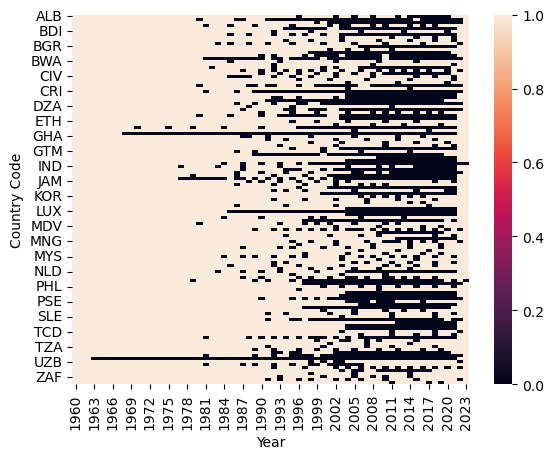

In [139]:
sns.heatmap(gini_matrix.isnull())
plt.show()

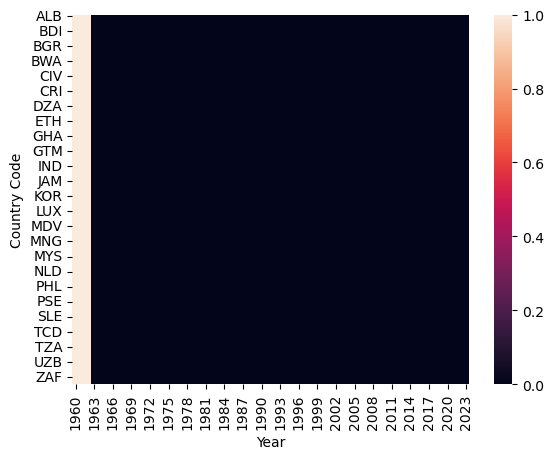

In [140]:
# fill null values

gini_matrix_filled = gini_matrix.fillna(gini_matrix.mean(axis=0))
sns.heatmap(gini_matrix_filled.isnull())

# drop years with no data

gini_matrix_filled = gini_matrix_filled.drop(columns=[1960, 1961, 1962])


In [141]:
# values already scaled, standard_scaler not needed, identify optimal n_components

svd_test = TruncatedSVD(min(gini_matrix_filled.shape)-1, random_state=21)
U = svd_test.fit_transform(gini_matrix_filled)

explained_variance_ratio = np.cumsum(svd_test.explained_variance_ratio_)
np.argmax(explained_variance_ratio > 0.95) +1

24

In [142]:
# perform svd with optimal components

svd_target = TruncatedSVD(n_components=24, random_state=21)
U = svd_target.fit_transform(gini_matrix_filled)
VT = svd_target.components_

gini_matrix_reconstructed = U @ VT
df_gini_reconstructed = pd.DataFrame(gini_matrix_reconstructed, 
                                     columns=gini_matrix_filled.columns, 
                                     index=gini_matrix_filled.index)

len(df_gini_reconstructed)

123

In [143]:
gini_reconstructed_mstr = df_gini_reconstructed.stack()
gini_reconstructed_mstr = gini_reconstructed_mstr.reset_index()
gini_reconstructed_mstr.columns = ['Country Code', 'Year', 'Gini_reconstructed']
gini_reconstructed_mstr.head()

,Country Code,Year,Gini_reconstructed
0,ALB,1963,37.762924
1,ALB,1964,38.265090
2,ALB,1965,37.662490
3,ALB,1966,37.963790
4,ALB,1967,37.059891


In [144]:
# pull data into df_merge1

df_merge1 = df_merge1.merge(gini_reconstructed_mstr, on=['Country Code', 'Year'], how='left')


In [145]:
# create a column that merges observed gini values with reconstructed gini values

df_merge1['Gini_recon_hybrid'] = df_merge1['Gini'].where(df_merge1['Gini'].notnull(), df_merge1['Gini_reconstructed'])

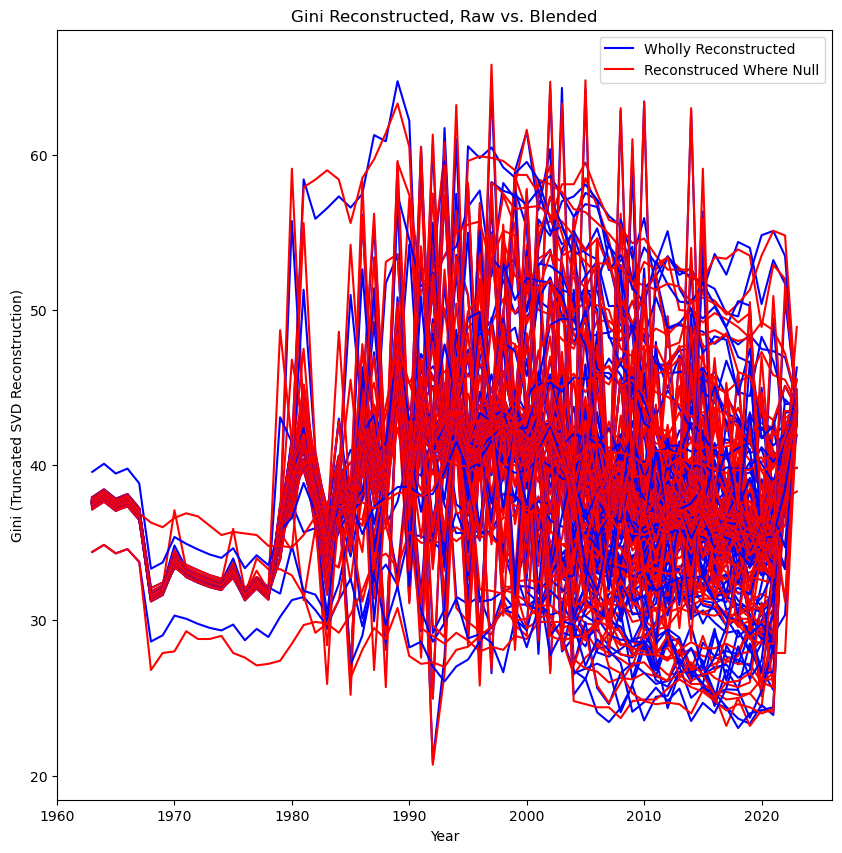

In [146]:
# plot reconstructed values
unique_countries = gini_reconstructed_mstr['Country Code'].unique().tolist()

plt.figure(figsize=(10, 10))

cmap = plt.get_cmap('coolwarm')
colors = cmap(np.linspace(0,1, len(unique_countries)))
    
for i, country in enumerate(unique_countries):
    
    x2 = df_merge1.loc[df_merge1['Country Code']==country, 'Year']
    y2 = df_merge1.loc[df_merge1['Country Code']==country, 'Gini_reconstructed']
    plt.plot(x2, y2, color='blue')
    

    x = df_merge1.loc[df_merge1['Country Code']==country, 'Year']
    y = df_merge1.loc[df_merge1['Country Code']==country, 'Gini_recon_hybrid']
    plt.plot(x, y, color='red')
    
plt.plot([], [], color='blue', label='Wholly Reconstructed')
plt.plot([], [], color='red', label='Reconstruced Where Null')
    

plt.xlabel("Year")
plt.ylabel("Gini (Truncated SVD Reconstruction)")
plt.title("Gini Reconstructed, Raw vs. Blended")
plt.legend()
plt.show()

### KNN Imputation

In [147]:
# knn impute gini values to prepare a y vector

unique_countries = df_merge1['Country Code'].unique().tolist()

country_blocks = []

for country in unique_countries:
    knn = KNNImputer(n_neighbors=2)
    country_block = df_merge1.loc[df_merge1['Country Code']==country, ['Gini']]
    country_block_imputed = knn.fit_transform(country_block)
    country_block_df = pd.DataFrame(country_block_imputed, columns=['Gini_knn'], index=country_block.index)
    country_blocks.append(country_block_df)

# concatenate each country block together
df_knn_gini = pd.concat(country_blocks)

# verify that indices match, prior to modelling
df_merge1.index.equals(df_knn_gini.index)


True

In [148]:
# add imputed target to dataframe
df_merge1['Gini_knn'] = df_knn_gini

In [149]:
df_merge1.head()

,C1,C2,T1,HS01,HS02,HS03,HS04,HS05,HS06,HS07,...,D12,D13,D14,Country Name,Country Code,Year,Gini,Gini_reconstructed,Gini_recon_hybrid,Gini_knn
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1960,NaN,NaN,NaN,31.008333
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1961,NaN,NaN,NaN,31.008333
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1962,NaN,NaN,NaN,31.008333
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1963,NaN,37.762924,37.762924,31.008333
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1964,NaN,38.265090,38.265090,31.008333


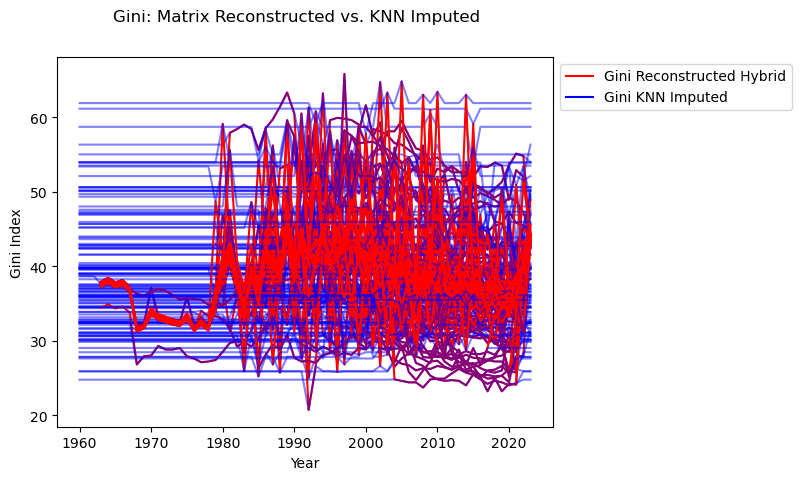

In [150]:
# compare gini recon hybrid to gini knn

fig, ax = plt.subplots()

for country in unique_countries:
    x = df_merge1.loc[df_merge1['Country Code']==country, 'Year']
    y1 = df_merge1.loc[df_merge1['Country Code']==country, 'Gini_recon_hybrid']
    y2 = df_merge1.loc[df_merge1['Country Code']==country, 'Gini_knn']

    ax.plot(x, y1, color='red')
    ax.plot(x, y2, color='blue', alpha=0.5)
    
plt.plot([], [], color='red', label="Gini Reconstructed Hybrid")
plt.plot([], [], color='blue',  label='Gini KNN Imputed')
    
plt.legend(bbox_to_anchor=(1, 1))
plt.suptitle("Gini: Matrix Reconstructed vs. KNN Imputed")
plt.xlabel('Year')
plt.ylabel('Gini Index')
plt.show()

## Section III(b): Features Imputation

### A: Spline Interpolation

Now that target values are imputed, it is time to deal with missing values in the feature columns. In this section, I use linear spline interpolation for features. 

Any method selected for handling missing values involves implicit assumptions and introduces unique biases. Linear spline essentially draws lines between points, but with curvature added. The assumption being that sociological data tends to move in curves, rather than spikes. 

I interpolated the inner swath of rows missing, bounded by the earliest and latest samples respectively (grouped by country). This effectively "colored in" the years of missing data between (at least two) recorded observations. 

Finally I deleted rows on the unknown edges of the data, where core feature data remained blank even after interpolation. 

In [151]:
# create working copy for baseline models
df_baseline = df_merge1.copy()

In [152]:
# check number of unique countries
print(f"Number of countries remaining after two-or-fewer countries dropped: {df_baseline['Country Code'].nunique()}")
print(f"Number of rows of remaining: {len(df_baseline)}")

Number of countries remaining after two-or-fewer countries dropped: 123
Number of rows of remaining: 7872


In [153]:
# examine merge results
df_baseline.head()

,C1,C2,T1,HS01,HS02,HS03,HS04,HS05,HS06,HS07,...,D12,D13,D14,Country Name,Country Code,Year,Gini,Gini_reconstructed,Gini_recon_hybrid,Gini_knn
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1960,NaN,NaN,NaN,31.008333
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1961,NaN,NaN,NaN,31.008333
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1962,NaN,NaN,NaN,31.008333
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1963,NaN,37.762924,37.762924,31.008333
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1964,NaN,38.265090,38.265090,31.008333


In [154]:
# prepare index for smooth interpolation 

df_baseline = df_baseline.sort_values(by=['Country Code', 'Year']).reset_index(drop=True)


In [155]:
# determine sparsity before interpolation

df_baseline.isna().sum().sum() / df_baseline.size

0.8732018751639129

In [156]:
# create a function that handles interpolation per group, column

def group_interpol(group, columns):
    for column in columns:
        # fill columns with dummy value, these will be dropped if they have no Gini or core feature data
        if group[column].notnull().sum() < 2:
            group[column] = group[column].fillna(group[column].mean())
            
        # interpolate missing values where possible. these will be retained if Gini or core feature data available
        elif group[column].notnull().sum() >= 2:
            group[column] = group[column].interpolate(method = 'slinear')
    return group


In [157]:
# Apply function group_interpol() to interpolate values on D, P, H columns

columns_list = df_baseline.loc[: , df_baseline.columns.str.startswith(('D', 'P', 'H'))].columns.to_list()

df_baseline = (
    df_baseline.groupby('Country Code', group_keys=False)
    .apply(lambda group: group_interpol(group, columns_list))

)

In [158]:
# Identify rows where core features remain blank after interpolation

columns_list = list(df_baseline.columns[df_baseline.columns.str.startswith('H')])

h_cols_null = (
    df_baseline.groupby('Country Code', group_keys=False)
    .apply(lambda group: group[columns_list].isnull().all(axis=1))
)

blank_rows = h_cols_null[h_cols_null].index
print(f"Number of totally blank rows to be dropped: {len(blank_rows)} out of {len(df_merge1)}")


Number of totally blank rows to be dropped: 4408 out of 7872


In [159]:
# drop rows that have no Gini_interpol values or H columns values identified above

df_baseline = df_baseline.drop(blank_rows)

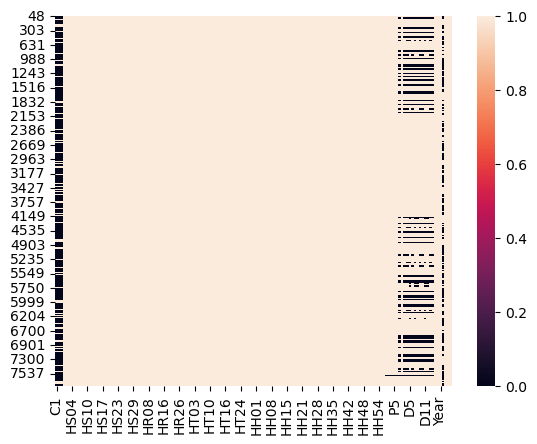

In [160]:
# Observe not null values 
df_baseline = df_baseline.sort_values(by=['Country Code','Year'])
sns.heatmap(df_baseline.notnull())
plt.show()

In [161]:
# sparsity after interpolation and dropping blank rows, before back/forwardfill

df_baseline.isnull().sum().sum()/df_baseline.size

0.03559003203456753

In [162]:
# back and forward fill remaining nulls

df_baseline = (
    df_baseline.groupby('Country Code', group_keys=False)
    .apply(lambda x: x.bfill().ffill())
)                                                              

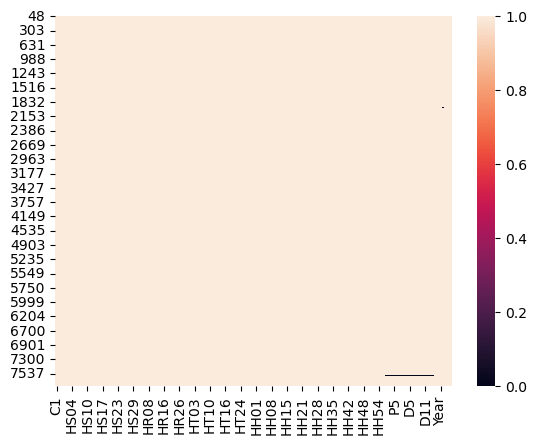

In [163]:
# check null values
sns.heatmap(df_baseline.notnull())
plt.show()

In [164]:
# Inspect null values remaining

nulls_mask = df_baseline.isnull()

df_baseline.loc[nulls_mask.any(axis=1), :]

,C1,C2,T1,HS01,HS02,HS03,HS04,HS05,HS06,HS07,...,D12,D13,D14,Country Name,Country Code,Year,Gini,Gini_reconstructed,Gini_recon_hybrid,Gini_knn
1972,DZA,Algeria,2012.0,-2.288125,0.061407,0.497159,0.870168,1.036355,0.919640,0.621399,...,14.093840,8.290142,18326.834400,Algeria,DZA,2012,NaN,36.636195,36.636195,34.366667
1973,DZA,Algeria,2019.0,-2.155217,0.101920,0.533402,0.905551,1.071478,0.936371,0.604282,...,14.075623,8.311324,18342.785114,Algeria,DZA,2013,NaN,34.798132,34.798132,34.366667
1974,DZA,Algeria,2019.0,-2.022310,0.142433,0.569645,0.940935,1.106601,0.953102,0.587165,...,14.057407,8.332505,18358.735829,Algeria,DZA,2014,NaN,37.148130,37.148130,34.366667
1975,DZA,Algeria,2019.0,-1.889402,0.182946,0.605887,0.976318,1.141724,0.969833,0.570047,...,14.039191,8.353686,18374.686543,Algeria,DZA,2015,NaN,36.515694,36.515694,34.366667
1976,DZA,Algeria,2019.0,-1.756495,0.223459,0.642130,1.011702,1.176847,0.986564,0.552930,...,14.020975,8.374868,18390.637257,Algeria,DZA,2016,NaN,36.256395,36.256395,34.366667
1977,DZA,Algeria,2019.0,-1.623587,0.263972,0.678373,1.047085,1.211970,1.003295,0.535813,...,14.002759,8.396049,18406.587971,Algeria,DZA,2017,NaN,34.478097,34.478097,34.366667
1978,DZA,Algeria,2019.0,-1.490680,0.304484,0.714616,1.082469,1.247093,1.020026,0.518695,...,13.984543,8.417230,18422.538686,Algeria,DZA,2018,NaN,35.452918,35.452918,34.366667
1979,DZA,Algeria,2019.0,-1.357773,0.344997,0.750858,1.117852,1.282216,1.036757,0.501578,...,13.966327,8.438412,18438.489400,Algeria,DZA,2019,NaN,35.216802,35.216802,34.366667
7606,XKX,Kosovo,2014.0,-0.756203,0.083875,0.206477,0.883003,1.010054,0.834353,0.405148,...,NaN,NaN,NaN,Kosovo,XKX,2014,27.3,28.222026,27.300000,27.300000
7607,XKX,Kosovo,2020.0,-0.732461,0.155142,0.285441,0.919671,1.041856,0.847177,0.399043,...,NaN,NaN,NaN,Kosovo,XKX,2015,26.5,26.399416,26.500000,26.500000


In [165]:
# fill all remaining null values with column mean

df_baseline = df_baseline.fillna(df_baseline.mean(numeric_only=True))


In [166]:
# observe any remaining null values

df_baseline.isnull().sum().sum()

0

#### Baseline Models

In [167]:
# Shuffle values to shuffle countries

df_baseline = df_baseline.sample(frac=1)

In [168]:
# Sort the values by year again (countries now shuffled) to prepare for tscv

df_baseline = df_baseline.sort_values(by='Year')

In [169]:
# Inspect results of time-ordered shuffle. Countries appear shuffled.
df_baseline.head(5)

,C1,C2,T1,HS01,HS02,HS03,HS04,HS05,HS06,HS07,...,D12,D13,D14,Country Name,Country Code,Year,Gini,Gini_reconstructed,Gini_recon_hybrid,Gini_knn
7296,USA,United States,1960.0,1.225375,1.971127,1.567538,1.486170,1.043308,0.410432,-0.391645,...,15.02286,13.087013,50300.030670,United States,USA,1960,37.6,39.566804,37.600000,38.655932
6784,TGO,Togo,1960.0,0.850153,0.479240,0.328856,0.315611,0.086896,-0.116883,-0.296468,...,11.22555,5.140753,2087.301569,Togo,TGO,1960,42.2,37.509877,37.509877,42.340000
5632,PAN,Panama,1960.0,0.504804,0.453582,0.544366,0.490336,0.428062,0.301470,0.100706,...,11.78600,7.337380,15092.778400,Panama,PAN,1960,48.7,37.864149,37.864149,53.372414
7297,USA,United States,1970.0,1.265476,1.989303,1.572868,1.487801,1.042820,0.415601,-0.366567,...,15.02286,13.087013,50300.030670,United States,USA,1961,37.6,39.566804,37.600000,38.655932
5633,PAN,Panama,1970.0,0.495946,0.454491,0.535101,0.489751,0.427724,0.300637,0.094848,...,11.78600,7.337380,15092.778400,Panama,PAN,1961,48.7,37.864149,37.864149,53.372414


In [170]:
# Drop the target to split the data

X = df_baseline.select_dtypes(include=['number']).drop(
    columns=['T1', 'Year', 'Gini', 'Gini_reconstructed', 'Gini_recon_hybrid', 'Gini_knn'], axis=1)
y_knn = df_baseline['Gini_knn']
y_svd = df_baseline['Gini_recon_hybrid']
y_bfill = df_baseline['Gini']

In [171]:
# baseline results

baseline_results, trained_models = tscv_loop(X, y_knn, 'baseline_knn', 3)
baseline_results, trained_models = tscv_loop(X, y_svd, 'baseline_svd', 3)
baseline_results, trained_models = tscv_loop(X, y_bfill, 'baseline_bfill', 3)

Standard Scaler applied for scale-sensitive models.
Running temp model Lasso() at alpha 0.0001
Running temp model Lasso() at alpha 0.001
Running temp model Lasso() at alpha 0.01
Running temp model Lasso() at alpha 1
Running temp model Lasso() at alpha 10
Running temp model Lasso() at alpha 100
Running optimal Lasso(alpha=1) alpha 1
Running temp model Ridge() at alpha0.01
Running temp model Ridge() at alpha0.1
Running temp model Ridge() at alpha1
Running temp model Ridge() at alpha10
Running temp model Ridge() at alpha50
Running temp model Ridge() at alpha100
Running temp model Ridge() at alpha1000
Running temp model Lasso() at alpha 0.0001
Running temp model Lasso() at alpha 0.001
Running temp model Lasso() at alpha 0.01
Running temp model Lasso() at alpha 1
Running temp model Lasso() at alpha 10
Running temp model Lasso() at alpha 100
Running optimal Lasso(alpha=0.01) alpha 0.01
Running temp model Ridge() at alpha0.01
Running temp model Ridge() at alpha0.1
Running temp model Ridge() a

In [172]:
# view results
baseline_results

,Dataset,Fold,Linear Regression Train Score,Linear Regression Test Score,Lasso Alpha,Lasso Converged,Lasso Train Score,Lasso Test Score,Ridge Alpha,Matrix Cond,Ridge Train Score,Ridge Test Score,Random Forest Train Score,Random Forest Test Score,KNN Train Score,KNN Test Score,SVR Train Score,SVR Test Score
0,exploratory,1,0.860497,-31.394451,0.010,Yes,0.464315,0.682787,100,Severely ill,0.525017,0.687422,0.920257,0.655170,0.540488,0.456511,0.559278,0.554252
1,exploratory,2,0.802479,-125.153441,0.001,Yes,0.727858,0.885457,50,Severely ill,0.719906,0.883471,0.958928,0.883419,0.764749,0.700412,0.703216,0.732580
2,exploratory,3,0.834738,0.020385,0.001,Yes,0.798804,0.850059,100,Severely ill,0.789316,0.882142,0.969576,0.863173,0.820710,0.691761,0.765479,0.681248
3,baseline_knn,1,0.977670,-63.862709,1.000,Yes,0.593371,0.464950,100,Severely ill,0.832522,0.571959,0.995183,0.631151,0.950978,0.498607,0.644855,0.450848
4,baseline_knn,2,0.872271,-1.624321,0.010,No,0.819638,0.439410,100,Severely ill,0.773314,0.544775,0.990902,0.777602,0.948861,0.725908,0.629858,0.529209
5,baseline_knn,3,0.826962,-23.159900,1.000,Yes,0.508871,0.233307,1000,Severely ill,0.669469,0.391994,0.992299,0.749133,0.956125,0.598674,0.635128,0.487628
6,baseline_svd,1,0.580835,-716.109546,0.010,No,0.407736,-0.371816,100,Severely ill,0.304323,-0.143772,0.928532,0.160507,0.631802,-0.340813,0.149518,-0.522711
7,baseline_svd,2,0.464346,-1.224590,1.000,Yes,0.093486,0.100104,1000,Severely ill,0.272063,0.108992,0.931663,0.363450,0.660759,0.271901,0.235182,0.122887
8,baseline_svd,3,0.458932,-6.766397,0.001,No,0.429897,-0.158931,1000,Severely ill,0.286509,-0.099434,0.941447,0.315948,0.714800,0.004699,0.271030,-0.039727
9,baseline_bfill,1,0.969512,-83.889813,1.000,Yes,0.576661,0.432633,1000,Severely ill,0.658026,0.459715,0.995221,0.685702,0.942542,0.366805,0.590550,0.400022


In [173]:
# inspect 
trained_models[11].keys()

dict_keys(['Dataset', 'Fold', 'Features', 'Linear Regression Coefficients', 'Lasso Coefficients', 'Ridge Coefficients', 'Random Forest Importances'])

In [175]:
# Top Ten Feature Importances - Baseline Model

feature_importances = trained_models[10]['Random Forest Importances']
features = trained_models[10]['Features']

baseline_rf_importances = (
    pd.DataFrame(zip(features, feature_importances), columns=['Code', 'Importance'])
    .sort_values(by='Importance', ascending= False)
)

with pd.option_context('display.max_colwidth', None):
    display(baseline_rf_importances.merge(code_dict[['Code', 'Description']], on='Code', how='left').head(10))


,Code,Importance,Description
0,HH50,0.110590,Average number of other relatives of female-headed households
1,HR20,0.094060,Average number of Spouses in 4 persons household
2,HH14,0.059694,Proportion of 1-person households of female-headed households
3,D8,0.051892,Expected years of schooling female
4,HR22,0.049906,Average number of Other relatives in 4 persons household
5,D5,0.043442,Gross Domestic income
6,HR23,0.043045,Average number of Non relatives in 4 persons household
7,HR26,0.042088,Average number of Spouses in 5 persons household
8,HR17,0.039253,Average number of Non relatives in 3 persons household
9,HH38,0.034345,Average household size of female-headed households


In [176]:
# Correlation matrix shows high collinearity for a number of features 
# After importing additional observations, try decomposition methods for dimensionality reduction

correlation_matrix = pd.DataFrame(
    df_baseline.corr(numeric_only=True).abs()
)

correlation_matrix
high_correlation_features = [column for column in correlation_matrix.columns if any((correlation_matrix[column] >0.90) & 
                                                                             (correlation_matrix[column] <1))]

print(f"""Percentage of highly correlated features: 
{round(len(high_correlation_features)/len(correlation_matrix.columns)*100,2)}%""")

Percentage of highly correlated features: 
78.15%


#### Baseline Models Summary

Models performed poorly on "baseline" dataset, (i.e. interpolated data). Lasso threw convergence warnings, even with high alpha values, and Ridge generated ill conditioned matrix warnings. In certain time series folds, Lasso was able to converge with very high alpha values. However, no amount of regularization was sufficent to stabilize Ridge. 

Matrix instability is unlikely to be due to compositional columns, as these were CLR transformed and the constant-sum constraint was defused.  

To further diagnose matrix instability, I analyzed feature correlations which suggest that many of my features are nearly identical.  A further, cursory examination of feature correlations shows that 78.15% of features have at least one very high (greater than 90%) correlation with another feature. 

Initially, my primary concern with interpolation was the risk of introducing bias. I did not initially consider that interpolation might create such highly correlated features that they are nearly identical. 

In the two following sections, we will use other data imputation methods, such as iterative imputation and matrix factorization, in the hope of improving matrix stability and model convergence.

### B: Iterative Imputation - Domain and Algorithmic

In Section III-A, missing data was addressed through interpolation and backfilling. Interpolation, along with the dropping of rows at the outer edges of the dataset, reduced sparsity from approximately 87% to 4% (prior to back- and forward-filling). In total, 4,408 out of 7,884 rows were dropped due to insufficient data.

In this section, we adopt a different strategy. Rather than interpolate over the existing data, we bring in new observations from three external sources: the United Nations "Most Used" dataset, the UN Population Division, and the UN Development Programme. Once these additional observations are incorporated, we use iterative imputation to estimate missing values.

The Iterative Imputer is applied in what I term a "plaid pattern": both horizontal (row-wise) and vertical (column-wise) subsets are isolated and imputed separately. Because the dataset naturally admits both vertical and horizontal groupings, the structure of the imputation blocks followed organically.

- Horizontally: grouped by country
- Vertically: grouped first by simplex columns, or by averages-based subfamilies

#### Table 2: United Nations Population Division - Most Used

United Nations Population Data will be used to fill missing values for years missing from CoResidence database.

Specfically the following features are brought in from United Nations PD "Most Used" table are:
1. 'Fertility Rate'
2. 'Life Expectancy'
3. 'Life expectancy male'
4. 'Life expectancy female'
6. 'Population'

These features are duplicates of features in CoResidence, however, the UN database includes data for years that are missing from the CoResidence database. Using these added features as a supplement, I will take the following approach:

1) Manually inspect and validate features for approximate identity with CoResidence
2) Fill in gaps in CoResidence using imported features from UN Most Used


In [177]:
# Read in supplemental data from UN to fill in missing rows for imputation
# Skip rows 1-15 as these contain a UN graphic header
# Index column should be 'Index'
skip_rows = list(range(0,16))

df_econ = pd.read_excel('./WPP2024_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT.xlsx',
                       skiprows = skip_rows, index_col='Index')




In [178]:
# In this project, I are interested in country level data only, 'Type' column should be filtered
df_econ = df_econ[(df_econ['Type']=='Country/Area')]

In [179]:
df_econ.head()

,Variant,"Region, subregion, country or area *",Notes,Location code,ISO3 Alpha-code,ISO2 Alpha-code,SDMX code**,Type,Parent code,Year,...,"Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)","Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)","Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)","Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 females alive at age 15)","Mortality between Age 15 and 60, both sexes (deaths under age 60 per 1,000 alive at age 15)","Male Mortality between Age 15 and 60 (deaths under age 60 per 1,000 males alive at age 15)","Female Mortality between Age 15 and 60 (deaths under age 60 per 1,000 females alive at age 15)",Net Number of Migrants (thousands),"Net Migration Rate (per 1,000 population)"
Index,,,,,,,,,,,,,,,,,,,,,
2595,Estimates,Burundi,NaN,108,BDI,BI,108.0,Country/Area,910,1950.0,...,639.661,590.518,290.807,309.954,273.27,423.97,454.751,395.92,-13.334,-5.913
2596,Estimates,Burundi,NaN,108,BDI,BI,108.0,Country/Area,910,1951.0,...,636.943,585.391,288.479,308.601,270.021,421.038,453.082,391.799,-13.202,-5.726
2597,Estimates,Burundi,NaN,108,BDI,BI,108.0,Country/Area,910,1952.0,...,634.07,581.696,286.669,307.12,267.899,418.773,451.245,389.151,-13.691,-5.812
2598,Estimates,Burundi,NaN,108,BDI,BI,108.0,Country/Area,910,1953.0,...,630.348,578.471,284.712,304.927,266.165,416.309,448.483,387.006,-14.93,-6.207
2599,Estimates,Burundi,NaN,108,BDI,BI,108.0,Country/Area,910,1954.0,...,627.641,575.264,283.199,303.61,264.461,414.421,446.853,384.896,-14.57,-5.936


In [180]:
# Inspect country codes in df_merge1 (left table) that are not in df_econ (right table)
unmatched_left = [ccode for ccode in list(df_merge1['Country Code'].unique()) if ccode not in list(df_econ['ISO3 Alpha-code'].unique())]
print(f"There are {len(unmatched_left)} countries in merged CoResidence-Gini table, which are not in UN table.")


There are 0 countries in merged CoResidence-Gini table, which are not in UN table.


In [181]:
# Country codes in df_econ (right table) not in df_merge1

unmatched_right = [ccode for ccode in list(df_econ['ISO3 Alpha-code'].unique()) if ccode not in list(df_merge1['Country Code'].unique())]

print(f"There are {len(unmatched_right)} countries in UN data, which are not in merged Coresidence-Gini table.")

There are 114 countries in UN data, which are not in merged Coresidence-Gini table.


In [182]:
# Examine countries in unmatched_right
df_econ.loc[df_econ['ISO3 Alpha-code'].isin(unmatched_right),'Region, subregion, country or area *'].unique()

#df_econ.head()

array(['Djibouti', 'Eritrea', 'Mayotte', 'Réunion', 'Seychelles',
       'Somalia', 'South Sudan', 'Angola', 'Congo', 'Equatorial Guinea',
       'Sao Tome and Principe', 'Libya', 'Sudan', 'Tunisia',
       'Western Sahara', 'Eswatini', 'Cabo Verde', 'Saint Helena',
       'Turkmenistan', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, Taiwan Province of China',
       "Dem. People's Republic of Korea", 'Japan', 'Afghanistan',
       'Bhutan', 'Sri Lanka', 'Brunei Darussalam', 'Cambodia', 'Myanmar',
       'Singapore', 'Azerbaijan', 'Bahrain', 'Georgia', 'Iraq', 'Kuwait',
       'Lebanon', 'Oman', 'Qatar', 'Saudi Arabia', 'Syrian Arab Republic',
       'Türkiye', 'United Arab Emirates', 'Denmark', 'Faroe Islands',
       'Finland', 'Guernsey', 'Iceland', 'Isle of Man', 'Jersey',
       'Norway', 'Sweden', 'Andorra', 'Gibraltar', 'Holy See', 'Malta',
       'San Marino', 'Liechtenstein', 'Monaco', 'Anguilla',
       'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados',
     

In [183]:
# Fuzzy word matching: prepare column codes and descriptive names list

cores_vals = df_merge1.columns[df_merge1.columns.str.startswith(('D','P'))]
print(cores_vals)

cores_cols = []
for item in cores_vals:
    cores_cols.append(code_dict.loc[code_dict['Code']==item, 'Description'].item())
print(cores_cols)


Index(['P1', 'P3', 'P4', 'P5', 'P6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7',
       'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14'],
      dtype='object')
['Population', 'Fertility rate', 'Life expectancy', 'Life expectancy female', 'Life expectancy male', 'Human development index', 'Human development index 2021', 'Expected years of schooling', 'Mean years of schooling', 'Gross Domestic income', 'Gross National Income per capita', 'Human development index female', 'Expected years of schooling female', 'Mean years of schooling female', 'Gross National Income per capita female', 'Human development index male', 'Expected years of schooling male', 'Mean years of schooling male', 'Gross National Income per capita male']


In [184]:
# Use fuzz to find matches across column names

econ_cols = df_econ.columns.astype('str').tolist()

matches = [(col, process.extractOne(col, econ_cols, scorer=fuzz.token_set_ratio)) for col in cores_cols]

matches = pd.DataFrame(matches, columns=['CoRes', 'UN Econ'])

matches[['UN Econ','Match Score']] = matches['UN Econ'].apply(lambda x: pd.Series([x[0], x[1]]))

matches = matches.merge(code_dict[['Code','Description']], left_on='CoRes', right_on='Description', how='left')

matches = matches.sort_values(by='Match Score', ascending=False)

with pd.option_context('display.max_colwidth', None):
    display(matches.head(5))


,CoRes,UN Econ,Match Score,Code,Description
0,Population,"Total Population, as of 1 January (thousands)",100,P1,Population
2,Life expectancy,"Life Expectancy at Birth, both sexes (years)",100,P4,Life expectancy
3,Life expectancy female,Female Life Expectancy at Birth (years),100,P5,Life expectancy female
4,Life expectancy male,Male Life Expectancy at Birth (years),100,P6,Life expectancy male
1,Fertility rate,Total Fertility Rate (live births per woman),100,P3,Fertility rate


UN Most-Used table contains features that match the following, which can be imported following sanity checks.

1) Population (P1)
2) Fertility rate (P3)
3) Life expectancy (P4)
4) Life expectancy female (P5)
5) Life expectancy male (P6)

We still need to source the following features, to fill in missing values. These will be imported in the next merge:

1) Years of schooling
2) Human Development Index
3) Gross National Income


In [185]:
# Dictionary to update column names of df_econ for readability and to prepare for smoother join with coresidence data
# Renaming features from right table (US Most Used)

mapper = dict(zip(matches['UN Econ'][0:5], matches['Code'][0:5]+"_"))

mapper['ISO3 Alpha-code'] = 'Country Code'
mapper['Year'] = 'Year_'

mapper

{'Total Population, as of 1 January (thousands)': 'P1_',
 'Life Expectancy at Birth, both sexes (years)': 'P4_',
 'Female Life Expectancy at Birth (years)': 'P5_',
 'Male Life Expectancy at Birth (years)': 'P6_',
 'Total Fertility Rate (live births per woman)': 'P3_',
 'ISO3 Alpha-code': 'Country Code',
 'Year': 'Year_'}

In [186]:
# Update column names using mapper for ease of viewing and manipulation

df_econ = df_econ.rename(mapper, axis=1)

### MERGE 2

In [187]:
# reduce UN table to subset containing only columns of interest

df_econ = df_econ[mapper.values()]

In [188]:
df_econ

,P1_,P4_,P5_,P6_,P3_,Country Code,Year_
Index,,,,,,,
2595,2229.322,40.938,42.245,39.571,6.923,BDI,1950.0
2596,2280.554,41.229,42.61,39.791,6.914,BDI,1951.0
2597,2330.938,41.48,42.883,40.019,6.9,BDI,1952.0
2598,2380.67,41.743,43.126,40.299,6.915,BDI,1953.0
2599,2429.703,41.973,43.368,40.517,6.917,BDI,1954.0
...,...,...,...,...,...,...,...
21979,11.74,77.994,78.993,77.058,2.048,WLF,2019.0
21980,11.632,78.164,79.167,77.22,1.574,WLF,2020.0
21981,11.6,77.461,78.523,76.452,1.459,WLF,2021.0


In [189]:
# Merge 2

df_merge2 = df_merge1.merge(df_econ, left_on=['Country Code','Year'], right_on=['Country Code','Year_'], how='left')

In [190]:
# observe difference in null values between core table and new data

old_cols = matches.loc[matches['Match Score']==100, 'Code'].tolist()
new_cols = [col+"_" for col in old_cols]


for i in range(len(old_cols)):
    p_cols = {"old_cols" : old_cols}
    p_cols['new_cols'] = new_cols
    
p_cols['old_count'] = df_merge2[old_cols].count().tolist()
p_cols['new_count'] = df_merge2[new_cols].count().tolist()
    
p_cols_df = pd.DataFrame(p_cols)
p_cols_df['diff'] = p_cols_df['new_count'] - p_cols_df['old_count']
p_cols_df

,old_cols,new_cols,old_count,new_count,diff
0,P1,P1_,724,7872,7148
1,P4,P4_,724,7872,7148
2,P5,P5_,724,7872,7148
3,P6,P6_,724,7872,7148
4,P3,P3_,724,7872,7148


In [191]:
# sanity check: visually inspect imported columns side-by-side

old_and_new = [item for row in zip(old_cols, new_cols) for item in row]

no_nulls = df_merge2[old_and_new]

no_nulls[no_nulls.notnull().all(axis=1)]

,P1,P1_,P4,P4_,P5,P5_,P6,P6_,P3,P3_
48,2951690.0,3008.329,77.7,78.248,80.4,81.076,75.2,75.531,1.6480,1.616
57,2879361.0,2899.839,79.0,78.9,81.5,80.795,76.9,76.997,1.4909,1.486
74,23842804.0,23689.611,65.6,65.647,69.7,69.564,62.0,62.165,3.0883,3.085
84,28024808.0,27788.76,68.6,68.576,72.5,72.047,64.8,65.282,3.3013,3.301
95,33105766.0,32997.086,72.3,72.02,75.6,75.344,69.0,68.681,3.0119,3.012
...,...,...,...,...,...,...,...,...,...,...
7847,11716452.0,11710.427,45.2,46.379,47.5,47.811,43.1,45.031,4.0089,4.056
7853,12224758.0,12426.272,44.8,46.57,45.6,47.005,43.9,46.198,3.6651,3.693
7858,12839774.0,13243.097,50.7,51.925,52.2,52.655,48.9,51.197,4.0248,4.04
7860,13265331.0,13720.85,55.6,55.386,57.7,56.609,53.4,54.066,4.0958,4.134


In [192]:
# fix population scale

print(f"Scale of P1 is {(no_nulls['P1']/no_nulls['P1_']).mean()} times P1_")
df_merge2['P1_'] = df_merge2['P1_']*1000



Scale of P1 is 1003.3513829858557 times P1_


In [193]:
# ensure population scale worked
df_merge2[['P1', 'P1_']].loc[df_merge2.notnull().all(axis=1)]

,P1,P1_
48,2951690.0,3008329.0
57,2879361.0,2899839.0
95,33105766.0,32997086.0
105,37480492.0,37421389.0
124,45036032.0,45116150.0
...,...,...
7530,80642304.0,78373390.0
7542,91235504.0,91106419.0
7548,96648680.0,97620404.0
7780,8902025.0,8891999.0


In [194]:
# fill nulls in old column with new
# prepare drop list to drop original version of columns
cols_to_drop = []

for old_col, new_col in zip(old_cols, new_cols):
    df_merge2[old_col] = df_merge2[old_col].fillna(df_merge2[new_col])
    cols_to_drop.append(new_col)

cols_to_drop

['P1_', 'P4_', 'P5_', 'P6_', 'P3_']

In [195]:
# drop duplicates
df_merge2 = df_merge2.drop(cols_to_drop, axis=1)

In [196]:
# Verify values were filled in old cols

df_merge2[old_cols].count()

P1    7872
P4    7872
P5    7872
P6    7872
P3    7872
dtype: int64

In [197]:
# shape of df_merge2
df_merge2.shape

(7872, 156)

#### Table 3: United Nations Development Programme - Development Reports

I will source the following columns from the UNDP HDI composite indices

1) mys - mean years of schooling
2) mys_m - mean years of schooling male
3) mys_f - "" female
4) eys - expected years of schooling
5) eys_m - "" male
6) eys_f - "" female
7) gnipc - gross national income per capita
8) gni_pc_m - "" male
9) gni_pc_f - "" female
10) hdi - human development index

* potential duplicates of UN Most Used

https://hdr.undp.org/data-center/documentation-and-downloads

In [198]:
# Read in UNDO
file = './HDR23-24_Composite_indices_complete_time_series.csv'
chunksize = 1000

chunks = []

for chunk in pd.read_csv(file, chunksize=chunksize, encoding_errors='replace'):
        #print(chunk.head())
    chunks.append(chunk)


In [199]:
# Concatenate chunks into df
df_undp = pd.concat(chunks, ignore_index=True)

In [200]:
# # Subset UNDP data to desired columns using metadata tags specified above

df_undp = df_undp.loc[:, (df_undp.columns.str.startswith(('mys', 'gni', 'eys','gdi','hdi'))) | (df_undp.columns=='iso3')]

df_undp.head()

,iso3,hdicode,hdi_rank_2022,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,hdi_1995,hdi_1996,...,gni_pc_m_2013,gni_pc_m_2014,gni_pc_m_2015,gni_pc_m_2016,gni_pc_m_2017,gni_pc_m_2018,gni_pc_m_2019,gni_pc_m_2020,gni_pc_m_2021,gni_pc_m_2022
0,AFG,Low,182.0,0.284,0.292,0.299,0.307,0.300,0.318,0.326,...,3645.424062,3669.659016,3372.919210,3373.450057,3416.103907,3373.607531,3456.606979,3275.057369,2430.862265,2256.217507
1,ALB,High,74.0,0.649,0.632,0.616,0.618,0.623,0.632,0.644,...,14198.930400,14712.782440,14109.622100,14844.565910,15339.767550,15686.449040,15676.463990,14983.695140,16252.408730,17398.003690
2,DZA,High,93.0,0.593,0.596,0.601,0.602,0.603,0.607,0.618,...,18360.185310,18814.559940,18875.767780,19229.537090,18955.501270,18654.742490,18491.950240,17305.912600,17604.030850,17858.790780
3,AND,Very High,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AGO,Medium,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8804.685855,9429.575348,9227.254116,8439.056683,7874.582331,7212.947316,7228.519455,6168.069689,6248.437323,5973.845631


In [201]:
# Drop unused columns prior to melt

df_undp = df_undp.drop(columns = ['hdicode','hdi_rank_2022'])

In [202]:
# Melt vertical

df_undp = pd.melt(df_undp, id_vars=['iso3'], var_name='Year', value_name='Value')

df_undp.head()

,iso3,Year,Value
0,AFG,hdi_1990,0.284
1,ALB,hdi_1990,0.649
2,DZA,hdi_1990,0.593
3,AND,hdi_1990,NaN
4,AGO,hdi_1990,NaN


In [203]:
# Split the year and value name

df_undp[['Metric','Year']] = df_undp['Year'].str.extract(r'(.+?)(\d{4})')

# remove the trailing underscore from the metric name
df_undp['Metric'] = df_undp['Metric'].str.rstrip('_')

In [204]:
# Now unmelt (pivot) back to horizontal form

df_undp = df_undp.pivot(index=['iso3','Year'], columns='Metric', values='Value').reset_index()

In [205]:
# Examine what the null values per year look like in population

df_undp.sort_values(by=['iso3','Year']).head(5)

Metric,iso3,Year,eys,eys_f,eys_m,gdi,gdi_group,gni_pc_f,gni_pc_m,gnipc,hdi,hdi_f,hdi_m,mys,mys_f,mys_m
0,AFG,1990,2.936460,2.117230,4.532768,NaN,NaN,NaN,NaN,3115.670448,0.284,NaN,NaN,0.871962,0.201659,1.493952
1,AFG,1991,3.228456,2.246242,4.768261,NaN,NaN,NaN,NaN,2817.304736,0.292,NaN,NaN,0.915267,0.218944,1.578809
2,AFG,1992,3.520452,2.383115,5.015989,NaN,NaN,NaN,NaN,2474.681985,0.299,NaN,NaN,0.958573,0.236229,1.663665
3,AFG,1993,3.812448,2.528328,5.276587,NaN,NaN,NaN,NaN,1723.019763,0.307,NaN,NaN,1.001878,0.253514,1.748522
4,AFG,1994,4.104445,2.682390,5.550723,NaN,NaN,NaN,NaN,1202.010488,0.300,NaN,NaN,1.045184,0.270800,1.833378


In [206]:
# Drop iso codes with >3 letters, as these represent regions rather than countries

drop_index = df_undp[df_undp['iso3'].str.len()>3].index

df_undp = df_undp.drop(drop_index)

In [207]:
# Inspect iso3 df_undp vs. Country Code in df_merge1 to prepare for merge

mismatched_left = [code for code in set(df_merge2['Country Code']) if code not in set(df_undp['iso3'])]

print(f"The following country code/s are in core table but not in UN data: {mismatched_left}")

# Some codes in CoRes data have no match in undp data
# 'XKX' Kosovo not in undp data

The following country code/s are in core table but not in UN data: ['XKX']


In [208]:
# delete Kosovo from df_merge2 as Kosovo has no demographic (d cols) data

kosovo_drop_index = df_merge2.loc[df_merge2['Country Name']=='Kosovo'].index

df_merge2 = df_merge2.drop(kosovo_drop_index)

In [209]:
# Inspect 'iso3' in df_undp vs. 'Country Code' in df_merge1 to prepare for merge
# Codes in right table not in left table

mismatched_right = [code for code in df_undp['iso3'].unique() if code not in df_merge2['Country Code'].unique()]

print(f"There are {len(mismatched_right)} countries in UN data, which are not in core table.")


There are 73 countries in UN data, which are not in core table.


In [210]:
# import metadata table

metadata = pd.read_excel('./HDR23-24_Composite_indices_metadata.xlsx')


In [211]:
metadata.head()

,Full name,Short name,Time series,Note
0,ISO3,iso3,-,NaN
1,HDR Country Name,country,-,NaN
2,Human Development Groups,hdicode,-,NaN
3,UNDP Developeing Regions,region,-,NaN
4,"File ""HDI_HDR2324_012924.csv""",NaN,NaN,NaN


In [212]:
# look up full names for columns in metadata table

result = [[column, metadata.loc[metadata['Short name']==column, 'Full name'].values[0]]
          if not metadata.loc[metadata['Short name']==column, 'Full name'].empty
          else [column, None]
          for column in df_undp.columns]

result = pd.DataFrame(result, columns = ['Short Name', 'Full Name'])
result

,Short Name,Full Name
0,iso3,ISO3
1,Year,None
2,eys,Expected Years of Schooling (years)
3,eys_f,"Expected Years of Schooling, female (years)"
4,eys_m,"Expected Years of Schooling, male (years)"
5,gdi,Gender Development Index (value)
6,gdi_group,GDI Group
7,gni_pc_f,"Gross National Income Per Capita, female (2017..."
8,gni_pc_m,"Gross National Income Per Capita, male (2017 P..."
9,gnipc,Gross National Income Per Capita (2017 PPP$)


In [213]:
# fuzzy matching

matches = [(col, process.extractOne(col, result['Full Name'])) for col in code_dict['Description']]

matches = pd.DataFrame(matches, columns=['Description','Match'])
matches['Code'] = code_dict.loc[code_dict['Description'].isin(matches['Description']), 'Code']
matches[['UN Name', 'Match Score']] = matches['Match'].apply(lambda x: pd.Series([x[0], x[1]]))
matches.drop('Match', axis=1).sort_values(by='Match Score', ascending=False).head(12)

,Description,Code,UN Name,Match Score
181,Gross National Income per capita male,D14,"Gross National Income Per Capita, male (2017 P...",95
176,Mean years of schooling female,D9,Mean Years of Schooling (years),95
170,Expected years of schooling,D3,Expected Years of Schooling (years),95
171,Mean years of schooling,D4,Mean Years of Schooling (years),95
173,Gross National Income per capita,D6,Gross National Income Per Capita (2017 PPP$),95
175,Expected years of schooling female,D8,Expected Years of Schooling (years),95
168,Human development index,D1,Human Development Index (value),95
177,Gross National Income per capita female,D10,"Gross National Income Per Capita, female (2017...",95
180,Mean years of schooling male,D13,Mean Years of Schooling (years),95
179,Expected years of schooling male,D12,Expected Years of Schooling (years),95


In [214]:
# rename df_undp columns prior to merge, fetching code values from code_dict
# rather than importing metadata table and parsing through fuzz match, a manual mapper is faster in this case

mapper = {'mys':'Mean years of schooling', 
          'mys_m': 'Mean years of schooling male',
          'mys_f': 'Mean years of schooling female',
          'eys': 'Expected years of schooling',
          'eys_f': 'Expected years of schooling female',
          'eys_m': 'Expected years of schooling male',
          'gnipc': 'Gross National Income per capita', 
          'gni_pc_m': 'Gross National Income per capita male',
          'gni_pc_f': 'Gross National Income per capita female',
          'hdi': 'Human development index',
          'hdi_m' : 'Human development index male',
          'hdi_f' : 'Human development index female'
             }

mapper_conversion = {key:code_dict.loc[code_dict['Description']== value, 'Code'].values[0]+"_" 
                     for key,value in mapper.items()}
mapper_conversion

{'mys': 'D4_',
 'mys_m': 'D13_',
 'mys_f': 'D9_',
 'eys': 'D3_',
 'eys_f': 'D8_',
 'eys_m': 'D12_',
 'gnipc': 'D6_',
 'gni_pc_m': 'D14_',
 'gni_pc_f': 'D10_',
 'hdi': 'D1_',
 'hdi_m': 'D11_',
 'hdi_f': 'D7_'}

In [215]:
# rename columns to prepare for merge 3

df_undp = df_undp.rename(columns=mapper_conversion)


df_undp.columns

Index(['iso3', 'Year', 'D3_', 'D8_', 'D12_', 'gdi', 'gdi_group', 'D10_',
       'D14_', 'D6_', 'D1_', 'D7_', 'D11_', 'D4_', 'D9_', 'D13_'],
      dtype='object', name='Metric')

In [216]:
# drop gdi and gdi_group as these will not be used

df_undp = df_undp.drop(columns=['gdi', 'gdi_group'])

In [217]:
# update merge condition year data type in preparation for merge
df_undp['Year'] = df_undp['Year'].astype('int64')

### MERGE 3

Recap:

- df_merge1 - Outer join of CoResidence and Gini with countries dropped that have less than two Gini or H col values
- df_merge2 - Left join of merge1 and df_econ (completed)
- df_merge3 - Left join of df_merge2 and df_undp (in this section)


In [218]:
# Merge df_merge3 with df_undp, left on 'Country Code', 'Year', right on 'iso3' and 'Year'

df_merge3 = df_merge2.merge(df_undp, left_on=['Country Code', 'Year'], right_on=['iso3', 'Year'], how='left')

In [219]:
# Now that I have merged all necessary tables, comb for missing values, interpolate, impute, etc.
df_merge3.shape

(7808, 169)

In [220]:
# create a dictionary of old columns and new columns with their respective counts from df_merge3
# create a flat list for observing data

d_cols = {}
d_dict = []
d_cols_flat = []

for column in df_merge3.columns:
    if column + "_" in df_merge3.columns:
        d_cols_dict = {'old_col':column}
        d_cols_dict['new_col'] = column+"_"
        d_cols_dict['old_count'] = df_merge3[column].count()
        d_cols_dict['new_count'] = df_merge3[column+"_"].count()
        d_dict.append(d_cols_dict)
        d_cols_flat.extend((column, column+"_"))


In [221]:
# sanity check: visually inspect non-null D columns

df_merge3.loc[df_merge3[d_cols_flat].notnull().all(axis=1), d_cols_flat]

# values look approximately equal across partner columns. 

,D1,D1_,D3,D3_,D4,D4_,D6,D6_,D7,D7_,...,D11,D11_,D12,D12_,D13,D13_,D14,D14_,Year,Year_
48,0.736,0.747,12.124880,13.175100,9.276760,9.276760,9962.442236,9962.428183,0.715264,0.726797,...,0.753432,0.764882,11.906640,13.143930,9.836990,9.836990,12720.559540,12379.472420,2008,2008.0
57,0.802,0.796,14.816130,15.325940,10.910692,9.976700,12802.148310,12802.175940,0.797816,0.782182,...,0.805385,0.809306,14.179940,15.113010,10.721275,10.304840,15442.824030,15339.767550,2017,2017.0
95,0.730,0.731,13.235740,13.352440,8.192950,8.192950,14803.998880,14790.845360,0.719238,0.715120,...,0.734132,0.737121,12.525383,12.570447,8.302910,8.302910,19962.775080,21076.188360,1991,1991.0
105,0.784,0.785,16.169960,16.305780,8.867060,8.867060,17153.297700,17058.178000,0.777137,0.778691,...,0.785177,0.784924,15.507800,15.424810,8.742920,8.742920,22505.636970,22779.669800,2001,2001.0
124,0.840,0.841,17.874870,18.361160,11.147269,11.144080,19178.331840,19183.115250,0.831993,0.832788,...,0.832784,0.833979,16.551460,16.758520,10.906023,10.857980,24077.505160,23983.331150,2020,2020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7783,0.457,0.431,10.255620,10.254440,6.392959,6.392959,2664.181190,1561.673459,0.432812,0.402897,...,0.481973,0.459333,10.625300,11.027320,7.324286,7.324286,3291.783286,1935.693926,1999,1999.0
7789,0.448,0.420,10.251804,10.434010,7.158781,7.158781,1973.994783,1132.816185,0.418780,0.389779,...,0.476860,0.449479,10.555666,10.976756,7.934024,7.934024,2371.978568,1342.485865,2005,2005.0
7794,0.512,0.481,11.108115,10.797110,7.666366,7.666366,2817.502775,1659.431490,0.491970,0.459884,...,0.531513,0.501781,11.383433,11.315223,8.174664,8.174664,3278.955279,1903.015042,2010,2010.0
7796,0.557,0.522,11.450640,10.942350,7.869400,7.869400,3618.629526,2078.953775,0.540584,0.497026,...,0.571984,0.544773,11.714540,11.450610,8.270920,8.270920,4193.823396,2625.321877,2012,2012.0


In [222]:
# average difference in count of observations

d_col_df = pd.DataFrame(d_dict)
d_col_df['diff'] = d_col_df['new_count'] - d_col_df['old_count']

print(f"Average number of observations added in d columns {d_col_df['diff'].mean()}")
d_col_df

Average number of observations added in d columns 2822.3846153846152


,old_col,new_col,old_count,new_count,diff
0,D1,D1_,649,3844,3195
1,D3,D3_,661,3982,3321
2,D4,D4_,651,3888,3237
3,D6,D6_,661,3991,3330
4,D7,D7_,629,3274,2645
5,D8,D8_,640,3762,3122
6,D9,D9_,651,3878,3227
7,D10,D10_,661,3471,2810
8,D11,D11_,629,3274,2645
9,D12,D12_,640,3762,3122


In [223]:
# inject new column values into old columns

for old_col, new_col in zip(d_col_df['old_col'], d_col_df['new_col']):
    df_merge3[old_col] = df_merge3[old_col].fillna(df_merge3[new_col])


In [224]:
# drop cols

d_cols_drop = d_col_df['new_col'].tolist()
d_cols_drop

['D1_',
 'D3_',
 'D4_',
 'D6_',
 'D7_',
 'D8_',
 'D9_',
 'D10_',
 'D11_',
 'D12_',
 'D13_',
 'D14_',
 'Year_']

In [225]:
# drop the columns from which we sourced information (new_cols)
df_merge3 = df_merge3.drop(d_cols_drop, axis=1)

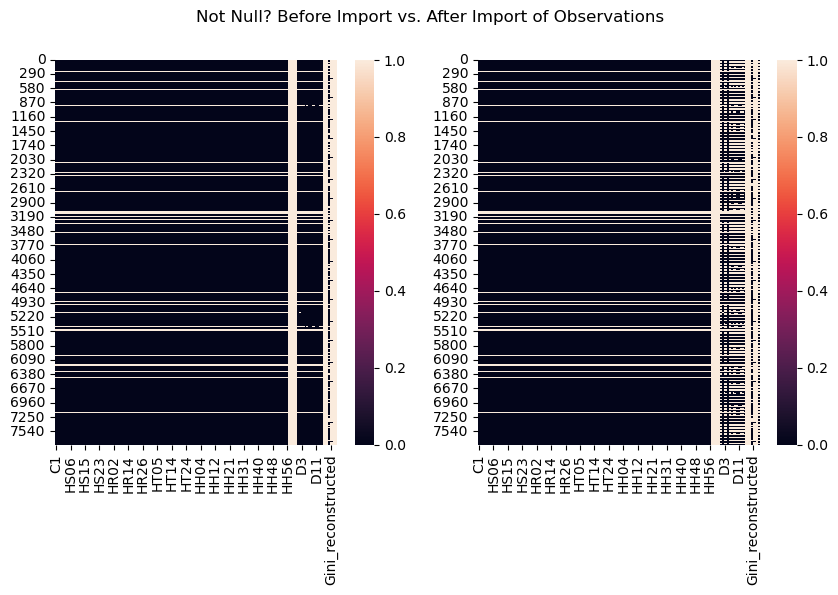

In [226]:
# Observe nulls. Most rows are null, no interpolation has occurred yet
df_merge3 = df_merge3.sort_values(by=['Country Code', 'Year'])

fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.heatmap(df_merge2.notnull(), ax=ax[0])
sns.heatmap(df_merge3.notnull(), ax=ax[1])
plt.suptitle("Not Null? Before Import vs. After Import of Observations")
plt.show()


In [227]:
# fetch description of d_cols

old_cols = d_col_df['old_col'].tolist()
code_dict.loc[code_dict['Code'].isin(old_cols), ['Code','Description']]

,Code,Description
168,D1,Human development index
170,D3,Expected years of schooling
171,D4,Mean years of schooling
173,D6,Gross National Income per capita
174,D7,Human development index female
175,D8,Expected years of schooling female
176,D9,Mean years of schooling female
177,D10,Gross National Income per capita female
178,D11,Human development index male
179,D12,Expected years of schooling male


In [228]:
# clean up unneeded columns
df_merge3 = df_merge3.drop(columns=['iso3'])

Summary: 

Nulls have been eliminated in the following columns via importing observations from external data sources:

1. Population (P1) *note that imported data was rescaled by 1,000 to match left table scale
2. Fertility rate (P3)
3. Life expectancy (P4)
4. Life expectancy female (P5)
5. Life expectancy male (P6)
6. Human development index (D1)
7. Expected years of schooling (D3)
8. Mean years of schooling (D4)
9. Gross National Income per capita (D6)
9. Human development index female (D7)
10. Expected years of schooling female (D8)
11. Mean years of schooling female (D9)
12. Gross National Income per capita female (D10)
12. Human development index male (D11)
13. Expected years of schooling male (D12)
14. Mean years of schooling male (D13)
15. Gross National Income per capita male (D14)


In [229]:
#df_merge3.head(50)

In [230]:
residual_cols_dropped

['HH02', 'HH13', 'HH24', 'HH30', 'HH36', 'HS11', 'HT09', 'HT18', 'HT25']

#### df_mstr

Table **df_mstr** is created to preserve an unaltered record of the result of all merges. This table stores the combined observations of all three merges. Any and all changes to the data pertained to **cleaning**, or **dropping of unused or duplicate columns** (see "Changes Log" above or additional details below), and **central log ratio** transformations of simplexes. 

Note that the index for df_imputer is reset in this section, to reflect country and temporal sorted order, which was interrupted by merges. 

**Dropped Columns:** The following columns are dropped from df_mstr and by extension df_imputed:

- 'HH02', 'HH13', 'HH24', 'HH30', 'HH36', 'HS11', 'HT09', 'HT18', 'HT25', 'HT26' (simplex residual columns)
- 'Year_' (duplicate of 'Year' created in merge)
- 'iso3' (duplicate of 'Country Code' created in merge)
- 'gdi' (Gross Domestic Income not needed for analysis)
- 'gdi_group' (GDI ranking not neede for analysis)
- 'C0', 'C4', 'T2', 'T3', 'T5', 'T10', 'S1', 'S2'(original CoRes columns not needed; see drop_cols_list)
    
**Filtered Columns:**
- df_merge1 involved dropping data for any countries with fewer than two rows of core feature observations, fewer than two rows of Gini observation, and less than an 8-year timespan between Gini values. This filerting carries through to df_mstr

- df_imputed is created to store modified values created during imputation with Iterative Imputer. For ease of reference, feature column names in df_imputed will not be changed versus the original table. Where alterations to the target feature occur, a changed column name is used. 


In [231]:
# Create an master to store all merged data

df_mstr = df_merge3.copy()

In [232]:
df_merge3.shape

(7808, 155)

In [233]:
df_mstr.columns

Index(['C1', 'C2', 'T1', 'HS01', 'HS02', 'HS03', 'HS04', 'HS05', 'HS06',
       'HS07',
       ...
       'D12', 'D13', 'D14', 'Country Name', 'Country Code', 'Year', 'Gini',
       'Gini_reconstructed', 'Gini_recon_hybrid', 'Gini_knn'],
      dtype='object', length=155)

#### Iterative Imputer

In Section III A we had handled missing values with linear spline interpolation, which was simple and fast, but produced poor model performance and highly unstable matrices. The goal in this section is to use additional observations available to us from outside datasets to impute the features for which we cannot find new observations.

Additional observations of non-core features were imported from United Nations data (see Table 2 and Table 3 sections). Non-core features columns in the CoResidence database start with 'D' (development indicators) or 'P' (population indicators). Once these additional rows were brought in, we leveraged these features to impute missing values, with special attention to "core features" pertaining to household configuration (columns starting with 'H').

We imported thousands of observations:
- 'D' columns retrieved an average of 3,057 new observations per column.
- 'P' columns retrieved an 7,148 new observations per column.

In the final part of Section III, we will handle missing values using matrix decomposition methods.

**Bayesian Ridge Imputer**


To impute missing values in the "core features" I chose Bayesian Ridge estimator inside of Iterative Imputer. 

Iterative Imputer treats every missing value like regression target, using the other (non-missing) row values as predictor variables. Bayesian Ridge uses a prior assumption of Gaussian distribution of coefficients, and updates the prior distribution with available data using Bayes Theorem, until posterior values converge. 

Given how sparse the dataset is, I suspected that even a converging loss function could produce highly unstable coefficients. To address this, I enabled posterior sampling via the sample_posterior=True parameter in Iterative Imputer. This allows the model to draw from the posterior distributions of the coefficients, averaging over uncertainty rather than relying on a single point estimate.

Bayesian Ridge applies priors-based regularization, which is less sensitive to feature scale than norm-penalty models. However, for comparing coefficient magnitudes after modelling, scaling would be necessary. I experimented with applying scaling at two different junctures: 
1) Prior to iterative imputation but not before modelling, and 
2) Not before iterative imputation, but before modelling. 

I found that refraining from scaling before iterative imputation was the best approach in terms of model performance.

Once imputation is performed, some post-imputation steps are applied, with two resulting versions of the imputed dataset:
More detail is provided in the Iterative Imputer Summary section.


In [234]:
df_imputed = df_merge3.copy()

In [235]:
# Make sure the index is sequential prior to shuffling
df_imputed = df_imputed.sort_values(by=['Country Code', 'Year']).reset_index(drop=True)

# Make a copy marked df_imputed_whole for "wholecloth" impution across core and non-core
df_imputed_whole = df_imputed.copy()

<Axes: >

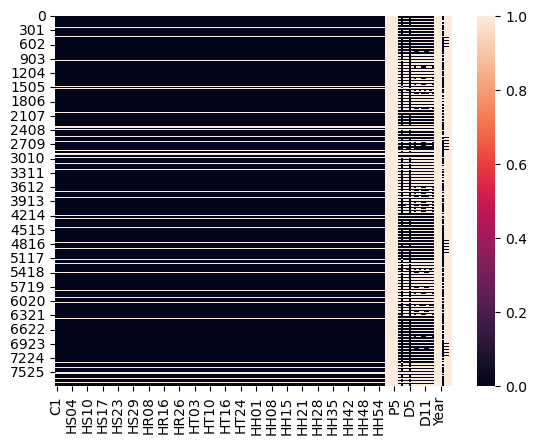

In [236]:
# observe nulls vs. not nulls
sns.heatmap(df_imputed.notnull())

In [237]:
# Vertical impuation groups consists of clr_simplex_groups and averages
vertical_groups = [
    ('HH01', 'HH01'),
    ('HH03', 'HH12'),
     ('HH14', 'HH23'),
     ('HH25', 'HH29'),
     ('HH31', 'HH35'),
     ('HS01', 'HS10'),
     ('HT01', 'HT08'),
     ('HT10', 'HT17'),
     ('HT20', 'HT24'),
     ('HS12', 'HS14'),
    ('HS15','HS15'), # 'HS15' and 'HS16' are absolute averages and do not add to one
       ('HS16','HS16'),
       ('HS17','HS30'),
       ('HT27','HT31'),
       ('HR02','HR05'),
       ('HR08','HR11'),
       ('HR14','HR17'),
       ('HR20','HR23'),
       ('HR26','HR29'),
       ('HH37','HH38'),
       ('HH39','HH40'),
       ('HH41','HH42'),
       ('HH43','HH44'),
       ('HH45','HH46'),
       ('HH47','HH48'),
       ('HH49','HH50'),
       ('HH51','HH52'),
       ('HH53','HH54'),
       ('HH55','HH56')]

In [238]:
# define horizontal_group as columns not being imputed with iterative imputer
# exclude 'Year' (an index) and 'Gini' (the target) to avoid data leakage

horizontal_group = df_imputed.columns[df_imputed.columns.str.startswith(('P', 'D'))].tolist()
print(horizontal_group)

['P1', 'P3', 'P4', 'P5', 'P6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']


In [239]:
# create h_nulls_index to use when applying min_max scaling to average_groups imputations

h_nulls = df_imputed.loc[:, df_imputed.columns.str.startswith('H')].isnull().all(axis=1)

h_nulls_index = df_imputed.loc[h_nulls,:].index
h_nulls_index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7797, 7798, 7800, 7801, 7802, 7803, 7804, 7805, 7806, 7807],
           dtype='int64', length=7084)

In [240]:
# Iterative Imputer with default Bayesian Ridge used to impute missing h_cols
# list of unique countries

unique_countries = df_imputed['Country Code'].unique().tolist()

# for each country...
for country in unique_countries:
    
    # re-initialize imputer for each loop
    imputer = IterativeImputer(random_state=21, tol=1e-4, sample_posterior=True)
    
    # for each H column group
    for start, end in vertical_groups:
        
        # indicate rows for each country
        country_rows = df_imputed['Country Code'] == country

        # select informative columns for each country, create row index
        high_info_cols = df_imputed.loc[country_rows, horizontal_group].apply(lambda cols: cols.notnull().mean() > 0.3)
        high_info_col_index = high_info_cols[high_info_cols].index
        
        # concatenate imputation group per vertical group, high info column index
        country_block = pd.concat(
            [df_imputed.loc[country_rows, start:end], df_imputed.loc[country_rows, high_info_col_index]], axis = 1
        )
        
        country_block_col_index = country_block.columns
        country_block_row_index = country_block.index
                            
         # conduct imputation, prepare output for assignment
        imputed_data = imputer.fit_transform(country_block)
        imputed_vals_df = pd.DataFrame(imputed_data, columns=country_block_col_index, index=country_block_row_index)
        
        # assign imputed values back to df_imputed
        df_imputed.loc[country_rows, start:end] = imputed_vals_df.loc[country_rows, start:end]
        
        # create a separate working copy for whole-cloth imputation metrics
        df_imputed_whole.loc[country_rows, country_block_col_index] = imputed_vals_df

# make a fresh copy of df_imputed to avoid downstream fragmentation warnings

df_imputed = df_imputed.copy()
df_imputed_whole = df_imputed_whole.copy()

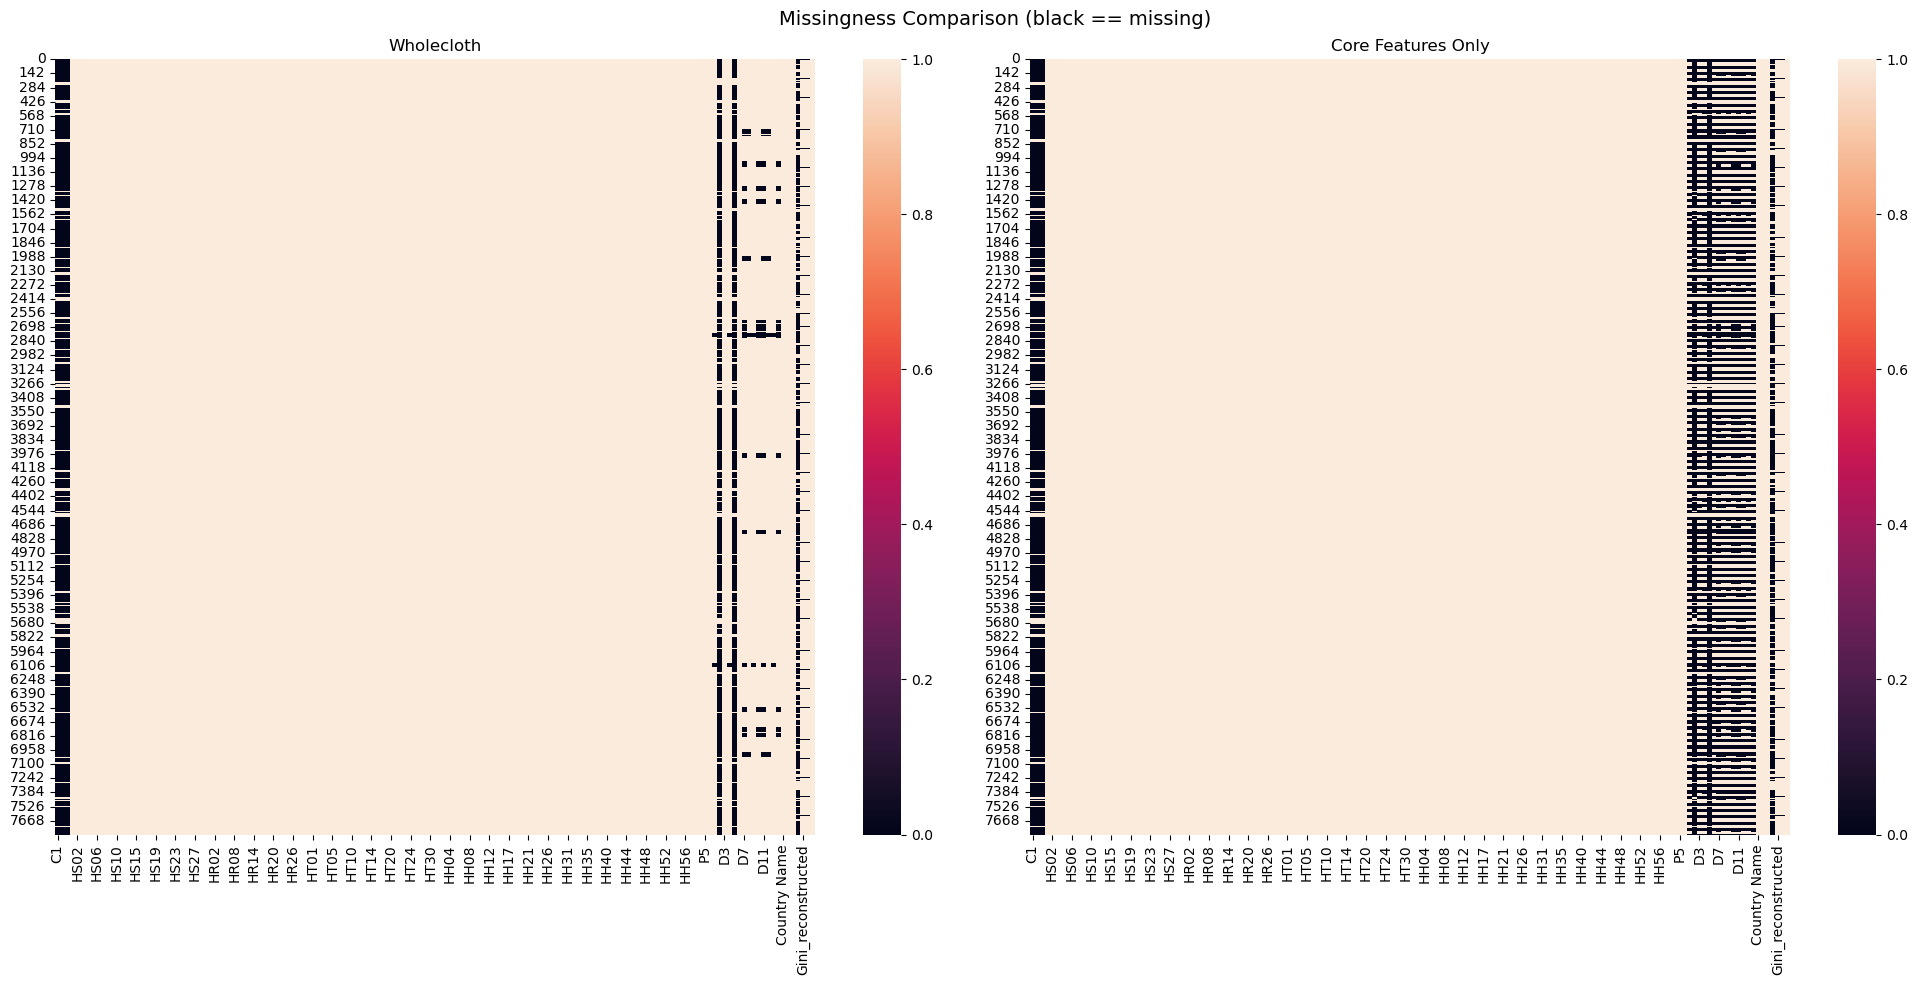

In [241]:
# check missingness

fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.heatmap(df_imputed_whole.notnull(), ax=ax[0])
sns.heatmap(df_imputed.notnull(), ax=ax[1])
plt.suptitle("Missingness Comparison (black == missing)", fontsize=14)
ax[0].set_title("Wholecloth")
ax[1].set_title("Core Features Only")
plt.tight_layout()
plt.show()

In [242]:
# Some health checks for df_imputed

print(df_imputed.shape)
print(df_imputed_whole.shape)

(7808, 155)
(7808, 155)


In [243]:
print(df_imputed.isnull().sum().sum())
print(df_imputed_whole.isnull().sum().sum())

90795
45538


In [244]:
# define a reasonable range for averages columns using pre-scaled min/max values from same columns
# not defining min/max per country to avoid introducing country bias
# use the pre-imputation ranges established from df_mstr to scale averages groups


# only applying scaling to rows that were imputed, which are captured in h_nulls_index

# (start, end, group_range)

for start, end in vertical_groups:
    mstr_group_max = df_mstr.loc[:, start:end].max().max()
    mstr_group_min = df_mstr.loc[:, start:end].min().min()
    
    print(f"Processing subset {start}:{end}. Group Min = {mstr_group_min}, Group Max = {mstr_group_max}")
    subset = df_imputed.loc[:, start:end]
    scaler = MinMaxScaler(feature_range=(mstr_group_min, mstr_group_max))
    
    scaled_data = scaler.fit_transform(subset)
    scaled_updates_df = pd.DataFrame(scaled_data, columns=subset.columns, index=df_imputed.index)

   
    # update each start, end pair
    df_imputed.loc[h_nulls_index, start:end] = scaled_updates_df.loc[h_nulls_index, subset.columns]
    

Processing subset HH01:HH01. Group Min = -0.43844608346279756, Group Max = 1.648204269229048
Processing subset HH03:HH12. Group Min = -28.156838987228713, Group Max = 15.61955382074102
Processing subset HH14:HH23. Group Min = -28.537329837401682, Group Max = 16.546193012916305
Processing subset HH25:HH29. Group Min = -27.396162417699113, Group Max = 18.505447803855148
Processing subset HH31:HH35. Group Min = -27.296370882045732, Group Max = 17.95890545057966
Processing subset HS01:HS10. Group Min = -28.084163875101833, Group Max = 15.367260160368032
Processing subset HT01:HT08. Group Min = -26.027000172199937, Group Max = 23.738330041908913
Processing subset HT10:HT17. Group Min = -29.90933309077658, Group Max = 25.952524328523022
Processing subset HT20:HT24. Group Min = -27.36999127863993, Group Max = 18.371118272882413
Processing subset HS12:HS14. Group Min = -2.8457978406469273, Group Max = 1.8749207186269883
Processing subset HS15:HS15. Group Min = 0.0170213131586522, Group Max = 0

In [245]:
# now that core features are scaled, use same to impute missing values in non-core features
# leverage unique_countries list from previous iterative imputer loop

non_core_features = df_imputed.loc[:, df_imputed.columns.str.startswith(('D', 'P'))].columns
core_features = df_imputed.loc[:, df_imputed.columns.str.startswith('H')].columns
all_features = non_core_features.union(core_features)

for country in unique_countries:
    
    #initiate imputer
    imputer = IterativeImputer(random_state=21, tol=1e-3, sample_posterior=True)
    
    # initiate
    country_rows = df_imputed['Country Code']==country
    
    country_block = df_imputed.loc[country_rows, all_features]
    
    country_block_cols = country_block.columns[country_block.notnull().any()]
    
    imputed_data = imputer.fit_transform(country_block)

    imputed_data_df = pd.DataFrame(imputed_data, columns=country_block_cols, index=country_block.index)
    
    df_imputed.loc[country_rows, non_core_features] = imputed_data_df.loc[:, non_core_features]
    

<Axes: >

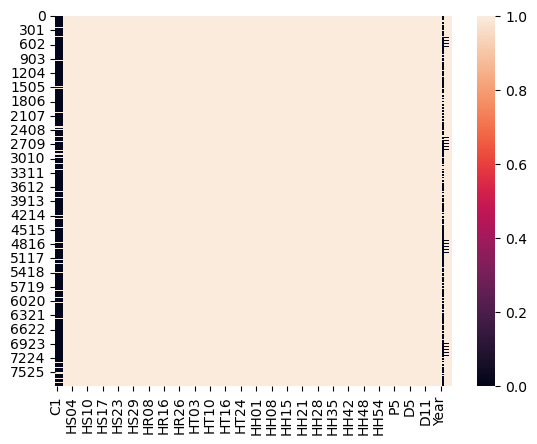

In [246]:
# Check missing values again
sns.heatmap(df_imputed.notnull())

In [247]:
# inspect columns with any null values

nulls_mask = df_imputed.isnull()

df_imputed.loc[nulls_mask.any(axis=1), nulls_mask.any(axis=0)]

,C1,C2,T1,Gini,Gini_reconstructed,Gini_recon_hybrid
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,37.762924,37.762924
4,NaN,NaN,NaN,NaN,38.265090,38.265090
...,...,...,...,...,...,...
7803,NaN,NaN,NaN,50.3,43.401287,50.300000
7804,NaN,NaN,NaN,NaN,36.837559,36.837559
7805,NaN,NaN,NaN,NaN,38.968340,38.968340
7806,NaN,NaN,NaN,NaN,39.439839,39.439839


In [248]:
# Backfill and forwardfill all remaining null values

df_imputed = df_imputed.groupby('Country Code', group_keys=False).apply(lambda group: group.bfill().ffill())

In [249]:
# shuffle
df_imputed = df_imputed.sample(frac=1)

In [250]:
# sort for time series split

df_imputed = df_imputed.sort_values(by='Year')

In [251]:
# split the data
X = df_imputed.select_dtypes(include=['number']).drop(
    columns=['T1', 'Year', 'Gini', 'Gini_knn', 'Gini_reconstructed', 'Gini_recon_hybrid', 'Gini_knn'])
y = df_imputed['Gini_knn']

In [252]:
# models

results_df, trained_models = tscv_loop(X, y, 'imputed_knn', 3, scaling=True)

Standard Scaler applied for scale-sensitive models.
Running temp model Lasso() at alpha 0.0001
Running temp model Lasso() at alpha 0.001
Running temp model Lasso() at alpha 0.01
Running temp model Lasso() at alpha 1
Running temp model Lasso() at alpha 10
Running temp model Lasso() at alpha 100
Running optimal Lasso(alpha=1) alpha 1
Running temp model Ridge() at alpha0.01
Running temp model Ridge() at alpha0.1
Running temp model Ridge() at alpha1
Running temp model Ridge() at alpha10
Running temp model Ridge() at alpha50
Running temp model Ridge() at alpha100
Running temp model Ridge() at alpha1000
Running temp model Lasso() at alpha 0.0001
Running temp model Lasso() at alpha 0.001
Running temp model Lasso() at alpha 0.01
Running temp model Lasso() at alpha 1
Running temp model Lasso() at alpha 10
Running temp model Lasso() at alpha 100
Running optimal Lasso(alpha=1) alpha 1
Running temp model Ridge() at alpha0.01
Running temp model Ridge() at alpha0.1
Running temp model Ridge() at alph

In [253]:
# view results

results_df

,Dataset,Fold,Linear Regression Train Score,Linear Regression Test Score,Lasso Alpha,Lasso Converged,Lasso Train Score,Lasso Test Score,Ridge Alpha,Matrix Cond,Ridge Train Score,Ridge Test Score,Random Forest Train Score,Random Forest Test Score,KNN Train Score,KNN Test Score,SVR Train Score,SVR Test Score
0,exploratory,1,0.860497,-31.394451,0.010,Yes,0.464315,0.682787,100,Severely ill,0.525017,0.687422,0.920257,0.655170,0.540488,0.456511,0.559278,0.554252
1,exploratory,2,0.802479,-125.153441,0.001,Yes,0.727858,0.885457,50,Severely ill,0.719906,0.883471,0.958928,0.883419,0.764749,0.700412,0.703216,0.732580
2,exploratory,3,0.834738,0.020385,0.001,Yes,0.798804,0.850059,100,Severely ill,0.789316,0.882142,0.969576,0.863173,0.820710,0.691761,0.765479,0.681248
3,baseline_knn,1,0.977670,-63.862709,1.000,Yes,0.593371,0.464950,100,Severely ill,0.832522,0.571959,0.995183,0.631151,0.950978,0.498607,0.644855,0.450848
4,baseline_knn,2,0.872271,-1.624321,0.010,No,0.819638,0.439410,100,Severely ill,0.773314,0.544775,0.990902,0.777602,0.948861,0.725908,0.629858,0.529209
5,baseline_knn,3,0.826962,-23.159900,1.000,Yes,0.508871,0.233307,1000,Severely ill,0.669469,0.391994,0.992299,0.749133,0.956125,0.598674,0.635128,0.487628
6,baseline_svd,1,0.580835,-716.109546,0.010,No,0.407736,-0.371816,100,Severely ill,0.304323,-0.143772,0.928532,0.160507,0.631802,-0.340813,0.149518,-0.522711
7,baseline_svd,2,0.464346,-1.224590,1.000,Yes,0.093486,0.100104,1000,Severely ill,0.272063,0.108992,0.931663,0.363450,0.660759,0.271901,0.235182,0.122887
8,baseline_svd,3,0.458932,-6.766397,0.001,No,0.429897,-0.158931,1000,Severely ill,0.286509,-0.099434,0.941447,0.315948,0.714800,0.004699,0.271030,-0.039727
9,baseline_bfill,1,0.969512,-83.889813,1.000,Yes,0.576661,0.432633,1000,Severely ill,0.658026,0.459715,0.995221,0.685702,0.942542,0.366805,0.590550,0.400022


In [254]:
# split the data
X = df_imputed.select_dtypes(include=['number']).drop(
    columns=['T1', 'Year', 'Gini', 'Gini_knn', 'Gini_reconstructed', 'Gini_recon_hybrid', 'Gini_knn'])
y = df_imputed['Gini_recon_hybrid']

In [255]:
results, trained_models = tscv_loop(X, y, 'imputed_svd', 3, scaling=True)

Standard Scaler applied for scale-sensitive models.
Running temp model Lasso() at alpha 0.0001
Running temp model Lasso() at alpha 0.001
Running temp model Lasso() at alpha 0.01
Running temp model Lasso() at alpha 1
Running temp model Lasso() at alpha 10
Running temp model Lasso() at alpha 100
Running optimal Lasso(alpha=1) alpha 1
Running temp model Ridge() at alpha0.01
Running temp model Ridge() at alpha0.1
Running temp model Ridge() at alpha1
Running temp model Ridge() at alpha10
Running temp model Ridge() at alpha50
Running temp model Ridge() at alpha100
Running temp model Ridge() at alpha1000
Running temp model Lasso() at alpha 0.0001
Running temp model Lasso() at alpha 0.001
Running temp model Lasso() at alpha 0.01
Running temp model Lasso() at alpha 1
Running temp model Lasso() at alpha 10
Running temp model Lasso() at alpha 100
Running optimal Lasso(alpha=0.001) alpha 0.001
Running temp model Ridge() at alpha0.01
Running temp model Ridge() at alpha0.1
Running temp model Ridge()

In [256]:
results

,Dataset,Fold,Linear Regression Train Score,Linear Regression Test Score,Lasso Alpha,Lasso Converged,Lasso Train Score,Lasso Test Score,Ridge Alpha,Matrix Cond,Ridge Train Score,Ridge Test Score,Random Forest Train Score,Random Forest Test Score,KNN Train Score,KNN Test Score,SVR Train Score,SVR Test Score
0,exploratory,1,0.860497,-31.394451,0.010,Yes,0.464315,0.682787,100.00,Severely ill,0.525017,0.687422,0.920257,0.655170,0.540488,0.456511,0.559278,0.554252
1,exploratory,2,0.802479,-125.153441,0.001,Yes,0.727858,0.885457,50.00,Severely ill,0.719906,0.883471,0.958928,0.883419,0.764749,0.700412,0.703216,0.732580
2,exploratory,3,0.834738,0.020385,0.001,Yes,0.798804,0.850059,100.00,Severely ill,0.789316,0.882142,0.969576,0.863173,0.820710,0.691761,0.765479,0.681248
3,baseline_knn,1,0.977670,-63.862709,1.000,Yes,0.593371,0.464950,100.00,Severely ill,0.832522,0.571959,0.995183,0.631151,0.950978,0.498607,0.644855,0.450848
4,baseline_knn,2,0.872271,-1.624321,0.010,No,0.819638,0.439410,100.00,Severely ill,0.773314,0.544775,0.990902,0.777602,0.948861,0.725908,0.629858,0.529209
5,baseline_knn,3,0.826962,-23.159900,1.000,Yes,0.508871,0.233307,1000.00,Severely ill,0.669469,0.391994,0.992299,0.749133,0.956125,0.598674,0.635128,0.487628
6,baseline_svd,1,0.580835,-716.109546,0.010,No,0.407736,-0.371816,100.00,Severely ill,0.304323,-0.143772,0.928532,0.160507,0.631802,-0.340813,0.149518,-0.522711
7,baseline_svd,2,0.464346,-1.224590,1.000,Yes,0.093486,0.100104,1000.00,Severely ill,0.272063,0.108992,0.931663,0.363450,0.660759,0.271901,0.235182,0.122887
8,baseline_svd,3,0.458932,-6.766397,0.001,No,0.429897,-0.158931,1000.00,Severely ill,0.286509,-0.099434,0.941447,0.315948,0.714800,0.004699,0.271030,-0.039727
9,baseline_bfill,1,0.969512,-83.889813,1.000,Yes,0.576661,0.432633,1000.00,Severely ill,0.658026,0.459715,0.995221,0.685702,0.942542,0.366805,0.590550,0.400022


<Axes: >

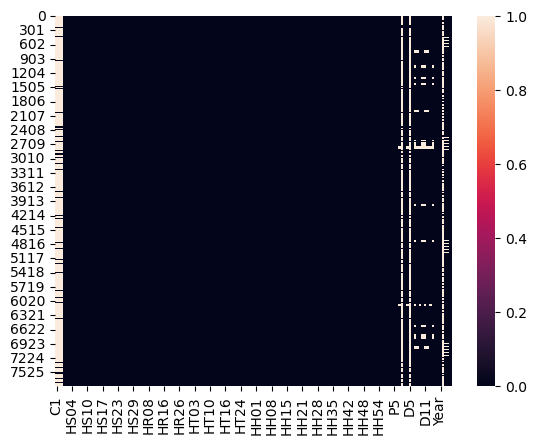

In [257]:
# examine wholecloth imputation
sns.heatmap(df_imputed_whole.isnull())

In [258]:
# wholecloth imputed values (no post imputation processing)

df_imputed_whole = df_imputed_whole.groupby('Country Code', group_keys=False).apply(
    lambda group: group.ffill().bfill()
)
df_imputed_whole = df_imputed_whole.sample(frac=1)
df_imputed_whole = df_imputed_whole.sort_values(by='Year')

X = df_imputed_whole.select_dtypes(include=['number']).drop(
    columns=['Gini', 'Gini_reconstructed', 'Gini_recon_hybrid', 'Gini_knn', 'Year']
)

y_knn = df_imputed_whole['Gini_knn']
y_svd = df_imputed_whole['Gini_recon_hybrid']
y_bfill = df_imputed_whole['Gini']

wholecloth_results_knn, trained_models = tscv_loop(X, y_knn, 'imputed_wholecloth_knn', 3, scaling=True)
wholecloth_results_svd, trained_models = tscv_loop(X, y_svd, 'imputed_wholecloth_svd', 3, scaling=True)
wholecloth_results_bfill, trained_models = tscv_loop(X, y_bfill, 'imputed_wholecloth_bfill', 3, scaling=True)

Standard Scaler applied for scale-sensitive models.
Running temp model Lasso() at alpha 0.0001
Running temp model Lasso() at alpha 0.001
Running temp model Lasso() at alpha 0.01
Running temp model Lasso() at alpha 1
Running temp model Lasso() at alpha 10
Running temp model Lasso() at alpha 100
Running optimal Lasso(alpha=1) alpha 1
Running temp model Ridge() at alpha0.01
Running temp model Ridge() at alpha0.1
Running temp model Ridge() at alpha1
Running temp model Ridge() at alpha10
Running temp model Ridge() at alpha50
Running temp model Ridge() at alpha100
Running temp model Ridge() at alpha1000
Running temp model Lasso() at alpha 0.0001
Running temp model Lasso() at alpha 0.001
Running temp model Lasso() at alpha 0.01
Running temp model Lasso() at alpha 1
Running temp model Lasso() at alpha 10
Running temp model Lasso() at alpha 100
Running optimal Lasso(alpha=1) alpha 1
Running temp model Ridge() at alpha0.01
Running temp model Ridge() at alpha0.1
Running temp model Ridge() at alph

In [259]:
wholecloth_results_bfill

,Dataset,Fold,Linear Regression Train Score,Linear Regression Test Score,Lasso Alpha,Lasso Converged,Lasso Train Score,Lasso Test Score,Ridge Alpha,Matrix Cond,Ridge Train Score,Ridge Test Score,Random Forest Train Score,Random Forest Test Score,KNN Train Score,KNN Test Score,SVR Train Score,SVR Test Score
0,exploratory,1,0.860497,-31.394451,0.010,Yes,0.464315,0.682787,100.00,Severely ill,0.525017,0.687422,0.920257,0.655170,0.540488,0.456511,0.559278,0.554252
1,exploratory,2,0.802479,-125.153441,0.001,Yes,0.727858,0.885457,50.00,Severely ill,0.719906,0.883471,0.958928,0.883419,0.764749,0.700412,0.703216,0.732580
2,exploratory,3,0.834738,0.020385,0.001,Yes,0.798804,0.850059,100.00,Severely ill,0.789316,0.882142,0.969576,0.863173,0.820710,0.691761,0.765479,0.681248
3,baseline_knn,1,0.977670,-63.862709,1.000,Yes,0.593371,0.464950,100.00,Severely ill,0.832522,0.571959,0.995183,0.631151,0.950978,0.498607,0.644855,0.450848
4,baseline_knn,2,0.872271,-1.624321,0.010,No,0.819638,0.439410,100.00,Severely ill,0.773314,0.544775,0.990902,0.777602,0.948861,0.725908,0.629858,0.529209
5,baseline_knn,3,0.826962,-23.159900,1.000,Yes,0.508871,0.233307,1000.00,Severely ill,0.669469,0.391994,0.992299,0.749133,0.956125,0.598674,0.635128,0.487628
6,baseline_svd,1,0.580835,-716.109546,0.010,No,0.407736,-0.371816,100.00,Severely ill,0.304323,-0.143772,0.928532,0.160507,0.631802,-0.340813,0.149518,-0.522711
7,baseline_svd,2,0.464346,-1.224590,1.000,Yes,0.093486,0.100104,1000.00,Severely ill,0.272063,0.108992,0.931663,0.363450,0.660759,0.271901,0.235182,0.122887
8,baseline_svd,3,0.458932,-6.766397,0.001,No,0.429897,-0.158931,1000.00,Severely ill,0.286509,-0.099434,0.941447,0.315948,0.714800,0.004699,0.271030,-0.039727
9,baseline_bfill,1,0.969512,-83.889813,1.000,Yes,0.576661,0.432633,1000.00,Severely ill,0.658026,0.459715,0.995221,0.685702,0.942542,0.366805,0.590550,0.400022


#### Iterative Imputer Summary


**Imputation Loop: Two Approaches**


To apply Iterative Imputer to the imported observations, I used a blocking approach, which fused country-specific core feature columns with enhanced columns population and development features, forming dynamic imputation blocks. I set threshold of 30% sparsity per "informative column" in each block, allowing blocks to grow or shrink based on availability of supplemental data per country.

The imputation loop created two resulting tables:
1) df_imputed - in which only core features columns are updated with imputed values
2) df_imputed_whole - in which all missing values regardless of feature sub-family are updated with imputed values

The first resulting table, **df_imputed**, was subjected to post-imputation processing steps outlined below. The second table, **df_imputed_whole** was merely backfilled and forward filled. Ultimately, the wholecloth imputed values with no post processing produced the best model scores and most stable matrices. More detail on this in Section IV.

**Post Imputation Processing**


After initial imputation, I applied the following transformations:

- Scaled imputed values: Column groupings were scaled to match the min/max range of their pre-scaled counterparts.

I then attempted a second round of imputation, reversing direction: Instead of imputing core features from P/D columns, I used the scaled, imputed core features to fill in gaps in the P/D columns. However, this approach consistently degraded model performance and was ultimately not fruitful.

### C: Matrix Factorization Reconstruction

Given the matrix instability encountered when modeling both imputed and interpolated datasets, I wanted to explore a method specifically designed to handle matrix insufficiency: **Truncated Singular Value Decomposition** (SVD)

Matrix decomposition captures global structure in the data by breaking down the original matrix into components, analogous to factoring a number. These latent components consist of second order vectors, which encapsulate the interaction between orthogonal basis vectors. "Basis" vectors can be thought of as the necessary and sufficient vectors of the dataset, distilled of all redundancy (collinearity), both on a vertical axis and on a horizontal axis. The singular values, in turn, describe the magitude of the latent components. 

In essence, SVD transforms an unruly and unstable matrix into an idealized version of the matrix, by projecting the basis vectors into orthogonal space. The data undergoes a basis transformation, where new, more informative structures emerge.

Interpolation and iterative imputation rely heavily on row-wise or column-wise relationships, which can be effective in dense datasets. But in my case, the data is both sparse (many missing values) and high-dimensional (many features, some of which are highly correlated). In such an environment, piecewise imputation can overlook broader patterns and exacerbate instability.

In [260]:
# create a copy of df_mstr to subject to SVD reconstruction

df_decompose = df_mstr.copy()

In [261]:
# sort values to maintain order of meaningful structure for purposes of decomposition

df_decompose = df_decompose.sort_values(by=['Country Code', 'Year'])

In [262]:
df_decompose.head()

,C1,C2,T1,HS01,HS02,HS03,HS04,HS05,HS06,HS07,...,D12,D13,D14,Country Name,Country Code,Year,Gini,Gini_reconstructed,Gini_recon_hybrid,Gini_knn
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1960,NaN,NaN,NaN,31.008333
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1961,NaN,NaN,NaN,31.008333
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1962,NaN,NaN,NaN,31.008333
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1963,NaN,37.762924,37.762924,31.008333
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Albania,ALB,1964,NaN,38.265090,38.265090,31.008333


In [263]:
# drop target from df_decompose

X_decompose = df_decompose.drop(['Year', 'Gini', 'Gini_reconstructed', 'Gini_recon_hybrid', 'Gini_knn'], axis=1)

In [264]:
# fill null values with respective column means to prepare for nmf

X_filled = X_decompose.groupby('Country Code', group_keys=False).apply(lambda x: x.fillna(x.mean(numeric_only=True)))

In [265]:
X_filled.shape[1]

150

In [276]:
# scale the data

scaler = StandardScaler()
columns_to_scale = X_filled.select_dtypes(include=['number']).columns.difference(all_clr_columns)
X_ss_scaled = X_filled.copy()
X_ss_scaled[columns_to_scale] = scaler.fit_transform(X_filled[columns_to_scale])
X_ss_scaled = X_ss_scaled.select_dtypes(include=['number'])


In [277]:
# svd

# scale the data

svd_models = {}
singular_values_dict = {}

for n_components in range(1, X_filled.select_dtypes(include=['number']).shape[1]):
    svd = TruncatedSVD(n_components=n_components, random_state=21)
    U = svd.fit_transform(X_ss_scaled)
    svd_models[n_components] = U
    singular_values_dict[n_components] = svd.singular_values_

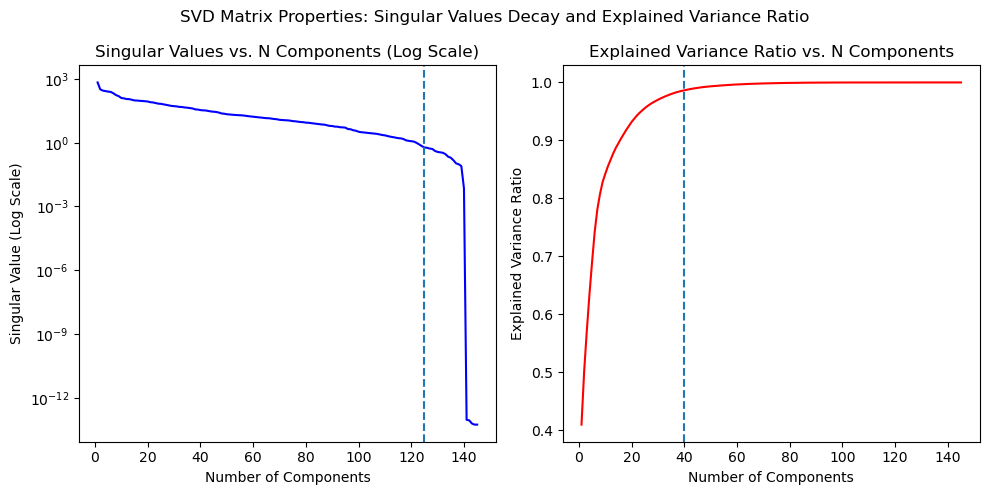

In [278]:
# plot the relevant info
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

x = list(range(1, max(singular_values_dict.keys())+1))
y = singular_values_dict[max(x)]

cumulative = np.cumsum(svd.explained_variance_ratio_)

ax[0].plot(x, y, color='blue')
ax[0].set_yscale('log')
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Singular Value (Log Scale)')
ax[0].set_title("Singular Values vs. N Components (Log Scale)")
ax[0].axvline(125, linestyle='--')
   
ax[1].plot(x, cumulative, color='red')
ax[1].set_title('Explained Variance Ratio vs. N Components')
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Explained Variance Ratio')
ax[1].axvline(40, linestyle='--')

plt.suptitle('SVD Matrix Properties: Singular Values Decay and Explained Variance Ratio')
plt.tight_layout()
plt.show()

In [268]:
# perform final svd with optimal number of components equal to 60

svd_models = {}

for n_components in [60, 125]:
    svd = TruncatedSVD(n_components=n_components, random_state=21)
    U = svd.fit_transform(X_ss_scaled)

    df_U = pd.DataFrame(U, columns=[f"SV{i+1}" for i in range(U.shape[1])], index=X_filled.index)

    # add back columns

    df_U['Year'] = df_decompose['Year']
    df_U['Country Code'] = df_decompose['Country Code']
    df_U['Country Name'] = df_decompose['Country Name']
    df_U['Gini_knn'] = df_decompose['Gini_knn']
    df_U['Gini_recon_hybrid'] = df_decompose['Gini_recon_hybrid']
    df_U['Gini'] = df_decompose['Gini']

    # shuffle

    df_U = df_U.sample(frac=1)

    # sort

    df_U = df_U.sort_values(by='Year')
    
    svd_models[f'n_components_U_{n_components}'] = df_U

# split

    X = df_U.drop(columns=['Year', 'Country Code', 'Country Name', 'Gini_knn', 'Gini_recon_hybrid', 'Gini'])
    targets = {
        "knn": "Gini_knn",
        "svd": "Gini_recon_hybrid",
        "bfill": "Gini"
}

    for label, column in targets.items():
        y = df_U[column]
        model_name = f"svd_{n_components}_{label}"
        results, trained_models = tscv_loop(X, y, model_name, 3, scaling=False)

Running temp model Lasso() at alpha 0.0001
Running temp model Lasso() at alpha 0.001
Running temp model Lasso() at alpha 0.01
Running temp model Lasso() at alpha 1
Running temp model Lasso() at alpha 10
Running temp model Lasso() at alpha 100
Running optimal Lasso(alpha=0.01) alpha 0.01
Running temp model Ridge() at alpha0.01
Running temp model Ridge() at alpha0.1
Running temp model Ridge() at alpha1
Running temp model Ridge() at alpha10
Running temp model Ridge() at alpha50
Running temp model Ridge() at alpha100
Running temp model Ridge() at alpha1000
Running temp model Lasso() at alpha 0.0001
Running temp model Lasso() at alpha 0.001
Running temp model Lasso() at alpha 0.01
Running temp model Lasso() at alpha 1
Running temp model Lasso() at alpha 10
Running temp model Lasso() at alpha 100
Running optimal Lasso(alpha=0.01) alpha 0.01
Running temp model Ridge() at alpha0.01
Running temp model Ridge() at alpha0.1
Running temp model Ridge() at alpha1
Running temp model Ridge() at alpha10

In [269]:
results

,Dataset,Fold,Linear Regression Train Score,Linear Regression Test Score,Lasso Alpha,Lasso Converged,Lasso Train Score,Lasso Test Score,Ridge Alpha,Matrix Cond,Ridge Train Score,Ridge Test Score,Random Forest Train Score,Random Forest Test Score,KNN Train Score,KNN Test Score,SVR Train Score,SVR Test Score
0,exploratory,1,0.860497,-31.394451,0.010,Yes,0.464315,0.682787,100.00,Severely ill,0.525017,0.687422,0.920257,0.655170,0.540488,0.456511,0.559278,0.554252
1,exploratory,2,0.802479,-125.153441,0.001,Yes,0.727858,0.885457,50.00,Severely ill,0.719906,0.883471,0.958928,0.883419,0.764749,0.700412,0.703216,0.732580
2,exploratory,3,0.834738,0.020385,0.001,Yes,0.798804,0.850059,100.00,Severely ill,0.789316,0.882142,0.969576,0.863173,0.820710,0.691761,0.765479,0.681248
3,baseline_knn,1,0.977670,-63.862709,1.000,Yes,0.593371,0.464950,100.00,Severely ill,0.832522,0.571959,0.995183,0.631151,0.950978,0.498607,0.644855,0.450848
4,baseline_knn,2,0.872271,-1.624321,0.010,No,0.819638,0.439410,100.00,Severely ill,0.773314,0.544775,0.990902,0.777602,0.948861,0.725908,0.629858,0.529209
5,baseline_knn,3,0.826962,-23.159900,1.000,Yes,0.508871,0.233307,1000.00,Severely ill,0.669469,0.391994,0.992299,0.749133,0.956125,0.598674,0.635128,0.487628
6,baseline_svd,1,0.580835,-716.109546,0.010,No,0.407736,-0.371816,100.00,Severely ill,0.304323,-0.143772,0.928532,0.160507,0.631802,-0.340813,0.149518,-0.522711
7,baseline_svd,2,0.464346,-1.224590,1.000,Yes,0.093486,0.100104,1000.00,Severely ill,0.272063,0.108992,0.931663,0.363450,0.660759,0.271901,0.235182,0.122887
8,baseline_svd,3,0.458932,-6.766397,0.001,No,0.429897,-0.158931,1000.00,Severely ill,0.286509,-0.099434,0.941447,0.315948,0.714800,0.004699,0.271030,-0.039727
9,baseline_bfill,1,0.969512,-83.889813,1.000,Yes,0.576661,0.432633,1000.00,Severely ill,0.658026,0.459715,0.995221,0.685702,0.942542,0.366805,0.590550,0.400022


In [270]:
fold_3_scores = results.loc[results['Fold']==3, ~results.columns.str.contains('Train')]
fold_3_scores

,Dataset,Fold,Linear Regression Test Score,Lasso Alpha,Lasso Converged,Lasso Test Score,Ridge Alpha,Matrix Cond,Ridge Test Score,Random Forest Test Score,KNN Test Score,SVR Test Score
2,exploratory,3,0.020385,0.001,Yes,0.850059,100.00,Severely ill,0.882142,0.863173,0.691761,0.681248
5,baseline_knn,3,-23.159900,1.000,Yes,0.233307,1000.00,Severely ill,0.391994,0.749133,0.598674,0.487628
8,baseline_svd,3,-6.766397,0.001,No,-0.158931,1000.00,Severely ill,-0.099434,0.315948,0.004699,-0.039727
11,baseline_bfill,3,-29.485802,1.000,Yes,0.065068,1000.00,Severely ill,0.245407,0.678523,0.517212,0.381272
14,imputed_knn,3,0.021001,1.000,Yes,0.126816,1000.00,Stable,0.110645,0.492937,0.128456,0.088356
17,imputed_svd,3,-0.153671,10.000,Yes,-0.018416,1000.00,Stable,-0.059766,0.065447,-0.326019,-0.007320
20,imputed_wholecloth_knn,3,0.078431,1.000,Yes,0.124677,0.01,Stable,0.078029,0.520023,0.200161,0.099261
23,imputed_wholecloth_svd,3,-0.381671,10.000,Yes,-0.018405,1000.00,Stable,-0.158700,0.142527,-0.097614,0.007086
26,imputed_wholecloth_bfill,3,-0.029807,1.000,Yes,0.151538,1000.00,Stable,0.050787,0.468027,-0.041737,0.057230
29,svd_60,3,0.559103,0.010,Yes,0.579414,100.00,Stable,0.591776,0.780215,0.840829,0.817470


# Plotting the Regularization

In [271]:
# feed the different U versions to different models

svd_best_parameters = []

for n_components, U in svd_models.items():
    df_U = pd.DataFrame(U, index=X_filled.index, columns=[f"SV{i+1}" for i in range(U.shape[1])])
    df_U['n_components'] = n_components
    
    # shuffle
    df_U['Year'] = df_decompose['Year']
    df_U['Country Code'] = df_decompose['Country Code']
    df_U['Country Name'] = df_decompose['Country Name']
    df_U['Gini_knn'] = df_knn_gini['Gini_knn']
    
    df_U = df_U.sample(frac=1)

    # sort
    df_U.sort_values(by='Year')
    
    # split
    X = df_U.drop(columns=['Year', 'Country Code', 'Country Name', 'Gini_knn'])
    y = df_U['Gini_knn']
    
    # feed to models
    
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(),
        'Ridge': Ridge(),
        'Random Forest' : RandomForestRegressor(random_state=21),
        'Gradient Boost': GradientBoostingRegressor(random_state=21)
             }
    
    for model_name, model in models.items():
        tscv = TimeSeriesSplit(n_splits=3)
        
        if isinstance(model, Lasso):
            param_grid = {'alpha':[0.001, 0.01, 0.1, 1, 10],
                         'max_iter':[10000]}
            grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
            grid_search.fit(X, y)
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
        
        elif isinstance(model, Ridge):
            param_grid = {'alpha':[0.1, 1, 5, 10, 50],
                         'max_iter':[10000]}
            grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
            grid_search.fit(X, y)
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            
        else:
            best_params = {}
            best_score = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error').mean()

            
        svd_best_parameters.append({
                'n_components':n_components,
                'model_name':model_name,
                'best_params':best_params,
                'best_score':best_score
            })


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e+01, tolerance: 1.274e+01
  model = cd_fast.enet_coordinate_descent(
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.776e+02, tolerance: 1.258e+01
  model = cd_fast.enet_coordinate_descent(
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

In [272]:
# inspect parameter values
svd_params_df = pd.DataFrame(svd_best_parameters)
svd_params_df

,n_components,model_name,best_params,best_score
0,1,Linear Regression,{},-56.661967
1,1,Lasso,"{'alpha': 0.1, 'max_iter': 10000}",-56.661697
2,1,Ridge,"{'alpha': 50, 'max_iter': 10000}",-56.661941
3,1,Random Forest,{},-28.195065
4,1,Gradient Boost,{},-28.927259
...,...,...,...,...
720,145,Linear Regression,{},-36.624618
721,145,Lasso,"{'alpha': 0.01, 'max_iter': 10000}",-21.153178
722,145,Ridge,"{'alpha': 50, 'max_iter': 10000}",-19.691818
723,145,Random Forest,{},-4.614120


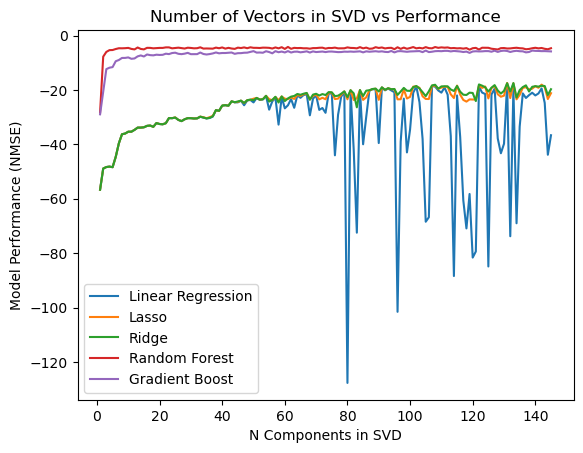

In [273]:
# plot

for model in svd_params_df['model_name'].unique():
    x = svd_params_df.loc[svd_params_df['model_name']==model, 'n_components']
    y = svd_params_df.loc[svd_params_df['model_name']==model, 'best_score']
    plt.plot(x, y, label=model)

plt.legend()
plt.xlabel('N Components in SVD')
plt.ylabel('Model Performance (NMSE)')
plt.title('Number of Vectors in SVD vs Performance')
plt.show()

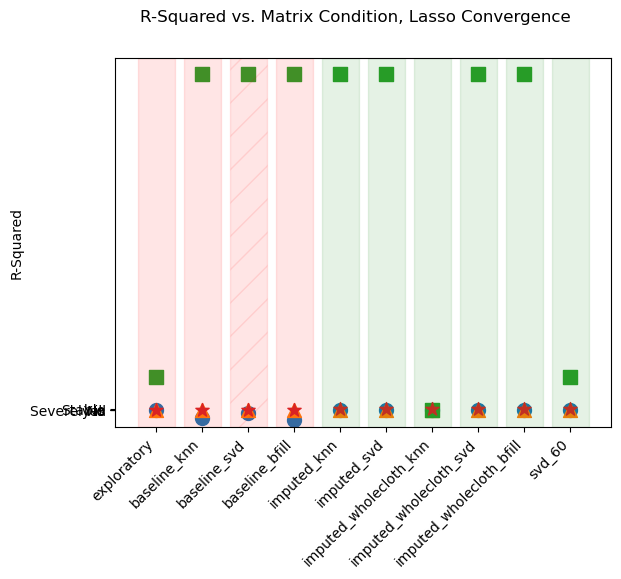

In [274]:
# plot test performance

fig, ax = plt.subplots()

x = range(len(fold_3_scores['Dataset']))



ax.scatter(x, fold_3_scores.iloc[:, 2], marker='o', s=100)
ax.scatter(x, fold_3_scores.iloc[:, 4], marker='^', s=100)
ax.scatter(x, fold_3_scores.iloc[:, 6], marker='s', s=100)
ax.scatter(x, fold_3_scores.iloc[:, 7], marker='*', s=100)
ax.set_xticks(x)
ax.set_xticklabels(fold_3_scores['Dataset'], rotation=45, ha='right')

for i, (condition, converged) in enumerate(zip(fold_3_scores['Matrix Cond'], fold_3_scores['Lasso Converged'])):
    color = 'green' if condition == 'Stable' else 'red'
    if converged == 'No':
        ax.axvspan(i-0.4, i+0.4, color=color, hatch='/', alpha=0.1)
    else:
        ax.axvspan(i-0.4, i+0.4, color=color, alpha=0.1)
        
        
#plt.legend(bbox_to_anchor=(1,1))
plt.suptitle("R-Squared vs. Matrix Condition, Lasso Convergence")
plt.ylabel("R-Squared")
plt.show()

# Conclusion

